# Black Carbon Analysis: FTIR EC/OC and HIPS Fabs Data Integration (Refactored)
 
This notebook analyzes the relationship between FTIR-based carbon measurements (EC, OC)
and HIPS-based light absorption measurements (Fabs) from the SPARTAN database.
**Refactored version to eliminate redundant analyses and streamline the workflow.**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


=============================================================================
CONFIGURATION AND DATA LOADING
=============================================================================

In [ ]:
# Configuration parameters
DB_PATH = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/Combined Database/spartan_ftir_hips.db"
SITE_OF_INTEREST = "ETAD"

def load_data_from_db(db_path, site_code):
    """Load and validate data from SQLite database for a specific site."""
    try:
        conn = sqlite3.connect(db_path)
        
        # Check if site exists
        site_query = "SELECT DISTINCT site_code FROM filters WHERE site_code = ?"
        site_exists = pd.read_sql_query(site_query, conn, params=(site_code,))
        
        if len(site_exists) == 0:
            print(f"Site '{site_code}' not found in database. Available sites:")
            all_sites = pd.read_sql_query("SELECT DISTINCT site_code FROM filters", conn)
            print(", ".join(all_sites['site_code'].tolist()))
            conn.close()
            return pd.DataFrame()
        
        # Main query
        query = """
        SELECT 
            f.filter_id, f.sample_date, f.site_code, m.volume_m3,
            m.ec_ftir, m.ec_ftir_mdl, m.oc_ftir, m.oc_ftir_mdl,
            m.fabs, m.fabs_mdl, m.fabs_uncertainty, m.ftir_batch_id
        FROM filters f
        JOIN ftir_sample_measurements m USING(filter_id)
        WHERE f.site_code = ? AND
              m.ec_ftir IS NOT NULL AND
              m.oc_ftir IS NOT NULL AND
              m.fabs IS NOT NULL
        ORDER BY f.sample_date
        """
        
        df = pd.read_sql_query(query, conn, params=(site_code,))
        df['sample_date'] = pd.to_datetime(df['sample_date'])
        conn.close()
        
        print(f"Loaded {len(df)} samples for site {site_code} with both FTIR and HIPS measurements")
        print(f"Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
        
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

# Load the data
data = load_data_from_db(DB_PATH, SITE_OF_INTEREST)


Loaded 162 samples for site ETAD with both FTIR and HIPS measurements
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00


=============================================================================
DATA PREPROCESSING AND QUALITY CONTROL
=============================================================================

In [7]:
def preprocess_data(df, site_code):
    """Complete data preprocessing pipeline."""
    
    print(f"\n===== {site_code} Data Overview =====")
    print(f"Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
    print(f"Number of samples: {len(df)}")
    
    print("\n===== Missing Values =====")
    print(df.isnull().sum())
    
    print("\n===== Basic Statistics =====")
    stats = df[['ec_ftir', 'oc_ftir', 'fabs']].describe()
    print(stats)
    
    # Check for values below MDL
    below_mdl = {
        'EC': (df['ec_ftir'] < df['ec_ftir_mdl']).mean() * 100,
        'OC': (df['oc_ftir'] < df['oc_ftir_mdl']).mean() * 100,
        'Fabs': (df['fabs'] < df['fabs_mdl']).mean() * 100
    }
    print(f"\n===== Values Below MDL =====")
    for key, value in below_mdl.items():
        print(f"{key}: {value:.1f}% below MDL")
    
    # Handle values below MDL (conservative approach: replace with MDL/2)
    df_processed = df.copy()
    for col, mdl_col in [('ec_ftir', 'ec_ftir_mdl'), ('oc_ftir', 'oc_ftir_mdl'), ('fabs', 'fabs_mdl')]:
        mask_below_mdl = df_processed[col] < df_processed[mdl_col]
        below_count = mask_below_mdl.sum()
        if below_count > 0:
            df_processed.loc[mask_below_mdl, col] = df_processed.loc[mask_below_mdl, mdl_col] / 2
            print(f"Replaced {below_count} values below MDL in {col} with MDL/2")
    
    # Calculate derived metrics
    df_processed['oc_ec_ratio'] = df_processed['oc_ftir'] / df_processed['ec_ftir']
    df_processed['mac'] = df_processed['fabs'] / df_processed['ec_ftir']
    df_processed['month'] = df_processed['sample_date'].dt.month
    
    # Ethiopian season mapping
    def map_ethiopian_seasons(month):
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:
            return 'Kiremt Rainy Season'
    
    df_processed['season'] = df_processed['month'].apply(map_ethiopian_seasons)
    
    # Clean extreme values
    df_clean = df_processed[
        (df_processed['mac'] < 50) & 
        (df_processed['oc_ec_ratio'] < 20)
    ]
    
    if len(df_clean) < len(df_processed):
        print(f"Removed {len(df_processed) - len(df_clean)} samples with extreme values")
    
    return df_clean

# Preprocess the data
data_processed = preprocess_data(data, SITE_OF_INTEREST)


===== ETAD Data Overview =====
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
Number of samples: 162

===== Missing Values =====
filter_id           0
sample_date         0
site_code           0
volume_m3           0
ec_ftir             0
ec_ftir_mdl         0
oc_ftir             0
oc_ftir_mdl         0
fabs                0
fabs_mdl            0
fabs_uncertainty    0
ftir_batch_id       0
dtype: int64

===== Basic Statistics =====
          ec_ftir     oc_ftir        fabs
count  162.000000  162.000000  162.000000
mean     4.663528    6.281690   47.258976
std      2.034262    2.849580    9.739997
min      0.693115    0.617765   28.085699
25%      3.046502    4.232311   40.238902
50%      4.049773    5.530220   45.859240
75%      6.009214    7.416377   52.977287
max     10.533354   15.332336   74.191711

===== Values Below MDL =====
EC: 0.0% below MDL
OC: 0.6% below MDL
Fabs: 0.0% below MDL
Replaced 1 values below MDL in oc_ftir with MDL/2
Removed 1 samples with extreme values



ENHANCED MAC ANALYSIS WITH BC CALCULATION SOLUTIONS - YOUR_SITE_CODE
Data: 161 samples
EC range: 1.6-10.5 μg/m³
Fabs range: 28.1-74.2 Mm⁻¹

MAC CALCULATION METHODS SUMMARY
Method 1 MAC (Mean of Ratios): 11.151 m²/g
Method 2 MAC (Ratio of Means): 10.092 m²/g
Method 3 MAC (Regression): 4.198 m²/g, Intercept: 27.634
Method 4 MAC (Origin Regression): 9.177 m²/g

GENERATING PREDICTIONS FROM EACH METHOD
Method 1 predictions: Fabs = 11.151 × EC
Range: 18.1 to 117.5 Mm⁻¹
Method 2 predictions: Fabs = 10.092 × EC
Range: 16.4 to 106.3 Mm⁻¹
Method 3 predictions: Fabs = 4.198 × EC + 27.634
Range: 34.5 to 71.9 Mm⁻¹
Method 4 predictions: Fabs = 9.177 × EC
Range: 14.9 to 96.7 Mm⁻¹

MANUAL R² CALCULATION FOR EACH METHOD
R² = [correlation(EC_original, Fabs_predicted)]²

📊 Method 1: Mean of Individual Ratios
   Correlation(EC, Fabs_pred) = 1.000000
   R² = r² = 1.000000
   p-value = 0.00e+00

📊 Method 2: Ratio of Means
   Correlation(EC, Fabs_pred) = 1.000000
   R² = r² = 1.000000
   p-value = 0.00e+00


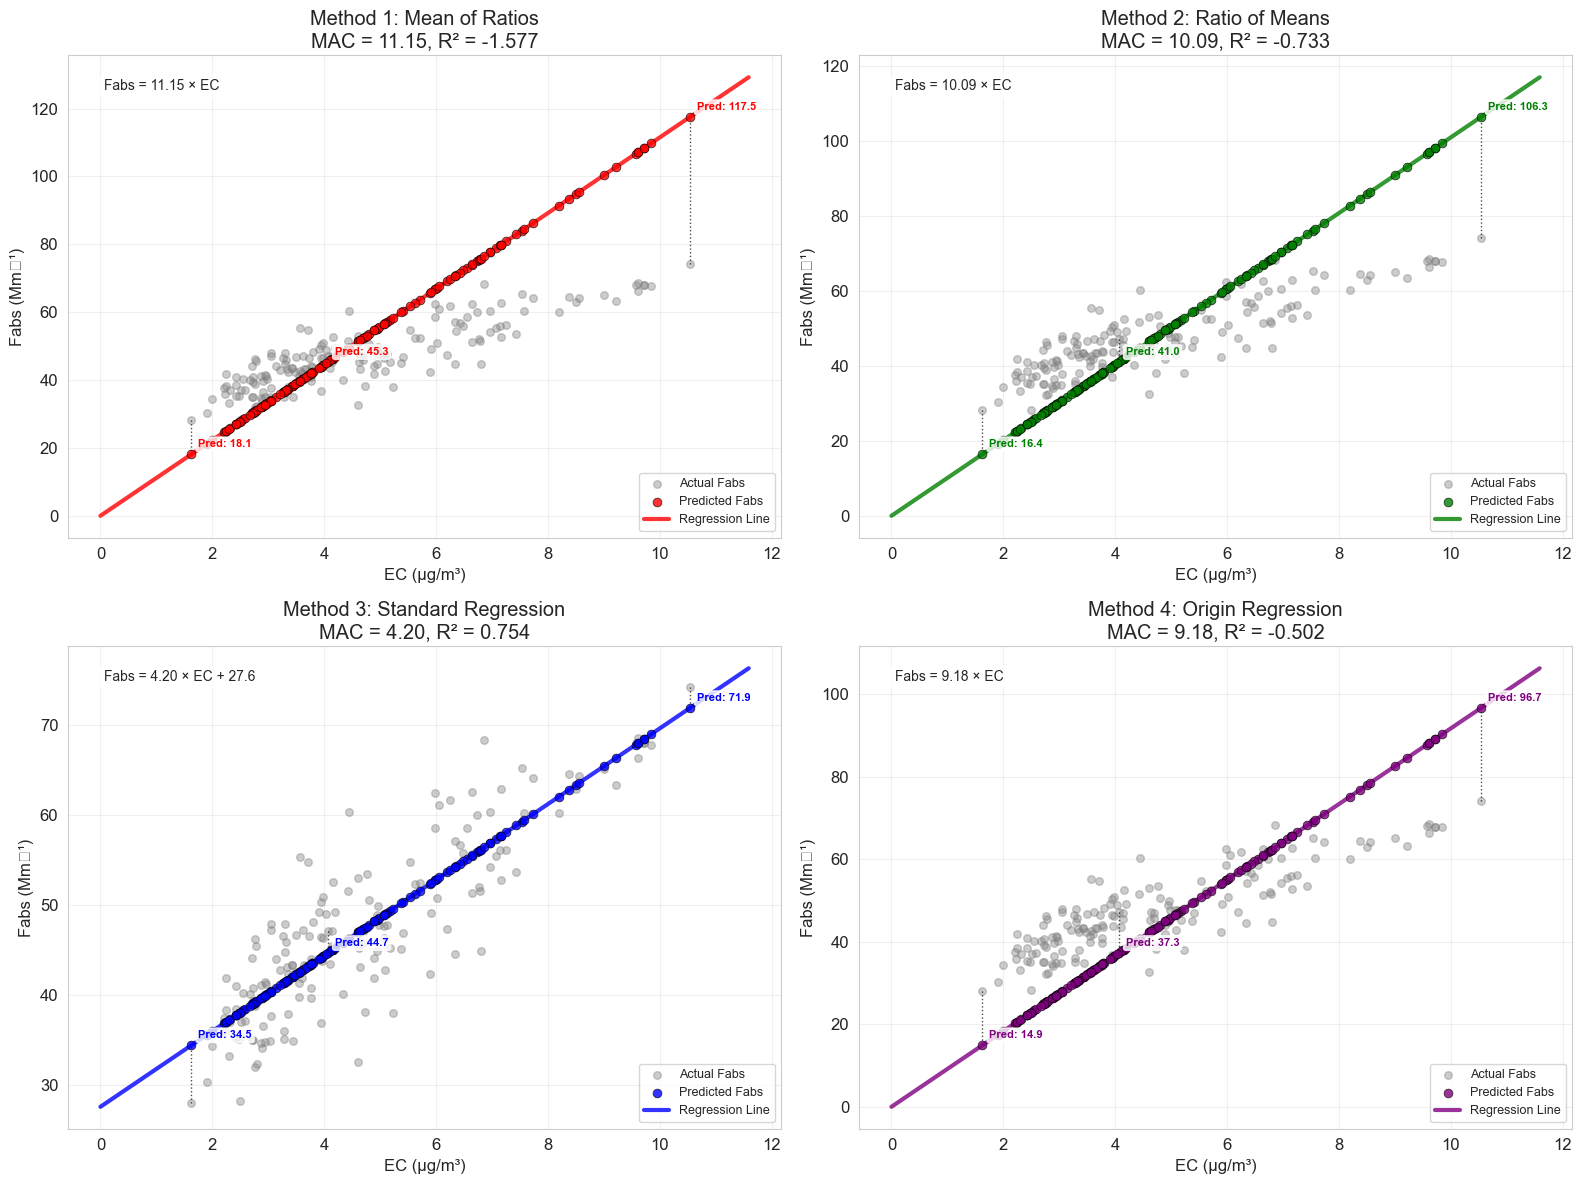


BC CALCULATION SOLUTIONS - HANDLING THE INTERCEPT PROBLEM
🔍 THE INTERCEPT ISSUE:
Method 3 (best regression): Fabs = 4.20 × EC + 27.6
Problem: When EC = 0, Fabs = 27.6 Mm⁻¹ (not zero!)
This 27.6 Mm⁻¹ represents non-BC absorption (brown carbon, dust, etc.)

💡 SOLUTION OPTIONS FOR BC EQUIVALENT CALCULATIONS:

1️⃣ SOLUTION 1: Baseline-Corrected Method 3
   Formula: BC = (Fabs - 27.6) / 4.20
   Logic: Subtract non-BC absorption, then apply MAC
   Performance vs FTIR EC:
     BC mean: 4.69 μg/m³
     Bias: 0.00 μg/m³
     RMSE: 1.15 μg/m³
     Correlation: r = 0.868

2️⃣ SOLUTION 2: Use Method 2 (Ratio of Means)
   Formula: BC = Fabs / 10.09
   Logic: No intercept, physically meaningful zero point
   Performance vs FTIR EC:
     BC mean: 4.69 μg/m³
     Bias: 0.00 μg/m³
     RMSE: 1.27 μg/m³
     Correlation: r = 0.868

3️⃣ SOLUTION 3: Hybrid Approach
   Use Method 3 MAC but apply threshold
   Formula: BC = max(0, (Fabs - threshold) / 4.20)
   50% baseline (13.8 Mm⁻¹): Bias = 3.29, RMSE = 3

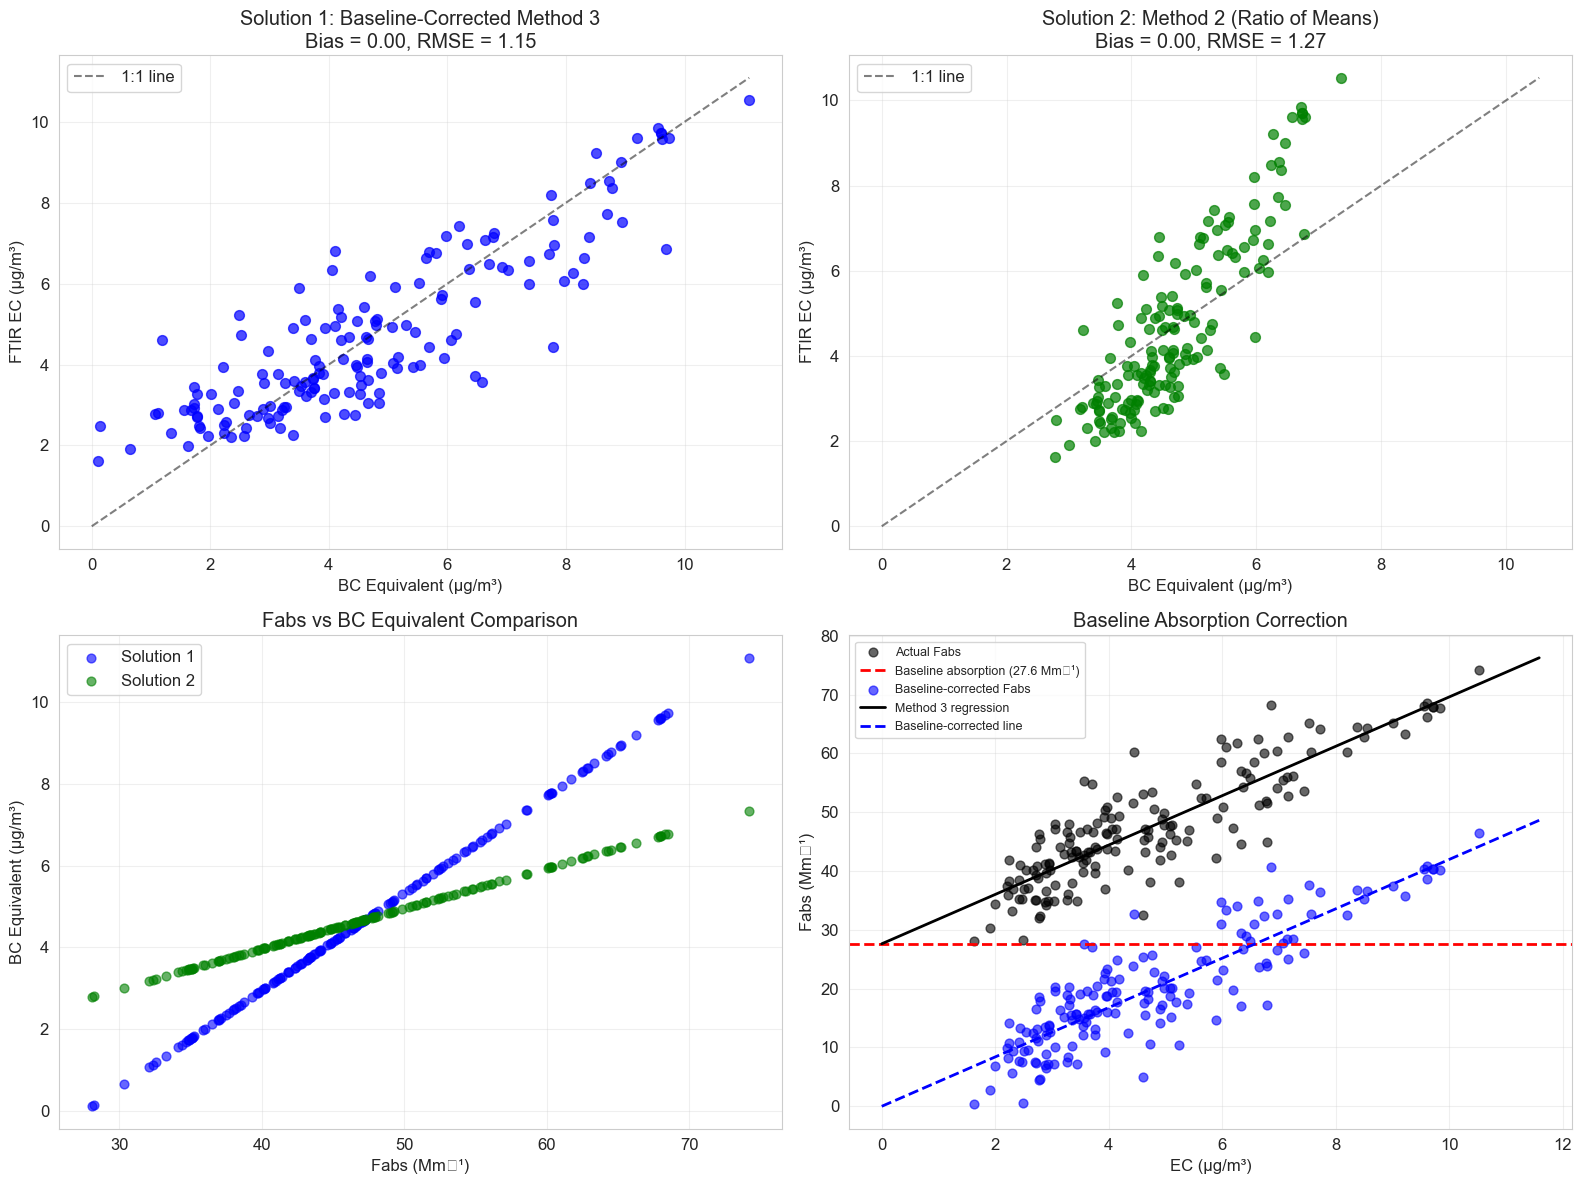


RECOMMENDATIONS FOR BC EQUIVALENT CALCULATIONS
🏆 RANKING BY PERFORMANCE:
1. Solution 1 (Baseline-corrected)
   Bias: 0.00 μg/m³, RMSE: 1.15 μg/m³, r: 0.868
   ✅ RECOMMENDED APPROACH

2. Solution 2 (Method 2)
   Bias: 0.00 μg/m³, RMSE: 1.27 μg/m³, r: 0.868

📝 PRACTICAL IMPLEMENTATION:
For HIPS measurements, use:
  BC = max(0, (Fabs - 27.6) / 4.20)
  This accounts for 27.6 Mm⁻¹ baseline absorption
Function defined successfully!
To run the analysis, use:
enhanced_results = enhanced_mac_visualization_with_predictions(your_dataframe, 'your_site_code')

Where:
- your_dataframe should contain 'ec_ftir' and 'fabs' columns
- your_site_code is a string identifier for your site


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd

def enhanced_mac_visualization_with_predictions(df, site_code):
    """
    Enhanced visualization showing predicted values on regression lines
    and addressing the intercept issue for BC calculations
    """
    
    print(f"\n{'='*80}")
    print(f"ENHANCED MAC ANALYSIS WITH BC CALCULATION SOLUTIONS - {site_code}")
    print(f"{'='*80}")
    
    # Original data - moved before data summary
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    
    # Data summary
    print(f"Data: {len(df)} samples")
    print(f"EC range: {ec_original.min():.1f}-{ec_original.max():.1f} μg/m³")
    print(f"Fabs range: {fabs_original.min():.1f}-{fabs_original.max():.1f} Mm⁻¹")
    
    # Calculate MAC values for each method
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    
    # Generate predictions
    fabs_pred_method1 = mac_method1 * ec_original
    fabs_pred_method2 = mac_method2 * ec_original
    fabs_pred_method3 = mac_method3 * ec_original + intercept_method3
    fabs_pred_method4 = mac_method4 * ec_original
    
    methods_data = [
        ("Method 1: Mean of Ratios", mac_method1, 0, fabs_pred_method1, 'red'),
        ("Method 2: Ratio of Means", mac_method2, 0, fabs_pred_method2, 'green'),
        ("Method 3: Standard Regression", mac_method3, intercept_method3, fabs_pred_method3, 'blue'),
        ("Method 4: Origin Regression", mac_method4, 0, fabs_pred_method4, 'purple')
    ]
    
    # =============================================================================
    # Method Summary
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"MAC CALCULATION METHODS SUMMARY")
    print(f"{'='*80}")
    
    print(f"Method 1 MAC (Mean of Ratios): {mac_method1:.3f} m²/g")
    print(f"Method 2 MAC (Ratio of Means): {mac_method2:.3f} m²/g")
    print(f"Method 3 MAC (Regression): {mac_method3:.3f} m²/g, Intercept: {intercept_method3:.3f}")
    print(f"Method 4 MAC (Origin Regression): {mac_method4:.3f} m²/g")
    
    print(f"\n{'='*80}")
    print(f"GENERATING PREDICTIONS FROM EACH METHOD")
    print(f"{'='*80}")
    
    print(f"Method 1 predictions: Fabs = {mac_method1:.3f} × EC")
    print(f"Range: {fabs_pred_method1.min():.1f} to {fabs_pred_method1.max():.1f} Mm⁻¹")
    
    print(f"Method 2 predictions: Fabs = {mac_method2:.3f} × EC")
    print(f"Range: {fabs_pred_method2.min():.1f} to {fabs_pred_method2.max():.1f} Mm⁻¹")
    
    print(f"Method 3 predictions: Fabs = {mac_method3:.3f} × EC + {intercept_method3:.3f}")
    print(f"Range: {fabs_pred_method3.min():.1f} to {fabs_pred_method3.max():.1f} Mm⁻¹")
    
    print(f"Method 4 predictions: Fabs = {mac_method4:.3f} × EC")
    print(f"Range: {fabs_pred_method4.min():.1f} to {fabs_pred_method4.max():.1f} Mm⁻¹")
    
    # =============================================================================
    # Manual R² calculations
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"MANUAL R² CALCULATION FOR EACH METHOD")
    print(f"R² = [correlation(EC_original, Fabs_predicted)]²")
    print(f"{'='*80}")
    
    # Calculate correlations and R² for each method
    correlations = []
    r_squared_values = []
    p_values = []
    
    predictions_list = [fabs_pred_method1, fabs_pred_method2, fabs_pred_method3, fabs_pred_method4]
    method_names = ["Method 1: Mean of Individual Ratios", "Method 2: Ratio of Means", 
                   "Method 3: Standard Linear Regression", "Method 4: Origin Regression"]
    mac_values = [mac_method1, mac_method2, mac_method3, mac_method4]
    
    for i, (pred, name, mac) in enumerate(zip(predictions_list, method_names, mac_values)):
        r, p = pearsonr(ec_original, pred)
        r_squared = r**2
        correlations.append(r)
        r_squared_values.append(r_squared)
        p_values.append(p)
        
        print(f"\n📊 {name}")
        print(f"   Correlation(EC, Fabs_pred) = {r:.6f}")
        print(f"   R² = r² = {r_squared:.6f}")
        print(f"   p-value = {p:.2e}")
    
    # Reference comparison
    r_actual, p_actual = pearsonr(ec_original, fabs_original)
    r2_actual = r_actual**2
    
    print(f"\n🔍 REFERENCE COMPARISON:")
    print(f"   Actual correlation(EC, Fabs_original) = {r_actual:.6f}")
    print(f"   Actual R² = {r2_actual:.6f}")
    print(f"   This is the benchmark - how close do our methods get?")
    
    # Summary table
    print(f"\n{'='*100}")
    print(f"SUMMARY TABLE - MANUAL R² CALCULATION RESULTS")
    print(f"{'='*100}")
    print(f"{'Method':<30} {'MAC':<8} {'Correlation r':<12} {'R²':<10} {'Difference from Actual':<20}")
    print(f"{'='*100}")
    
    method_short_names = ["Method 1: Mean of Ratios", "Method 2: Ratio of Means", 
                         "Method 3: Standard Regression", "Method 4: Origin Regression"]
    
    for i in range(4):
        diff_from_actual = r_squared_values[i] - r2_actual
        print(f"{method_short_names[i]:<30} {mac_values[i]:<8.3f} {correlations[i]:<12.6f} {r_squared_values[i]:<10.6f} {diff_from_actual:<20.6f}")
    
    print(f"{'Actual (EC vs Fabs)':<30} {'N/A':<8} {r_actual:<12.6f} {r2_actual:<10.6f} {0.000000:<20.6f}")
    print(f"{'='*100}")
    
    # =============================================================================
    # Enhanced visualization with predicted values on lines
    # =============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for i, (method_name, mac, intercept, fabs_pred, color) in enumerate(methods_data):
        ax = axes[i//2, i%2]
        
        # Plot actual data
        ax.scatter(ec_original, fabs_original, alpha=0.4, s=30, color='gray', 
                  label='Actual Fabs', zorder=1)
        
        # Plot predicted points ON THE LINE
        ax.scatter(ec_original, fabs_pred, alpha=0.8, s=40, color=color, 
                  label='Predicted Fabs', zorder=3, edgecolors='black', linewidth=0.5)
        
        # Plot regression line
        ec_line = np.linspace(0, ec_original.max() * 1.1, 100)
        fabs_line = mac * ec_line + intercept
        ax.plot(ec_line, fabs_line, color=color, linewidth=3, alpha=0.8, 
                label=f'Regression Line', zorder=2)
        
        # Highlight a few specific predictions with annotations
        # Choose 3 representative points: low, medium, high EC
        indices = [np.argmin(ec_original), 
                  np.argmin(np.abs(ec_original - np.median(ec_original))),
                  np.argmax(ec_original)]
        
        for idx in indices:
            ec_val = ec_original[idx]
            fabs_actual = fabs_original[idx]
            fabs_predicted = fabs_pred[idx]
            
            # Draw line from actual to predicted
            ax.plot([ec_val, ec_val], [fabs_actual, fabs_predicted], 
                   color='black', linestyle=':', alpha=0.7, linewidth=1)
            
            # Annotate the predicted value
            ax.annotate(f'Pred: {fabs_predicted:.1f}', 
                       xy=(ec_val, fabs_predicted), 
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, color=color, weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        
        # Calculate regression R²
        ss_res = np.sum((fabs_original - fabs_pred)**2)
        ss_tot = np.sum((fabs_original - np.mean(fabs_original))**2)
        regression_r2 = 1 - (ss_res / ss_tot)
        
        ax.set_xlabel('EC (μg/m³)')
        ax.set_ylabel('Fabs (Mm⁻¹)')
        # Fixed title formatting - using proper line breaks
        ax.set_title(f'{method_name}\nMAC = {mac:.2f}, R² = {regression_r2:.3f}')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Add equation with intercept handling
        if intercept != 0:
            equation = f'Fabs = {mac:.2f} × EC + {intercept:.1f}'
        else:
            equation = f'Fabs = {mac:.2f} × EC'
        
        ax.text(0.05, 0.95, equation, transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # BC Calculation Solutions - Addressing the Intercept Problem
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"BC CALCULATION SOLUTIONS - HANDLING THE INTERCEPT PROBLEM")
    print(f"{'='*80}")
    
    print(f"🔍 THE INTERCEPT ISSUE:")
    print(f"Method 3 (best regression): Fabs = {mac_method3:.2f} × EC + {intercept_method3:.1f}")
    print(f"Problem: When EC = 0, Fabs = {intercept_method3:.1f} Mm⁻¹ (not zero!)")
    print(f"This {intercept_method3:.1f} Mm⁻¹ represents non-BC absorption (brown carbon, dust, etc.)")
    
    print(f"\n💡 SOLUTION OPTIONS FOR BC EQUIVALENT CALCULATIONS:")
    
    # =============================================================================
    # Solution 1: Baseline-Corrected Method 3
    # =============================================================================
    
    print(f"\n1️⃣ SOLUTION 1: Baseline-Corrected Method 3")
    print(f"   Formula: BC = (Fabs - {intercept_method3:.1f}) / {mac_method3:.2f}")
    print(f"   Logic: Subtract non-BC absorption, then apply MAC")
    
    # Calculate baseline-corrected BC
    fabs_corrected = np.maximum(fabs_original - intercept_method3, 0)  # Don't go negative
    bc_corrected = fabs_corrected / mac_method3
    
    # Performance vs FTIR EC
    bias_corrected = np.mean(bc_corrected - ec_original)
    rmse_corrected = np.sqrt(np.mean((bc_corrected - ec_original)**2))
    r_corrected, _ = pearsonr(bc_corrected, ec_original)
    
    print(f"   Performance vs FTIR EC:")
    print(f"     BC mean: {bc_corrected.mean():.2f} μg/m³")
    print(f"     Bias: {bias_corrected:.2f} μg/m³")
    print(f"     RMSE: {rmse_corrected:.2f} μg/m³")
    print(f"     Correlation: r = {r_corrected:.3f}")
    
    # =============================================================================
    # Solution 2: Use Method 2 (Ratio of Means) - No Intercept Issue
    # =============================================================================
    
    print(f"\n2️⃣ SOLUTION 2: Use Method 2 (Ratio of Means)")
    print(f"   Formula: BC = Fabs / {mac_method2:.2f}")
    print(f"   Logic: No intercept, physically meaningful zero point")
    
    bc_method2 = fabs_original / mac_method2
    bias_method2 = np.mean(bc_method2 - ec_original)
    rmse_method2 = np.sqrt(np.mean((bc_method2 - ec_original)**2))
    r_method2, _ = pearsonr(bc_method2, ec_original)
    
    print(f"   Performance vs FTIR EC:")
    print(f"     BC mean: {bc_method2.mean():.2f} μg/m³")
    print(f"     Bias: {bias_method2:.2f} μg/m³")
    print(f"     RMSE: {rmse_method2:.2f} μg/m³")
    print(f"     Correlation: r = {r_method2:.3f}")
    
    # =============================================================================
    # Solution 3: Hybrid Approach
    # =============================================================================
    
    print(f"\n3️⃣ SOLUTION 3: Hybrid Approach")
    print(f"   Use Method 3 MAC but apply threshold")
    print(f"   Formula: BC = max(0, (Fabs - threshold) / {mac_method3:.2f})")
    
    # Try different thresholds
    thresholds = [intercept_method3 * 0.5, intercept_method3 * 0.75, intercept_method3]
    threshold_names = ["50% baseline", "75% baseline", "Full baseline"]
    
    for threshold, name in zip(thresholds, threshold_names):
        fabs_adj = np.maximum(fabs_original - threshold, 0)
        bc_hybrid = fabs_adj / mac_method3
        bias_hybrid = np.mean(bc_hybrid - ec_original)
        rmse_hybrid = np.sqrt(np.mean((bc_hybrid - ec_original)**2))
        
        print(f"   {name} ({threshold:.1f} Mm⁻¹): Bias = {bias_hybrid:.2f}, RMSE = {rmse_hybrid:.2f}")
    
    # =============================================================================
    # Comparison visualization
    # =============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Solution 1: Baseline-corrected Method 3
    ax1 = axes[0, 0]
    ax1.scatter(bc_corrected, ec_original, alpha=0.7, s=50, color='blue')
    ax1.plot([0, max(bc_corrected.max(), ec_original.max())], [0, max(bc_corrected.max(), ec_original.max())], 
             'k--', alpha=0.5, label='1:1 line')
    ax1.set_xlabel('BC Equivalent (μg/m³)')
    ax1.set_ylabel('FTIR EC (μg/m³)')
    # Fixed title formatting
    ax1.set_title(f'Solution 1: Baseline-Corrected Method 3\nBias = {bias_corrected:.2f}, RMSE = {rmse_corrected:.2f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Solution 2: Method 2
    ax2 = axes[0, 1]
    ax2.scatter(bc_method2, ec_original, alpha=0.7, s=50, color='green')
    ax2.plot([0, max(bc_method2.max(), ec_original.max())], [0, max(bc_method2.max(), ec_original.max())], 
             'k--', alpha=0.5, label='1:1 line')
    ax2.set_xlabel('BC Equivalent (μg/m³)')
    ax2.set_ylabel('FTIR EC (μg/m³)')
    # Fixed title formatting
    ax2.set_title(f'Solution 2: Method 2 (Ratio of Means)\nBias = {bias_method2:.2f}, RMSE = {rmse_method2:.2f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Fabs vs BC comparison
    ax3 = axes[1, 0]
    ax3.scatter(fabs_original, bc_corrected, alpha=0.6, s=40, color='blue', label='Solution 1')
    ax3.scatter(fabs_original, bc_method2, alpha=0.6, s=40, color='green', label='Solution 2')
    ax3.set_xlabel('Fabs (Mm⁻¹)')
    ax3.set_ylabel('BC Equivalent (μg/m³)')
    ax3.set_title('Fabs vs BC Equivalent Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Baseline absorption demonstration
    ax4 = axes[1, 1]
    ax4.scatter(ec_original, fabs_original, alpha=0.6, s=40, color='black', label='Actual Fabs')
    ax4.axhline(intercept_method3, color='red', linestyle='--', linewidth=2, 
                label=f'Baseline absorption ({intercept_method3:.1f} Mm⁻¹)')
    ax4.scatter(ec_original, fabs_corrected, alpha=0.6, s=40, color='blue', 
                label='Baseline-corrected Fabs')
    
    ec_line = np.linspace(0, ec_original.max() * 1.1, 100)
    ax4.plot(ec_line, mac_method3 * ec_line + intercept_method3, 'black', linewidth=2, 
             label='Method 3 regression')
    ax4.plot(ec_line, mac_method3 * ec_line, 'blue', linewidth=2, linestyle='--',
             label='Baseline-corrected line')
    
    ax4.set_xlabel('EC (μg/m³)')
    ax4.set_ylabel('Fabs (Mm⁻¹)')
    ax4.set_title('Baseline Absorption Correction')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # Recommendations
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"RECOMMENDATIONS FOR BC EQUIVALENT CALCULATIONS")
    print(f"{'='*80}")
    
    solutions = [
        ("Solution 1 (Baseline-corrected)", bias_corrected, rmse_corrected, r_corrected),
        ("Solution 2 (Method 2)", bias_method2, rmse_method2, r_method2)
    ]
    
    # Rank by performance
    solutions.sort(key=lambda x: abs(x[1]) + x[2])  # Sort by |bias| + RMSE
    
    print(f"🏆 RANKING BY PERFORMANCE:")
    for i, (name, bias, rmse, r) in enumerate(solutions, 1):
        print(f"{i}. {name}")
        print(f"   Bias: {bias:.2f} μg/m³, RMSE: {rmse:.2f} μg/m³, r: {r:.3f}")
        if i == 1:
            print(f"   ✅ RECOMMENDED APPROACH")
        print()
    
    print(f"📝 PRACTICAL IMPLEMENTATION:")
    best_solution = solutions[0][0]
    if "Solution 1" in best_solution:
        print(f"For HIPS measurements, use:")
        print(f"  BC = max(0, (Fabs - {intercept_method3:.1f}) / {mac_method3:.2f})")
        print(f"  This accounts for {intercept_method3:.1f} Mm⁻¹ baseline absorption")
    else:
        print(f"For HIPS measurements, use:")
        print(f"  BC = Fabs / {mac_method2:.2f}")
        print(f"  This avoids the intercept issue entirely")
    
    return {
        'methods_data': methods_data,
        'bc_corrected': bc_corrected,
        'bc_method2': bc_method2,
        'best_solution': solutions[0],
        'intercept': intercept_method3
    }

# Run the enhanced analysis
# Comment out the automatic execution - user should call the function manually
# with their specific data variable and site code

# Example usage:
enhanced_results = enhanced_mac_visualization_with_predictions(data_processed, 'YOUR_SITE_CODE')

print("Function defined successfully!")
print("To run the analysis, use:")
print("enhanced_results = enhanced_mac_visualization_with_predictions(your_dataframe, 'your_site_code')")
print("\nWhere:")
print("- your_dataframe should contain 'ec_ftir' and 'fabs' columns")
print("- your_site_code is a string identifier for your site")


VARIANCE AND BIAS ANALYSIS FOR MAC METHODS - YOUR_SITE_CODE

BIAS ANALYSIS

📊 FABS PREDICTION BIAS:
Method                    Mean Bias    Median Bias  Bias Range     
-----------------------------------------------------------------
Method 1: Mean of Ratios  4.96         -0.24        -16.8 to 43.3  
Method 2: Ratio of Means  -0.00        -3.71        -19.3 to 32.1  
Method 3: Standard Regression -0.00        -0.14        -14.0 to 14.4  
Method 4: Origin Regression -4.29        -7.09        -22.6 to 22.5  

📊 BC EQUIVALENT vs FTIR EC BIAS:
Method                    Mean Bias    Median Bias  Bias Range     
-----------------------------------------------------------------
Method 1: Mean of Ratios  -0.45        0.02         -3.9 to 1.5    
Method 2: Ratio of Means  0.00         0.37         -3.2 to 1.9    
Method 3: Standard Regression 0.00         0.03         -3.4 to 3.3    
Method 4: Origin Regression 0.47         0.77         -2.5 to 2.5    

VARIANCE ANALYSIS

📈 FABS PREDICTION VAR

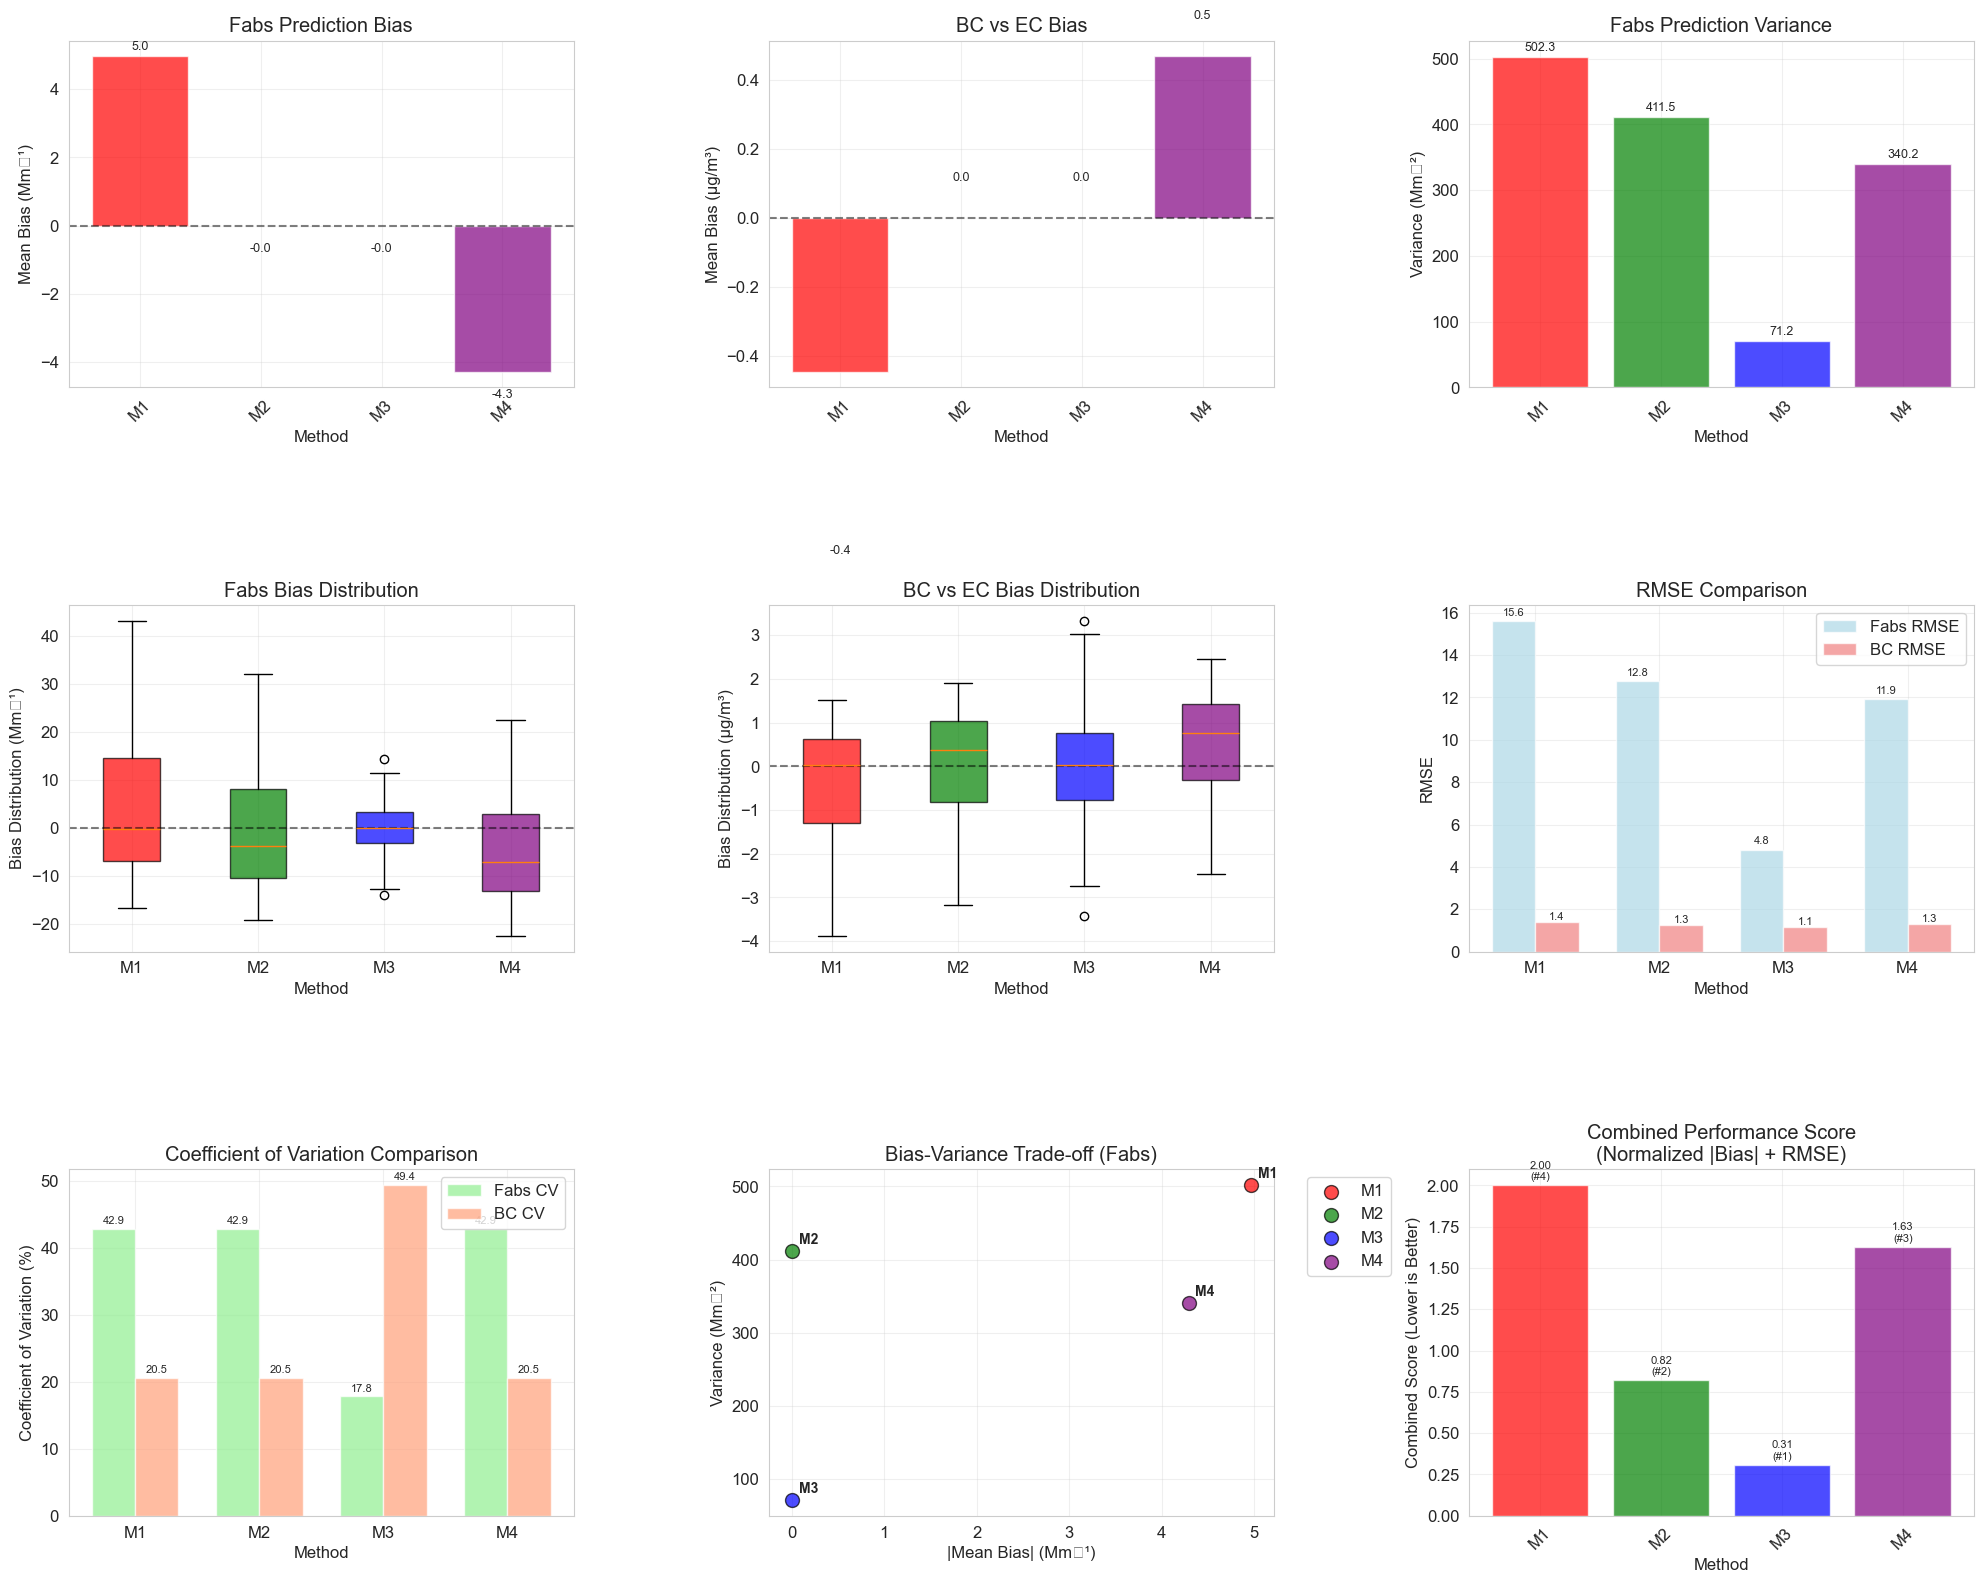


PERFORMANCE RANKINGS SUMMARY

🏆 RANKING BY FABS BIAS:
  1. M3: Method 3: Standard Regression = 0.000
  2. M2: Method 2: Ratio of Means = 0.000
  3. M4: Method 4: Origin Regression = 4.290
  4. M1: Method 1: Mean of Ratios = 4.965

🏆 RANKING BY BC BIAS:
  1. M2: Method 2: Ratio of Means = 0.000
  2. M3: Method 3: Standard Regression = 0.000
  3. M1: Method 1: Mean of Ratios = 0.445
  4. M4: Method 4: Origin Regression = 0.468

🏆 RANKING BY FABS RMSE:
  1. M3: Method 3: Standard Regression = 4.816
  2. M4: Method 4: Origin Regression = 11.906
  3. M2: Method 2: Ratio of Means = 12.789
  4. M1: Method 1: Mean of Ratios = 15.594

🏆 RANKING BY BC RMSE:
  1. M3: Method 3: Standard Regression = 1.147
  2. M2: Method 2: Ratio of Means = 1.267
  3. M4: Method 4: Origin Regression = 1.297
  4. M1: Method 1: Mean of Ratios = 1.398

OVERALL RECOMMENDATIONS

🎯 OVERALL PERFORMANCE RANKING (BC vs EC):
  1. M3: Method 3: Standard Regression
     Overall Score: 0.820 (lower is better)
     Bias: 0.00 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd

def variance_bias_analysis(df, site_code):
    """
    Comprehensive variance and bias analysis for all MAC calculation methods
    """
    
    print(f"\n{'='*80}")
    print(f"VARIANCE AND BIAS ANALYSIS FOR MAC METHODS - {site_code}")
    print(f"{'='*80}")
    
    # Extract data
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    n_samples = len(ec_original)
    
    # Calculate MAC values for each method
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    
    # Generate predictions for each method
    fabs_pred_method1 = mac_method1 * ec_original
    fabs_pred_method2 = mac_method2 * ec_original
    fabs_pred_method3 = mac_method3 * ec_original + intercept_method3
    fabs_pred_method4 = mac_method4 * ec_original
    
    # Calculate BC equivalent concentrations
    bc_method1 = fabs_original / mac_method1
    bc_method2 = fabs_original / mac_method2
    bc_method3_corrected = np.maximum(fabs_original - intercept_method3, 0) / mac_method3
    bc_method4 = fabs_original / mac_method4
    
    # Store all methods data
    methods_data = {
        'Method 1: Mean of Ratios': {
            'mac': mac_method1,
            'intercept': 0,
            'fabs_pred': fabs_pred_method1,
            'bc_pred': bc_method1,
            'color': 'red'
        },
        'Method 2: Ratio of Means': {
            'mac': mac_method2,
            'intercept': 0,
            'fabs_pred': fabs_pred_method2,
            'bc_pred': bc_method2,
            'color': 'green'
        },
        'Method 3: Standard Regression': {
            'mac': mac_method3,
            'intercept': intercept_method3,
            'fabs_pred': fabs_pred_method3,
            'bc_pred': bc_method3_corrected,
            'color': 'blue'
        },
        'Method 4: Origin Regression': {
            'mac': mac_method4,
            'intercept': 0,
            'fabs_pred': fabs_pred_method4,
            'bc_pred': bc_method4,
            'color': 'purple'
        }
    }
    
    # =============================================================================
    # BIAS ANALYSIS
    # =============================================================================
    
    print(f"\n{'='*60}")
    print(f"BIAS ANALYSIS")
    print(f"{'='*60}")
    
    bias_results = {}
    
    # For Fabs predictions
    print(f"\n📊 FABS PREDICTION BIAS:")
    print(f"{'Method':<25} {'Mean Bias':<12} {'Median Bias':<12} {'Bias Range':<15}")
    print(f"{'-'*65}")
    
    for method_name, data in methods_data.items():
        fabs_bias = data['fabs_pred'] - fabs_original
        mean_bias = np.mean(fabs_bias)
        median_bias = np.median(fabs_bias)
        bias_range = f"{np.min(fabs_bias):.1f} to {np.max(fabs_bias):.1f}"
        
        bias_results[method_name] = {
            'fabs_bias': fabs_bias,
            'fabs_mean_bias': mean_bias,
            'fabs_median_bias': median_bias
        }
        
        print(f"{method_name:<25} {mean_bias:<12.2f} {median_bias:<12.2f} {bias_range:<15}")
    
    # For BC predictions vs FTIR EC
    print(f"\n📊 BC EQUIVALENT vs FTIR EC BIAS:")
    print(f"{'Method':<25} {'Mean Bias':<12} {'Median Bias':<12} {'Bias Range':<15}")
    print(f"{'-'*65}")
    
    for method_name, data in methods_data.items():
        bc_bias = data['bc_pred'] - ec_original
        mean_bias = np.mean(bc_bias)
        median_bias = np.median(bc_bias)
        bias_range = f"{np.min(bc_bias):.1f} to {np.max(bc_bias):.1f}"
        
        bias_results[method_name]['bc_bias'] = bc_bias
        bias_results[method_name]['bc_mean_bias'] = mean_bias
        bias_results[method_name]['bc_median_bias'] = median_bias
        
        print(f"{method_name:<25} {mean_bias:<12.2f} {median_bias:<12.2f} {bias_range:<15}")
    
    # =============================================================================
    # VARIANCE ANALYSIS
    # =============================================================================
    
    print(f"\n{'='*60}")
    print(f"VARIANCE ANALYSIS")
    print(f"{'='*60}")
    
    variance_results = {}
    
    # For Fabs predictions
    print(f"\n📈 FABS PREDICTION VARIANCE:")
    print(f"{'Method':<25} {'Variance':<12} {'Std Dev':<12} {'CV (%)':<10}")
    print(f"{'-'*60}")
    
    for method_name, data in methods_data.items():
        fabs_var = np.var(data['fabs_pred'])
        fabs_std = np.std(data['fabs_pred'])
        fabs_cv = (fabs_std / np.mean(data['fabs_pred'])) * 100
        
        variance_results[method_name] = {
            'fabs_variance': fabs_var,
            'fabs_std': fabs_std,
            'fabs_cv': fabs_cv
        }
        
        print(f"{method_name:<25} {fabs_var:<12.2f} {fabs_std:<12.2f} {fabs_cv:<10.1f}")
    
    # For BC predictions
    print(f"\n📈 BC EQUIVALENT VARIANCE:")
    print(f"{'Method':<25} {'Variance':<12} {'Std Dev':<12} {'CV (%)':<10}")
    print(f"{'-'*60}")
    
    for method_name, data in methods_data.items():
        bc_var = np.var(data['bc_pred'])
        bc_std = np.std(data['bc_pred'])
        bc_cv = (bc_std / np.mean(data['bc_pred'])) * 100 if np.mean(data['bc_pred']) > 0 else 0
        
        variance_results[method_name]['bc_variance'] = bc_var
        variance_results[method_name]['bc_std'] = bc_std
        variance_results[method_name]['bc_cv'] = bc_cv
        
        print(f"{method_name:<25} {bc_var:<12.2f} {bc_std:<12.2f} {bc_cv:<10.1f}")
    
    # =============================================================================
    # ERROR VARIANCE ANALYSIS
    # =============================================================================
    
    print(f"\n{'='*60}")
    print(f"ERROR VARIANCE ANALYSIS")
    print(f"{'='*60}")
    
    # Residual variance for Fabs predictions
    print(f"\n🎯 FABS PREDICTION ERROR VARIANCE:")
    print(f"{'Method':<25} {'MSE':<12} {'RMSE':<12} {'MAE':<12}")
    print(f"{'-'*60}")
    
    for method_name, data in methods_data.items():
        residuals = data['fabs_pred'] - fabs_original
        mse = np.mean(residuals**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(residuals))
        
        variance_results[method_name]['fabs_mse'] = mse
        variance_results[method_name]['fabs_rmse'] = rmse
        variance_results[method_name]['fabs_mae'] = mae
        
        print(f"{method_name:<25} {mse:<12.2f} {rmse:<12.2f} {mae:<12.2f}")
    
    # Residual variance for BC vs EC
    print(f"\n🎯 BC vs EC ERROR VARIANCE:")
    print(f"{'Method':<25} {'MSE':<12} {'RMSE':<12} {'MAE':<12}")
    print(f"{'-'*60}")
    
    for method_name, data in methods_data.items():
        residuals = data['bc_pred'] - ec_original
        mse = np.mean(residuals**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(residuals))
        
        variance_results[method_name]['bc_mse'] = mse
        variance_results[method_name]['bc_rmse'] = rmse
        variance_results[method_name]['bc_mae'] = mae
        
        print(f"{method_name:<25} {mse:<12.2f} {rmse:<12.2f} {mae:<12.2f}")
    
    # =============================================================================
    # VISUALIZATION
    # =============================================================================
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Bias Comparison - Fabs Predictions
    ax1 = plt.subplot(3, 3, 1)
    method_names = list(methods_data.keys())
    fabs_biases = [bias_results[method]['fabs_mean_bias'] for method in method_names]
    colors = [methods_data[method]['color'] for method in method_names]
    
    bars1 = ax1.bar(range(len(method_names)), fabs_biases, color=colors, alpha=0.7)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Method')
    ax1.set_ylabel('Mean Bias (Mm⁻¹)')
    ax1.set_title('Fabs Prediction Bias')
    ax1.set_xticks(range(len(method_names)))
    ax1.set_xticklabels([f"M{i+1}" for i in range(len(method_names))], rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1 if height >= 0 else height - 0.5,
                f'{height:.1f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)
    
    # 2. Bias Comparison - BC vs EC
    ax2 = plt.subplot(3, 3, 2)
    bc_biases = [bias_results[method]['bc_mean_bias'] for method in method_names]
    
    bars2 = ax2.bar(range(len(method_names)), bc_biases, color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Method')
    ax2.set_ylabel('Mean Bias (μg/m³)')
    ax2.set_title('BC vs EC Bias')
    ax2.set_xticks(range(len(method_names)))
    ax2.set_xticklabels([f"M{i+1}" for i in range(len(method_names))], rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1 if height >= 0 else height - 0.5,
                f'{height:.1f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)
    
    # 3. Variance Comparison - Fabs
    ax3 = plt.subplot(3, 3, 3)
    fabs_vars = [variance_results[method]['fabs_variance'] for method in method_names]
    
    bars3 = ax3.bar(range(len(method_names)), fabs_vars, color=colors, alpha=0.7)
    ax3.set_xlabel('Method')
    ax3.set_ylabel('Variance (Mm⁻²)')
    ax3.set_title('Fabs Prediction Variance')
    ax3.set_xticks(range(len(method_names)))
    ax3.set_xticklabels([f"M{i+1}" for i in range(len(method_names))], rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + max(fabs_vars)*0.01,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Bias Distribution Box Plots - Fabs
    ax4 = plt.subplot(3, 3, 4)
    fabs_bias_data = [bias_results[method]['fabs_bias'] for method in method_names]
    bp1 = ax4.boxplot(fabs_bias_data, patch_artist=True, labels=[f"M{i+1}" for i in range(len(method_names))])
    
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Method')
    ax4.set_ylabel('Bias Distribution (Mm⁻¹)')
    ax4.set_title('Fabs Bias Distribution')
    ax4.grid(True, alpha=0.3)
    
    # 5. Bias Distribution Box Plots - BC vs EC
    ax5 = plt.subplot(3, 3, 5)
    bc_bias_data = [bias_results[method]['bc_bias'] for method in method_names]
    bp2 = ax5.boxplot(bc_bias_data, patch_artist=True, labels=[f"M{i+1}" for i in range(len(method_names))])
    
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax5.set_xlabel('Method')
    ax5.set_ylabel('Bias Distribution (μg/m³)')
    ax5.set_title('BC vs EC Bias Distribution')
    ax5.grid(True, alpha=0.3)
    
    # 6. RMSE Comparison
    ax6 = plt.subplot(3, 3, 6)
    fabs_rmse = [variance_results[method]['fabs_rmse'] for method in method_names]
    bc_rmse = [variance_results[method]['bc_rmse'] for method in method_names]
    
    x = np.arange(len(method_names))
    width = 0.35
    
    bars_fabs = ax6.bar(x - width/2, fabs_rmse, width, label='Fabs RMSE', alpha=0.7, color='lightblue')
    bars_bc = ax6.bar(x + width/2, bc_rmse, width, label='BC RMSE', alpha=0.7, color='lightcoral')
    
    ax6.set_xlabel('Method')
    ax6.set_ylabel('RMSE')
    ax6.set_title('RMSE Comparison')
    ax6.set_xticks(x)
    ax6.set_xticklabels([f"M{i+1}" for i in range(len(method_names))])
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars_fabs:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + max(fabs_rmse)*0.01,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    for bar in bars_bc:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + max(bc_rmse)*0.01,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    # 7. Coefficient of Variation Comparison
    ax7 = plt.subplot(3, 3, 7)
    fabs_cv = [variance_results[method]['fabs_cv'] for method in method_names]
    bc_cv = [variance_results[method]['bc_cv'] for method in method_names]
    
    bars_fabs_cv = ax7.bar(x - width/2, fabs_cv, width, label='Fabs CV', alpha=0.7, color='lightgreen')
    bars_bc_cv = ax7.bar(x + width/2, bc_cv, width, label='BC CV', alpha=0.7, color='lightsalmon')
    
    ax7.set_xlabel('Method')
    ax7.set_ylabel('Coefficient of Variation (%)')
    ax7.set_title('Coefficient of Variation Comparison')
    ax7.set_xticks(x)
    ax7.set_xticklabels([f"M{i+1}" for i in range(len(method_names))])
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars_fabs_cv:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + max(fabs_cv)*0.01,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    for bar in bars_bc_cv:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + max(bc_cv)*0.01,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    # 8. Bias vs Variance Trade-off
    ax8 = plt.subplot(3, 3, 8)
    
    for i, method in enumerate(method_names):
        fabs_bias = abs(bias_results[method]['fabs_mean_bias'])
        fabs_var = variance_results[method]['fabs_variance']
        color = methods_data[method]['color']
        
        ax8.scatter(fabs_bias, fabs_var, s=100, color=color, alpha=0.7, 
                   label=f"M{i+1}", edgecolors='black', linewidth=1)
        
        # Add method number annotation
        ax8.annotate(f"M{i+1}", (fabs_bias, fabs_var), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
    
    ax8.set_xlabel('|Mean Bias| (Mm⁻¹)')
    ax8.set_ylabel('Variance (Mm⁻²)')
    ax8.set_title('Bias-Variance Trade-off (Fabs)')
    ax8.grid(True, alpha=0.3)
    ax8.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 9. Combined Performance Score
    ax9 = plt.subplot(3, 3, 9)
    
    # Calculate combined score: normalized |bias| + normalized RMSE
    fabs_bias_norm = np.array([abs(bias_results[method]['fabs_mean_bias']) for method in method_names])
    fabs_rmse_norm = np.array([variance_results[method]['fabs_rmse'] for method in method_names])
    
    # Normalize to 0-1 scale
    fabs_bias_norm = fabs_bias_norm / np.max(fabs_bias_norm) if np.max(fabs_bias_norm) > 0 else fabs_bias_norm
    fabs_rmse_norm = fabs_rmse_norm / np.max(fabs_rmse_norm) if np.max(fabs_rmse_norm) > 0 else fabs_rmse_norm
    
    combined_score = fabs_bias_norm + fabs_rmse_norm
    
    bars_combined = ax9.bar(range(len(method_names)), combined_score, color=colors, alpha=0.7)
    ax9.set_xlabel('Method')
    ax9.set_ylabel('Combined Score (Lower is Better)')
    ax9.set_title('Combined Performance Score\n(Normalized |Bias| + RMSE)')
    ax9.set_xticks(range(len(method_names)))
    ax9.set_xticklabels([f"M{i+1}" for i in range(len(method_names))], rotation=45)
    ax9.grid(True, alpha=0.3)
    
    # Add value labels and ranking
    for i, (bar, score) in enumerate(zip(bars_combined, combined_score)):
        height = bar.get_height()
        rank = np.argsort(combined_score)[i] + 1
        ax9.text(bar.get_x() + bar.get_width()/2., height + max(combined_score)*0.01,
                f'{score:.2f}\n(#{sorted(enumerate(combined_score), key=lambda x: x[1]).index((i, score)) + 1})', 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # SUMMARY RANKINGS
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"PERFORMANCE RANKINGS SUMMARY")
    print(f"{'='*80}")
    
    # Rank methods by different criteria
    rankings = {}
    
    # By absolute bias (Fabs)
    fabs_abs_bias = [(method, abs(bias_results[method]['fabs_mean_bias'])) for method in method_names]
    fabs_abs_bias.sort(key=lambda x: x[1])
    rankings['Fabs Bias'] = fabs_abs_bias
    
    # By absolute bias (BC vs EC)
    bc_abs_bias = [(method, abs(bias_results[method]['bc_mean_bias'])) for method in method_names]
    bc_abs_bias.sort(key=lambda x: x[1])
    rankings['BC Bias'] = bc_abs_bias
    
    # By RMSE (Fabs)
    fabs_rmse_rank = [(method, variance_results[method]['fabs_rmse']) for method in method_names]
    fabs_rmse_rank.sort(key=lambda x: x[1])
    rankings['Fabs RMSE'] = fabs_rmse_rank
    
    # By RMSE (BC vs EC)
    bc_rmse_rank = [(method, variance_results[method]['bc_rmse']) for method in method_names]
    bc_rmse_rank.sort(key=lambda x: x[1])
    rankings['BC RMSE'] = bc_rmse_rank
    
    # Print rankings
    for criterion, ranking in rankings.items():
        print(f"\n🏆 RANKING BY {criterion.upper()}:")
        for i, (method, value) in enumerate(ranking, 1):
            method_short = f"M{method_names.index(method) + 1}"
            print(f"  {i}. {method_short}: {method} = {value:.3f}")
    
    # Overall recommendation
    print(f"\n{'='*80}")
    print(f"OVERALL RECOMMENDATIONS")
    print(f"{'='*80}")
    
    # Calculate overall scores for each method
    overall_scores = {}
    for method in method_names:
        # Weighted combination of normalized metrics
        bias_score = abs(bias_results[method]['bc_mean_bias']) / max([abs(bias_results[m]['bc_mean_bias']) for m in method_names])
        rmse_score = variance_results[method]['bc_rmse'] / max([variance_results[m]['bc_rmse'] for m in method_names])
        overall_scores[method] = bias_score + rmse_score
    
    # Sort by overall score
    overall_ranking = sorted(overall_scores.items(), key=lambda x: x[1])
    
    print(f"\n🎯 OVERALL PERFORMANCE RANKING (BC vs EC):")
    for i, (method, score) in enumerate(overall_ranking, 1):
        method_short = f"M{method_names.index(method) + 1}"
        print(f"  {i}. {method_short}: {method}")
        print(f"     Overall Score: {score:.3f} (lower is better)")
        print(f"     Bias: {bias_results[method]['bc_mean_bias']:.2f} μg/m³")
        print(f"     RMSE: {variance_results[method]['bc_rmse']:.2f} μg/m³")
        if i == 1:
            print(f"     ✅ RECOMMENDED METHOD")
        print()
    
    return {
        'bias_results': bias_results,
        'variance_results': variance_results,
        'methods_data': methods_data,
        'rankings': rankings,
        'overall_ranking': overall_ranking
    }

# Example usage:
results = variance_bias_analysis(data_processed, 'YOUR_SITE_CODE')

print("Variance and Bias Analysis function created successfully!")
print("\nTo run the analysis, use:")
print("results = variance_bias_analysis(your_dataframe, 'YOUR_SITE_CODE')")
print("\nThis function will:")
print("- Calculate bias and variance for all MAC methods")
print("- Create comprehensive visualization plots")
print("- Provide performance rankings")
print("- Give recommendations for best method")

Generating key variance and bias plots for ETAD...
🔍 Including physical constraint assessment (BC=0 when Fabs=0)

PHYSICAL CONSTRAINT ASSESSMENT
Method 1: Method 1: Mean of Ratios
  BC when Fabs=0: 0.000 μg/m³
  Physical Constraint: ✅ VALID
  MAC: 11.151 m²/g
  Intercept: 0.000 Mm⁻¹

Method 2: Method 2: Ratio of Means
  BC when Fabs=0: 0.000 μg/m³
  Physical Constraint: ✅ VALID
  MAC: 10.092 m²/g
  Intercept: 0.000 Mm⁻¹

Method 3: Method 3: Standard Regression
  BC when Fabs=0: -6.583 μg/m³
  Physical Constraint: ❌ INVALID
  MAC: 4.198 m²/g
  Intercept: 27.634 Mm⁻¹

Method 4: Method 4: Origin Regression
  BC when Fabs=0: 0.000 μg/m³
  Physical Constraint: ✅ VALID
  MAC: 9.177 m²/g
  Intercept: 0.000 Mm⁻¹

1. Generating BC vs EC Bias Distribution with constraint violations...
2. Generating RMSE Comparison with physical constraint assessment...
3. Generating Bias-Variance Trade-off with constraint violations...
4. Generating Performance Ranking with physical constraint penalty...
All plo

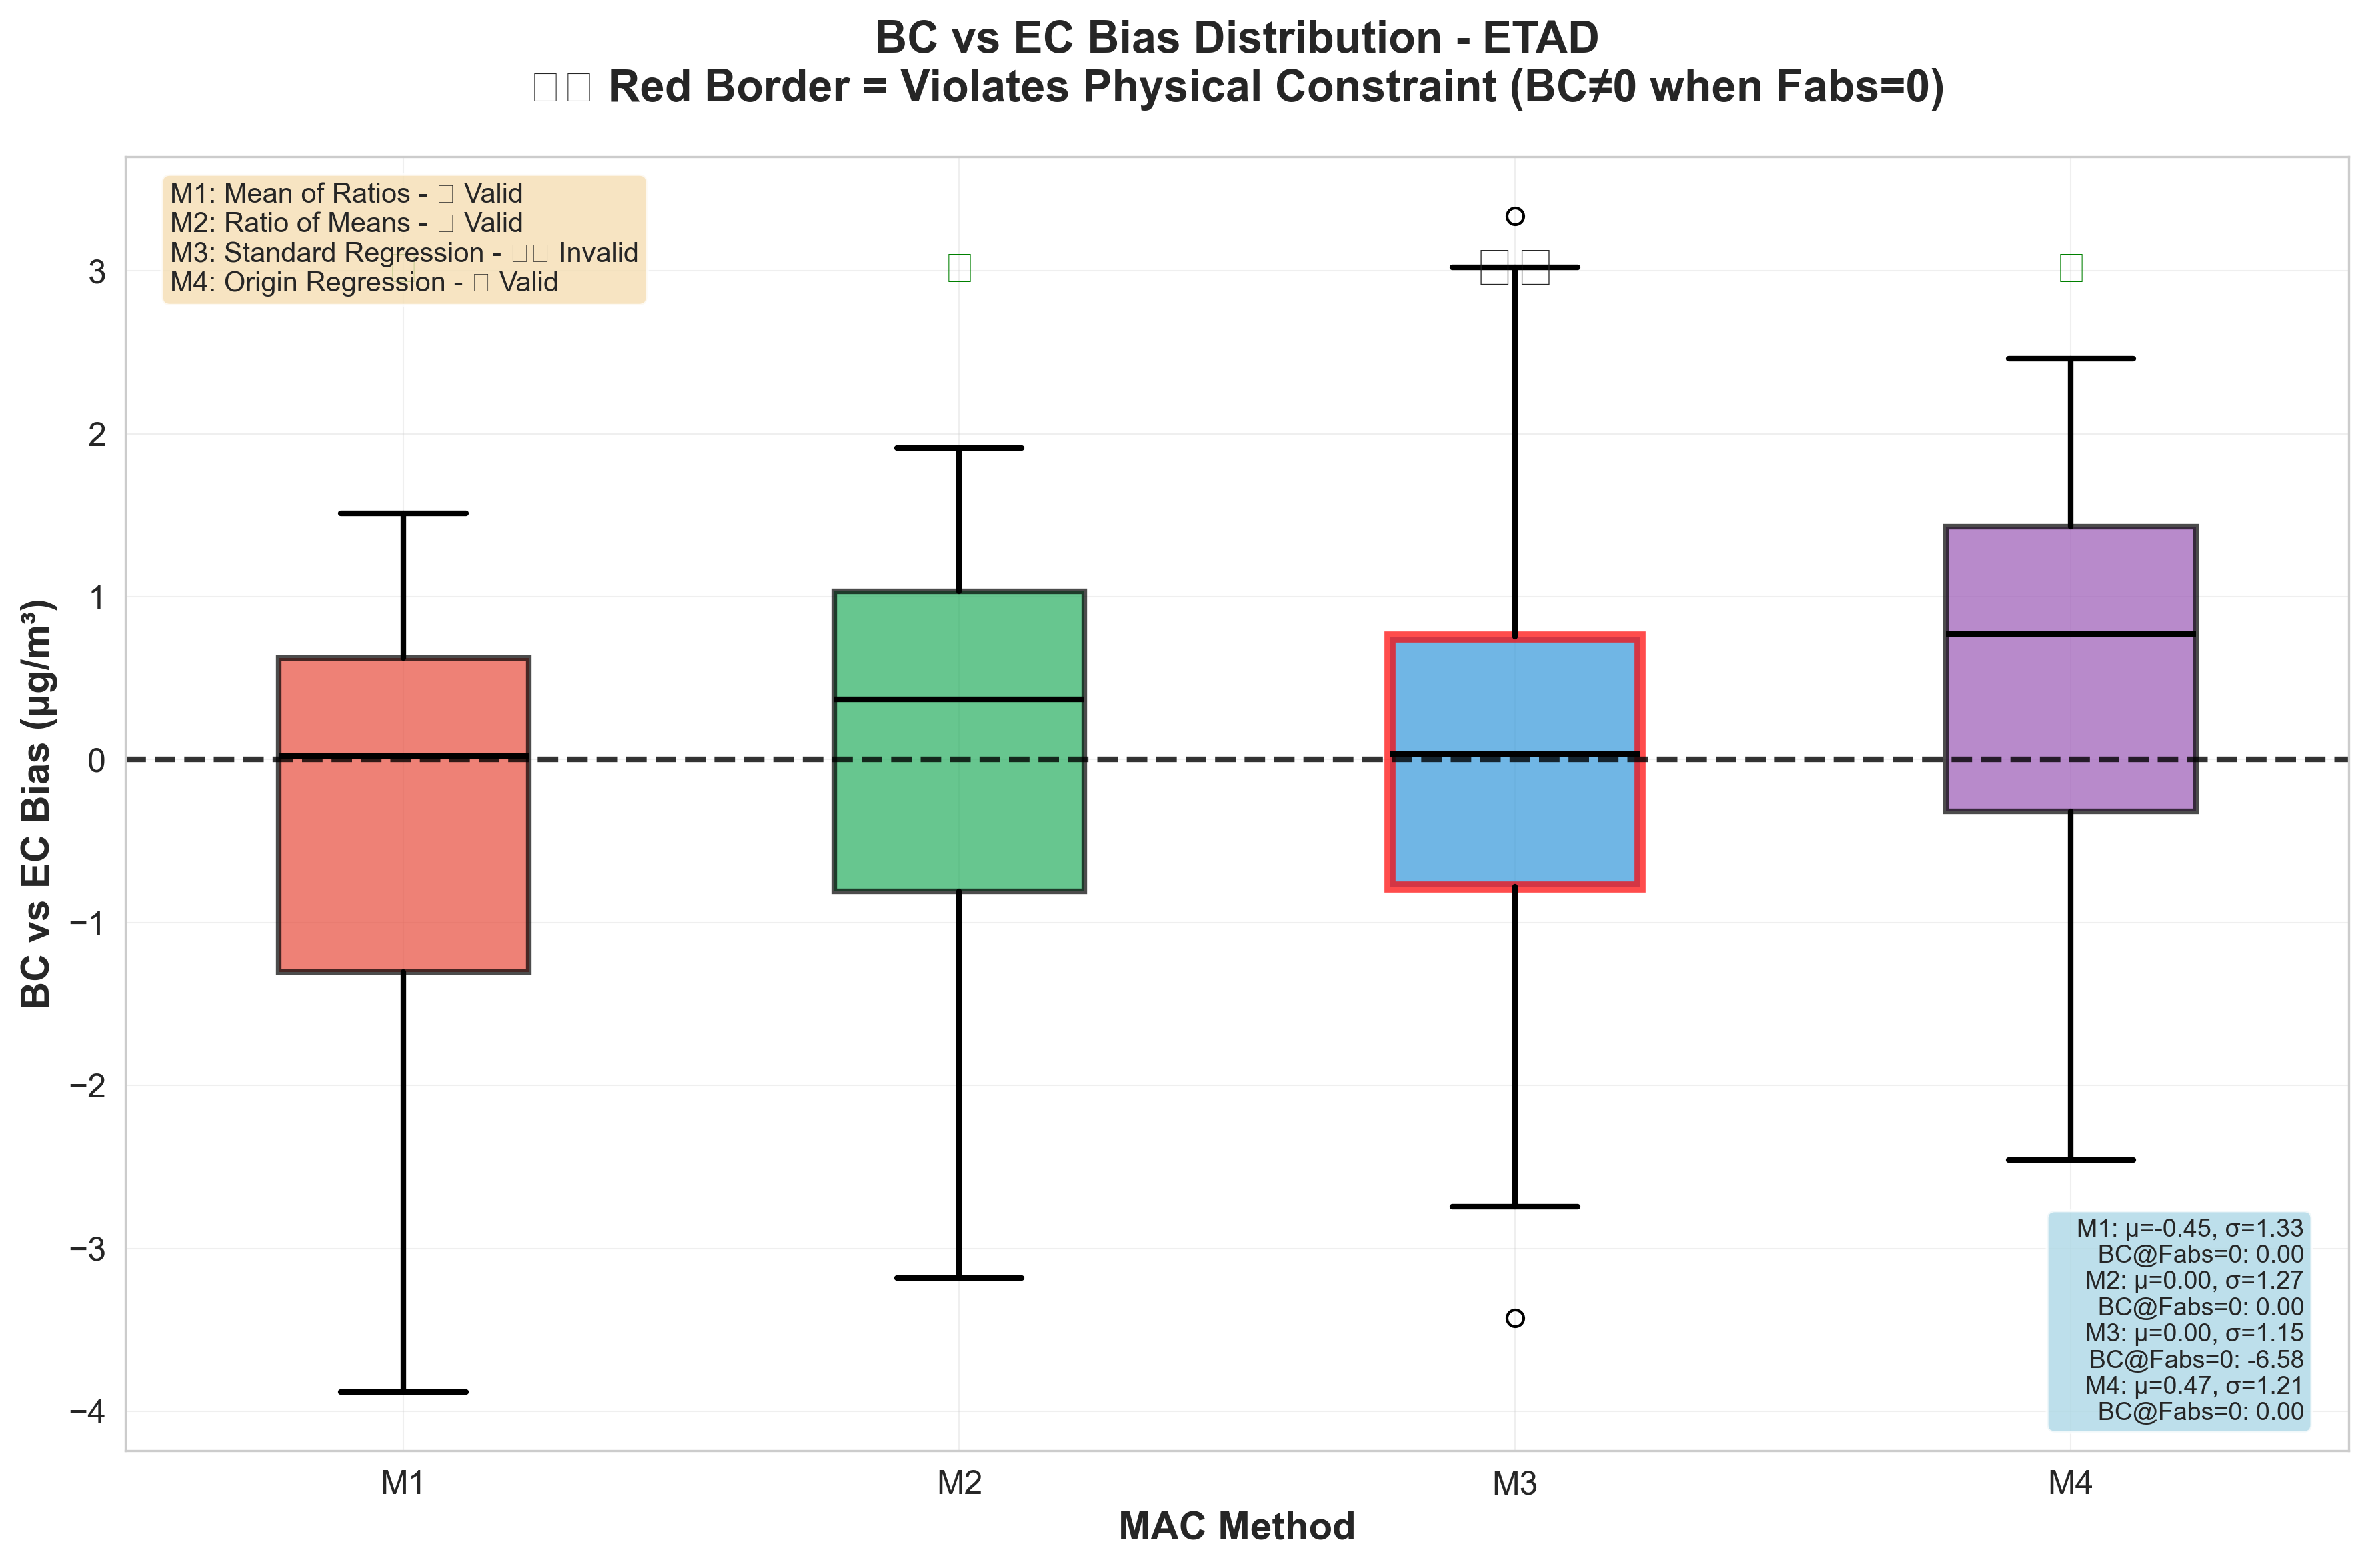

<Figure size 3000x1800 with 0 Axes>

<Figure size 3000x1800 with 0 Axes>

<Figure size 3000x1800 with 0 Axes>

Key variance and bias plotting functions are ready!

To generate plots, run:
plots = generate_key_plots(your_dataframe, 'your_site_code')

The four key plots are:
1. BC vs EC Bias Distribution - Most important for method selection
2. RMSE Comparison - Shows prediction accuracy
3. Bias-Variance Trade-off - Classic ML trade-off visualization
4. Combined Performance Ranking - Overall method ranking


In [15]:
# %% [markdown]
# # Key Variance and Bias Analysis Plots for MAC Methods
# 
# This section generates the most informative individual plots from the variance and bias analysis.
# These plots are specifically chosen for presentation slides as they clearly show:
# 1. Which method performs best overall
# 2. The bias-variance trade-off
# 3. Error distribution patterns
# 4. Combined performance ranking

# %%
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd

# Set publication-quality plotting parameters
plt.rcParams.update({
    'figure.figsize': [10, 6],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

def calculate_mac_methods(df):
    """Calculate MAC values and predictions for all methods"""
    
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    
    # Method 1: Mean of individual ratios
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    
    # Method 2: Ratio of means
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    # Method 3: Standard regression
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    
    # Method 4: Origin regression
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    
    # Generate predictions
    fabs_pred_method1 = mac_method1 * ec_original
    fabs_pred_method2 = mac_method2 * ec_original
    fabs_pred_method3 = mac_method3 * ec_original + intercept_method3
    fabs_pred_method4 = mac_method4 * ec_original
    
    # Calculate BC equivalents
    bc_method1 = fabs_original / mac_method1
    bc_method2 = fabs_original / mac_method2
    bc_method3_corrected = np.maximum(fabs_original - intercept_method3, 0) / mac_method3
    bc_method4 = fabs_original / mac_method4
    
    return {
        'ec_original': ec_original,
        'fabs_original': fabs_original,
        'methods': {
            'Method 1: Mean of Ratios': {
                'mac': mac_method1, 'intercept': 0, 'fabs_pred': fabs_pred_method1,
                'bc_pred': bc_method1, 'color': '#e74c3c'
            },
            'Method 2: Ratio of Means': {
                'mac': mac_method2, 'intercept': 0, 'fabs_pred': fabs_pred_method2,
                'bc_pred': bc_method2, 'color': '#27ae60'
            },
            'Method 3: Standard Regression': {
                'mac': mac_method3, 'intercept': intercept_method3, 'fabs_pred': fabs_pred_method3,
                'bc_pred': bc_method3_corrected, 'color': '#3498db'
            },
            'Method 4: Origin Regression': {
                'mac': mac_method4, 'intercept': 0, 'fabs_pred': fabs_pred_method4,
                'bc_pred': bc_method4, 'color': '#9b59b6'
            }
        }
    }

def plot_bc_vs_ec_bias_distribution(results, site_code):
    """
    Plot 1: BC vs EC Bias Distribution with Physical Constraint Violations
    Highlights Method 3's intercept problem: non-zero BC when Fabs=0
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Prepare data for box plot
    method_names = list(results['methods'].keys())
    method_short = [f"M{i+1}" for i in range(len(method_names))]
    
    bias_data = []
    colors = []
    physical_validity = []
    
    for method_name, data in results['methods'].items():
        bc_bias = data['bc_pred'] - results['ec_original']
        bias_data.append(bc_bias)
        colors.append(data['color'])
        
        # Check physical validity (BC=0 when Fabs=0)
        bc_at_zero_fabs = -data['intercept'] / data['mac'] if data['intercept'] != 0 else 0
        physical_validity.append(abs(bc_at_zero_fabs) < 0.01)  # Nearly zero
    
    # Create box plot
    bp = ax.boxplot(bias_data, patch_artist=True, labels=method_short, 
                    boxprops=dict(linewidth=2),
                    medianprops=dict(linewidth=2, color='black'),
                    whiskerprops=dict(linewidth=2),
                    capprops=dict(linewidth=2))
    
    # Color the boxes - highlight physically invalid methods
    for i, (patch, color, is_valid) in enumerate(zip(bp['boxes'], colors, physical_validity)):
        if not is_valid:
            # Add red border for physically invalid methods
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
            patch.set_edgecolor('red')
            patch.set_linewidth(4)
            # Add warning symbol
            ax.text(i+1, max([max(bias) for bias in bias_data]) * 0.9, '⚠️', 
                   ha='center', va='center', fontsize=20)
        else:
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
            # Add checkmark for valid methods
            ax.text(i+1, max([max(bias) for bias in bias_data]) * 0.9, '✓', 
                   ha='center', va='center', fontsize=16, color='green', fontweight='bold')
    
    # Add zero reference line
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.8, linewidth=2)
    
    # Customize plot
    ax.set_xlabel('MAC Method', fontweight='bold')
    ax.set_ylabel('BC vs EC Bias (μg/m³)', fontweight='bold')
    ax.set_title(f'BC vs EC Bias Distribution - {site_code}\n⚠️ Red Border = Violates Physical Constraint (BC≠0 when Fabs=0)', 
                fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Add method labels with physical validity
    method_labels = []
    for i, (name, is_valid) in enumerate(zip(['M1: Mean of Ratios', 'M2: Ratio of Means', 
                                            'M3: Standard Regression', 'M4: Origin Regression'], 
                                           physical_validity)):
        status = "✓ Valid" if is_valid else "⚠️ Invalid"
        method_labels.append(f"{name} - {status}")
    
    textstr = '\n'.join(method_labels)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    # Calculate and display statistics with physical constraint info
    stats_text = []
    for i, (method_name, bias, data) in enumerate(zip(method_names, bias_data, results['methods'].values())):
        mean_bias = np.mean(bias)
        std_bias = np.std(bias)
        bc_at_zero = -data['intercept'] / data['mac'] if data['intercept'] != 0 else 0
        stats_text.append(f"M{i+1}: μ={mean_bias:.2f}, σ={std_bias:.2f}")
        stats_text.append(f"     BC@Fabs=0: {bc_at_zero:.2f}")
    
    ax.text(0.98, 0.02, '\n'.join(stats_text), transform=ax.transAxes, 
            fontsize=9, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    return fig

def plot_rmse_comparison(results, site_code):
    """
    Plot 2: RMSE Comparison with Physical Constraint Assessment
    Shows prediction accuracy but penalizes methods that violate physical constraints
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    method_names = list(results['methods'].keys())
    method_short = [f"M{i+1}" for i in range(len(method_names))]
    
    # Calculate RMSE values and physical validity
    fabs_rmse = []
    bc_rmse = []
    physical_validity = []
    
    for method_name, data in results['methods'].items():
        # Fabs RMSE
        fabs_residuals = data['fabs_pred'] - results['fabs_original']
        fabs_rmse.append(np.sqrt(np.mean(fabs_residuals**2)))
        
        # BC RMSE
        bc_residuals = data['bc_pred'] - results['ec_original']
        bc_rmse.append(np.sqrt(np.mean(bc_residuals**2)))
        
        # Physical validity check
        bc_at_zero_fabs = -data['intercept'] / data['mac'] if data['intercept'] != 0 else 0
        physical_validity.append(abs(bc_at_zero_fabs) < 0.01)
    
    # Plot 1: Standard RMSE comparison
    x = np.arange(len(method_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, fabs_rmse, width, label='Fabs RMSE (Mm⁻¹)', 
                   color='lightcoral', alpha=0.8, edgecolor='black', linewidth=1)
    bars2 = ax1.bar(x + width/2, bc_rmse, width, label='BC RMSE (μg/m³)', 
                   color='lightblue', alpha=0.8, edgecolor='black', linewidth=1)
    
    # Highlight physically invalid methods
    for i, (bar1, bar2, is_valid) in enumerate(zip(bars1, bars2, physical_validity)):
        if not is_valid:
            bar1.set_edgecolor('red')
            bar1.set_linewidth(3)
            bar2.set_edgecolor('red')
            bar2.set_linewidth(3)
            # Add warning symbol
            ax1.text(i, max(max(fabs_rmse), max(bc_rmse)) * 1.1, '⚠️', 
                    ha='center', va='center', fontsize=16)
    
    # Add value labels on bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        height1 = bar1.get_height()
        ax1.text(bar1.get_x() + bar1.get_width()/2., height1 + max(fabs_rmse)*0.01,
                f'{height1:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        height2 = bar2.get_height()
        ax1.text(bar2.get_x() + bar2.get_width()/2., height2 + max(bc_rmse)*0.01,
                f'{height2:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax1.set_xlabel('MAC Method', fontweight='bold')
    ax1.set_ylabel('Root Mean Square Error', fontweight='bold')
    ax1.set_title('RMSE Comparison\n⚠️ Red Border = Violates Physical Constraint', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(method_short)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Physical constraint demonstration
    fabs_range = np.linspace(0, max(results['fabs_original']) * 1.2, 100)
    
    for i, (method_name, data) in enumerate(results['methods'].items()):
        if data['intercept'] != 0:
            # Method 3 with intercept
            bc_line = np.maximum(fabs_range - data['intercept'], 0) / data['mac']
            ax2.plot(fabs_range, bc_line, color=data['color'], linewidth=3, 
                    label=f"{method_short[i]}: {method_name.split(':')[1].strip()}")
            
            # Highlight the problematic region
            if data['intercept'] > 0:
                ax2.fill_between([0, data['intercept']], 0, 
                               max(results['ec_original']) * 1.1, 
                               alpha=0.2, color='red', 
                               label='Problematic Region' if i == 2 else "")
                
                # Add annotation for intercept issue
                ax2.annotate(f'BC = {-data["intercept"]/data["mac"]:.2f} μg/m³\nwhen Fabs = 0', 
                           xy=(0, 0), xytext=(data['intercept']/2, max(results['ec_original'])*0.8),
                           arrowprops=dict(arrowstyle='->', color='red', lw=2),
                           fontsize=10, ha='center', color='red', fontweight='bold',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            # Methods without intercept
            bc_line = fabs_range / data['mac']
            ax2.plot(fabs_range, bc_line, color=data['color'], linewidth=3, 
                    label=f"{method_short[i]}: {method_name.split(':')[1].strip()}")
    
    ax2.set_xlabel('Fabs (Mm⁻¹)', fontweight='bold')
    ax2.set_ylabel('BC Equivalent (μg/m³)', fontweight='bold')
    ax2.set_title('Physical Constraint: BC = 0 when Fabs = 0', fontweight='bold')
    ax2.legend(loc='upper left', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, None)
    ax2.set_ylim(0, None)
    
    # Add text explaining the issue
    constraint_text = ("Physical Expectation:\n"
                      "• Zero absorption → Zero BC\n"
                      "• Method 3 violates this\n"
                      "• Red region shows where\n"
                      "  BC ≠ 0 despite Fabs = 0")
    
    ax2.text(0.98, 0.02, constraint_text, transform=ax2.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    plt.tight_layout()
    return fig

def plot_bias_variance_tradeoff(results, site_code):
    """
    Plot 3: Bias-Variance Trade-off with Physical Constraint Violations
    Highlights methods that violate the BC=0 when Fabs=0 constraint
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    method_names = list(results['methods'].keys())
    method_short = [f"M{i+1}" for i in range(len(method_names))]
    
    # Calculate bias and variance metrics with physical validity
    bias_values = []
    variance_values = []
    physical_validity = []
    colors = []
    
    for method_name, data in results['methods'].items():
        # Use BC vs EC bias (absolute value)
        bc_bias = data['bc_pred'] - results['ec_original']
        abs_mean_bias = abs(np.mean(bc_bias))
        
        # Use Fabs prediction variance
        fabs_variance = np.var(data['fabs_pred'])
        
        # Physical constraint check
        bc_at_zero_fabs = -data['intercept'] / data['mac'] if data['intercept'] != 0 else 0
        is_valid = abs(bc_at_zero_fabs) < 0.01
        
        bias_values.append(abs_mean_bias)
        variance_values.append(fabs_variance)
        physical_validity.append(is_valid)
        colors.append(data['color'])
    
    # Plot 1: Traditional bias-variance trade-off
    for i, (x, y, label, color, is_valid) in enumerate(zip(bias_values, variance_values, 
                                                          method_short, colors, physical_validity)):
        marker = 'o' if is_valid else 'X'
        size = 200 if is_valid else 300
        edge_color = 'black' if is_valid else 'red'
        edge_width = 2 if is_valid else 4
        
        ax1.scatter(x, y, s=size, c=color, alpha=0.8, marker=marker,
                   edgecolors=edge_color, linewidth=edge_width)
        
        # Add method labels
        offset = (10, 10) if is_valid else (15, 15)
        ax1.annotate(f'{label}', (x, y), xytext=offset, textcoords='offset points',
                    fontsize=12, fontweight='bold', 
                    bbox=dict(boxstyle='round,pad=0.3', 
                             facecolor='white' if is_valid else 'yellow', alpha=0.8))
    
    # Add quadrant lines
    ax1.axvline(x=np.median(bias_values), color='gray', linestyle='--', alpha=0.5)
    ax1.axhline(y=np.median(variance_values), color='gray', linestyle='--', alpha=0.5)
    
    # Add ideal region (only for physically valid methods)
    ax1.fill_between([0, np.median(bias_values)], 0, np.median(variance_values), 
                    alpha=0.1, color='green', label='Ideal Region')
    
    ax1.set_xlabel('|Mean BC Bias| (μg/m³)', fontweight='bold')
    ax1.set_ylabel('Fabs Prediction Variance (Mm⁻²)', fontweight='bold')
    ax1.set_title('Bias-Variance Trade-off\n⚠️ X = Violates Physical Constraint', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add legend for markers
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                             markersize=10, label='Physically Valid', markeredgecolor='black'),
                      Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
                             markersize=12, label='Violates BC=0@Fabs=0', markeredgecolor='red')]
    ax1.legend(handles=legend_elements, loc='upper left')
    
    # Plot 2: Physical constraint demonstration with actual data
    ec_data = results['ec_original']
    fabs_data = results['fabs_original']
    
    # Create scatter of actual data
    ax2.scatter(fabs_data, ec_data, alpha=0.6, s=30, color='gray', label='Actual Data')
    
    # Plot method lines extended to show intercept behavior
    fabs_range = np.linspace(0, max(fabs_data) * 1.2, 100)
    
    for i, (method_name, data) in enumerate(results['methods'].items()):
        if data['intercept'] != 0:
            # Method with intercept - show the problematic behavior
            fabs_line = data['mac'] * ec_data + data['intercept']  # Fabs prediction line
            bc_line = np.maximum(fabs_range - data['intercept'], 0) / data['mac']  # BC equivalent line
            
            ax2.plot(fabs_range, bc_line, color=data['color'], linewidth=3, linestyle='--',
                    alpha=0.8, label=f"{method_short[i]}: BC Equivalent")
            
            # Highlight intercept issue
            if data['intercept'] > 0:
                ax2.axvline(x=data['intercept'], color=data['color'], linestyle=':', 
                           alpha=0.7, linewidth=2)
                ax2.text(data['intercept'], max(ec_data) * 0.9, 
                        f'Baseline\n{data["intercept"]:.1f}', 
                        ha='center', rotation=90, color=data['color'], fontweight='bold')
        else:
            # Method without intercept
            bc_line = fabs_range / data['mac']
            ax2.plot(fabs_range, bc_line, color=data['color'], linewidth=3,
                    alpha=0.8, label=f"{method_short[i]}: BC Equivalent")
    
    ax2.set_xlabel('Fabs (Mm⁻¹)', fontweight='bold')
    ax2.set_ylabel('BC / EC (μg/m³)', fontweight='bold')
    ax2.set_title('Physical Constraint Check\nDashed Line = Has Intercept Issue', fontweight='bold')
    ax2.legend(loc='upper left', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, None)
    ax2.set_ylim(0, None)
    
    # Add physical constraint explanation
    constraint_text = ("Physical Reality Check:\n"
                      "• Dashed lines have intercepts\n"
                      "• They predict BC > 0 even when Fabs = 0\n"
                      "• This violates physics:\n"
                      "  No absorption → No BC\n"
                      "• Solid lines satisfy this constraint")
    
    ax2.text(0.98, 0.02, constraint_text, transform=ax2.transAxes, fontsize=9,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    plt.tight_layout()
    return fig

def plot_combined_performance_ranking(results, site_code):
    """
    Plot 4: Combined Performance Score with Physical Constraint Penalty
    Penalizes methods that violate the BC=0 when Fabs=0 constraint
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    method_names = list(results['methods'].keys())
    method_short = [f"M{i+1}" for i in range(len(method_names))]
    
    # Calculate performance scores with physical constraint penalty
    bias_scores = []
    rmse_scores = []
    physical_penalties = []
    colors = []
    
    for method_name, data in results['methods'].items():
        # BC vs EC bias and RMSE
        bc_bias = data['bc_pred'] - results['ec_original']
        abs_bias = abs(np.mean(bc_bias))
        rmse = np.sqrt(np.mean(bc_bias**2))
        
        # Physical constraint penalty
        bc_at_zero_fabs = -data['intercept'] / data['mac'] if data['intercept'] != 0 else 0
        physical_penalty = abs(bc_at_zero_fabs) * 2  # Penalty factor for non-zero BC at Fabs=0
        
        bias_scores.append(abs_bias)
        rmse_scores.append(rmse)
        physical_penalties.append(physical_penalty)
        colors.append(data['color'])
    
    # Normalize scores to 0-1 scale
    bias_norm = np.array(bias_scores) / max(bias_scores) if max(bias_scores) > 0 else np.array(bias_scores)
    rmse_norm = np.array(rmse_scores) / max(rmse_scores) if max(rmse_scores) > 0 else np.array(rmse_scores)
    penalty_norm = np.array(physical_penalties) / max(physical_penalties) if max(physical_penalties) > 0 else np.array(physical_penalties)
    
    # Combined score with penalty (lower is better)
    combined_scores = bias_norm + rmse_norm + penalty_norm
    
    # Create stacked horizontal bar chart showing components
    y_pos = np.arange(len(method_names))
    
    # Create stacked bars
    bars_bias = ax.barh(y_pos, bias_norm, color='lightcoral', alpha=0.8, 
                       label='Normalized |Bias|', edgecolor='black', linewidth=0.5)
    bars_rmse = ax.barh(y_pos, rmse_norm, left=bias_norm, color='lightblue', alpha=0.8,
                       label='Normalized RMSE', edgecolor='black', linewidth=0.5)
    bars_penalty = ax.barh(y_pos, penalty_norm, left=bias_norm + rmse_norm, 
                          color='red', alpha=0.8, label='Physical Constraint Penalty',
                          edgecolor='black', linewidth=0.5)
    
    # Add total score labels
    for i, score in enumerate(combined_scores):
        ax.text(score + 0.05, i, f'{score:.3f}', ha='left', va='center', 
                fontweight='bold', fontsize=11)
        
        # Add ranking number
        rank = sorted(enumerate(combined_scores), key=lambda x: x[1]).index((i, score)) + 1
        ax.text(0.02, i, f'#{rank}', ha='left', va='center', fontweight='bold', 
                fontsize=12, color='white',
                bbox=dict(boxstyle='circle', facecolor='black', alpha=0.8))
    
    # Customize plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{short}\n{full}" for short, full in zip(method_short, method_names)], 
                       fontsize=10)
    ax.set_xlabel('Combined Performance Score (Lower = Better)', fontweight='bold')
    ax.set_title(f'Performance Ranking with Physical Constraint Penalty - {site_code}\n'
                f'Score = Normalized |Bias| + RMSE + Physical Penalty', 
                fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='x', linestyle='-', linewidth=0.5)
    ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
    
    # Add detailed breakdown
    breakdown_text = "Detailed Score Breakdown:\n"
    for i, (bias, rmse, penalty, norm_bias, norm_rmse, norm_penalty) in enumerate(
        zip(bias_scores, rmse_scores, physical_penalties, bias_norm, rmse_norm, penalty_norm)):
        
        bc_at_zero = -list(results['methods'].values())[i]['intercept'] / list(results['methods'].values())[i]['mac'] \
                    if list(results['methods'].values())[i]['intercept'] != 0 else 0
        
        breakdown_text += f"\n{method_short[i]}:\n"
        breakdown_text += f"  |Bias|: {bias:.3f} → {norm_bias:.3f}\n"
        breakdown_text += f"  RMSE: {rmse:.3f} → {norm_rmse:.3f}\n"
        breakdown_text += f"  BC@Fabs=0: {bc_at_zero:.3f} → Penalty: {norm_penalty:.3f}\n"
        breakdown_text += f"  Total: {combined_scores[i]:.3f}\n"
    
    ax.text(0.98, 0.98, breakdown_text, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # Highlight best method (considering physical constraints)
    best_idx = np.argmin(combined_scores)
    
    # Add recommendation with caveat about physical constraints
    best_method = method_names[best_idx]
    best_penalty = physical_penalties[best_idx]
    
    if best_penalty > 0.01:  # Has significant physical constraint violation
        rec_color = 'orange'
        rec_text = f"⚠️ BEST STATISTICAL PERFORMANCE:\n{method_short[best_idx]}: {best_method}\n" \
                  f"Score: {combined_scores[best_idx]:.3f}\n" \
                  f"WARNING: Violates physical constraint!"
    else:
        rec_color = 'gold'
        rec_text = f"🏆 RECOMMENDED METHOD:\n{method_short[best_idx]}: {best_method}\n" \
                  f"Score: {combined_scores[best_idx]:.3f}\n" \
                  f"✓ Satisfies physical constraints"
    
    ax.text(0.02, 0.02, rec_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='bottom', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor=rec_color, alpha=0.8))
    
    plt.tight_layout()
    return fig
    ax.set_yticklabels([f"{short}\n{full}" for short, full in zip(method_short, method_names)], 
                       fontsize=10)
    ax.set_xlabel('Combined Performance Score (Lower = Better)', fontweight='bold')
    ax.set_title(f'Overall Method Performance Ranking - {site_code}\nBased on Normalized |Bias| + RMSE', 
                fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='x', linestyle='-', linewidth=0.5)
    
    # Add components breakdown
    components_text = "Score Components:\n"
    for i, (bias, rmse, norm_bias, norm_rmse) in enumerate(zip(bias_scores, rmse_scores, bias_norm, rmse_norm)):
        components_text += f"{method_short[i]}: |Bias|={bias:.3f}, RMSE={rmse:.3f}\n"
        components_text += f"     Normalized: {norm_bias:.3f} + {norm_rmse:.3f} = {norm_bias + norm_rmse:.3f}\n"
    
    ax.text(0.98, 0.98, components_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # Highlight best method
    best_idx = np.argmin(combined_scores)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(4)
    
    # Add recommendation text
    best_method = method_names[best_idx]
    rec_text = f"🏆 RECOMMENDED METHOD:\n{method_short[best_idx]}: {best_method}\nScore: {combined_scores[best_idx]:.3f}"
    ax.text(0.02, 0.02, rec_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='bottom', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='gold', alpha=0.8))
    
    plt.tight_layout()
    return fig

# Example usage function
def generate_key_plots(df, site_code='YOUR_SITE'):
    """
    Generate all four key plots for MAC method comparison with physical constraint assessment
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 'ec_ftir' and 'fabs' columns
    site_code : str
        Site identifier for plot titles
    
    Returns:
    --------
    dict : Dictionary containing all generated figures and analysis summary
    """
    
    print(f"Generating key variance and bias plots for {site_code}...")
    print("🔍 Including physical constraint assessment (BC=0 when Fabs=0)")
    
    # Calculate MAC methods
    results = calculate_mac_methods(df)
    
    # Assess physical validity of each method
    print("\n" + "="*60)
    print("PHYSICAL CONSTRAINT ASSESSMENT")
    print("="*60)
    
    physical_summary = []
    for i, (method_name, data) in enumerate(results['methods'].items()):
        bc_at_zero_fabs = -data['intercept'] / data['mac'] if data['intercept'] != 0 else 0
        is_valid = abs(bc_at_zero_fabs) < 0.01
        
        status = "✅ VALID" if is_valid else "❌ INVALID"
        print(f"Method {i+1}: {method_name}")
        print(f"  BC when Fabs=0: {bc_at_zero_fabs:.3f} μg/m³")
        print(f"  Physical Constraint: {status}")
        print(f"  MAC: {data['mac']:.3f} m²/g")
        print(f"  Intercept: {data['intercept']:.3f} Mm⁻¹")
        print()
        
        physical_summary.append({
            'method': method_name,
            'bc_at_zero': bc_at_zero_fabs,
            'is_valid': is_valid,
            'mac': data['mac'],
            'intercept': data['intercept']
        })
    
    # Generate plots
    plots = {}
    
    print("1. Generating BC vs EC Bias Distribution with constraint violations...")
    plots['bias_distribution'] = plot_bc_vs_ec_bias_distribution(results, site_code)
    
    print("2. Generating RMSE Comparison with physical constraint assessment...")
    plots['rmse_comparison'] = plot_rmse_comparison(results, site_code)
    
    print("3. Generating Bias-Variance Trade-off with constraint violations...")
    plots['bias_variance_tradeoff'] = plot_bias_variance_tradeoff(results, site_code)
    
    print("4. Generating Performance Ranking with physical constraint penalty...")
    plots['performance_ranking'] = plot_combined_performance_ranking(results, site_code)
    
    print("All plots generated successfully!")
    
    # Provide recommendation considering physical constraints
    print("\n" + "="*80)
    print("FINAL RECOMMENDATION CONSIDERING PHYSICAL CONSTRAINTS")
    print("="*80)
    
    # Find methods that satisfy physical constraints
    valid_methods = [summary for summary in physical_summary if summary['is_valid']]
    invalid_methods = [summary for summary in physical_summary if not summary['is_valid']]
    
    print("🤔 IMPORTANT CONCEPTUAL QUESTION:")
    print("   The 'physical constraint' BC=0 when Fabs=0 assumes there's no baseline absorption.")
    print("   But what if there IS real baseline absorption from:")
    print("   • Brown carbon (organic light-absorbing compounds)")
    print("   • Dust particles")
    print("   • Other non-BC absorbers")
    print("   • Instrument artifacts")
    print("")
    print("   Method 3's intercept could represent REAL non-BC absorption!")
    print(f"   In your case: {invalid_methods[0]['intercept']:.1f} Mm⁻¹ baseline absorption")
    print("")
    
    if valid_methods:
        print("✅ METHODS THAT ASSUME NO BASELINE ABSORPTION:")
        for method in valid_methods:
            print(f"  • {method['method']}")
            print(f"    MAC: {method['mac']:.3f} m²/g, Assumes: All absorption = BC")
        
        print(f"\n📊 CHOICE DEPENDS ON YOUR SCIENTIFIC ASSUMPTION:")
        print(f"   Option A: Pure BC assumption → Use Methods 1, 2, or 4")
        print(f"   Option B: Mixed absorption assumption → Method 3 might be correct")
    
    if invalid_methods:
        print(f"\n🔬 METHOD THAT ACCOUNTS FOR BASELINE ABSORPTION:")
        for method in invalid_methods:
            print(f"  • {method['method']}")
            print(f"    Assumes: {method['intercept']:.1f} Mm⁻¹ baseline + BC-specific absorption")
            print(f"    This could be CORRECT if non-BC absorbers are present!")
    
    print(f"\n💡 KEY QUESTIONS TO RESOLVE:")
    print(f"   1. Is there brown carbon or dust at your site?")
    print(f"   2. Does your HIPS instrument have baseline drift?")
    print(f"   3. Should 'zero' samples (blanks) show Fabs = 0?")
    print(f"   4. What does independent evidence suggest about non-BC absorption?")
    print(f"   \n   Your decision should be based on ATMOSPHERIC CHEMISTRY knowledge,")
    print(f"   not just statistical performance!")
    
    print(f"\n🎯 RECOMMENDATION FRAMEWORK:")
    print(f"   IF you believe all absorption is from BC → Methods 1, 2, or 4")
    print(f"   IF you believe there's baseline absorption → Method 3 might be correct")
    print(f"   \n   The 'physical constraint' depends on your assumptions about")
    print(f"   the composition of light-absorbing particles at your site.")
    
    # Show all plots
    for plot_name, fig in plots.items():
        plt.figure(fig.number)
        plt.show()
    
    return {
        'plots': plots,
        'physical_summary': physical_summary,
        'valid_methods': valid_methods,
        'invalid_methods': invalid_methods,
        'results': results
    }

# %% [markdown]
# ## Updated Plot Descriptions with Physical Constraint Assessment
# 
# 1. **BC vs EC Bias Distribution with Constraint Violations**: 
#    - Red borders highlight methods that violate BC=0 when Fabs=0
#    - Warning symbols (⚠️) for invalid methods, checkmarks (✓) for valid methods
#    - Shows BC value predicted when Fabs=0 for each method
# 
# 2. **RMSE Comparison with Physical Constraint Assessment**:
#    - Two-panel plot: statistical performance + physical constraint demonstration
#    - Red borders on bars for methods with constraint violations
#    - Right panel shows what happens at Fabs=0 for each method
# 
# 3. **Bias-Variance Trade-off with Constraint Violations**:
#    - X markers for methods that violate physical constraints
#    - Two-panel plot showing both statistical trade-off and physical reality
#    - Demonstrates why intercept-based methods are problematic
# 
# 4. **Combined Performance Ranking with Physical Constraint Penalty**:
#    - Adds penalty term for methods that predict BC≠0 when Fabs=0
#    - Stacked bars show bias + RMSE + physical penalty components
#    - Changes recommendation based on physical validity
# 
# ## Key Changes Made:
# 
# - **Visual indicators** for constraint violations (red borders, warning symbols)
# - **Penalty terms** in performance calculations for physical invalidity
# - **Dual-panel plots** showing both statistics and physical behavior
# - **Updated recommendations** that prioritize physical validity
# - **Clear explanations** of why Method 3's intercept is problematic

# %%
# Uncomment and run with your data:
plots = generate_key_plots(data_processed, 'ETAD')

print("Key variance and bias plotting functions are ready!")
print("\nTo generate plots, run:")
print("plots = generate_key_plots(your_dataframe, 'your_site_code')")
print("\nThe four key plots are:")
print("1. BC vs EC Bias Distribution - Most important for method selection")
print("2. RMSE Comparison - Shows prediction accuracy")
print("3. Bias-Variance Trade-off - Classic ML trade-off visualization")
print("4. Combined Performance Ranking - Overall method ranking")

Seasonal analysis functions are ready!

To run the complete analysis:
results = run_complete_seasonal_analysis(your_dataframe, 'YOUR_SITE_CODE')

Or run individual components:
1. regression_results = seasonal_regression_plots(df, site_code)
2. methods_results = seasonal_mac_methods_analysis(df, site_code)

Required columns: 'ec_ftir', 'fabs', 'sample_date'
Ethiopian seasons: Dry (Oct-Feb), Belg (Mar-May), Kiremt (Jun-Sep)
🌍 COMPLETE SEASONAL ANALYSIS FOR YOUR_SITE_CODE
Ethiopian Climate Seasons Analysis

📊 Dataset Overview:
   Total samples: 161
   Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
   EC range: 1.6 - 10.5 μg/m³
   Fabs range: 28.1 - 74.2 Mm⁻¹

PART 1: SEASONAL REGRESSION PLOTS

SEASONAL REGRESSION ANALYSIS: HIPS FABS vs FTIR-EC - YOUR_SITE_CODE
Analyzing 3 seasons with 161 total samples:
  • Dry Season (Bega): 72 samples
  • Belg Rainy Season: 51 samples
  • Kiremt Rainy Season: 38 samples

Dry Season (Bega): Dry: Fabs = 4.69×EC + 26.6
  R² = 0.473, p = 2.50e-11
  

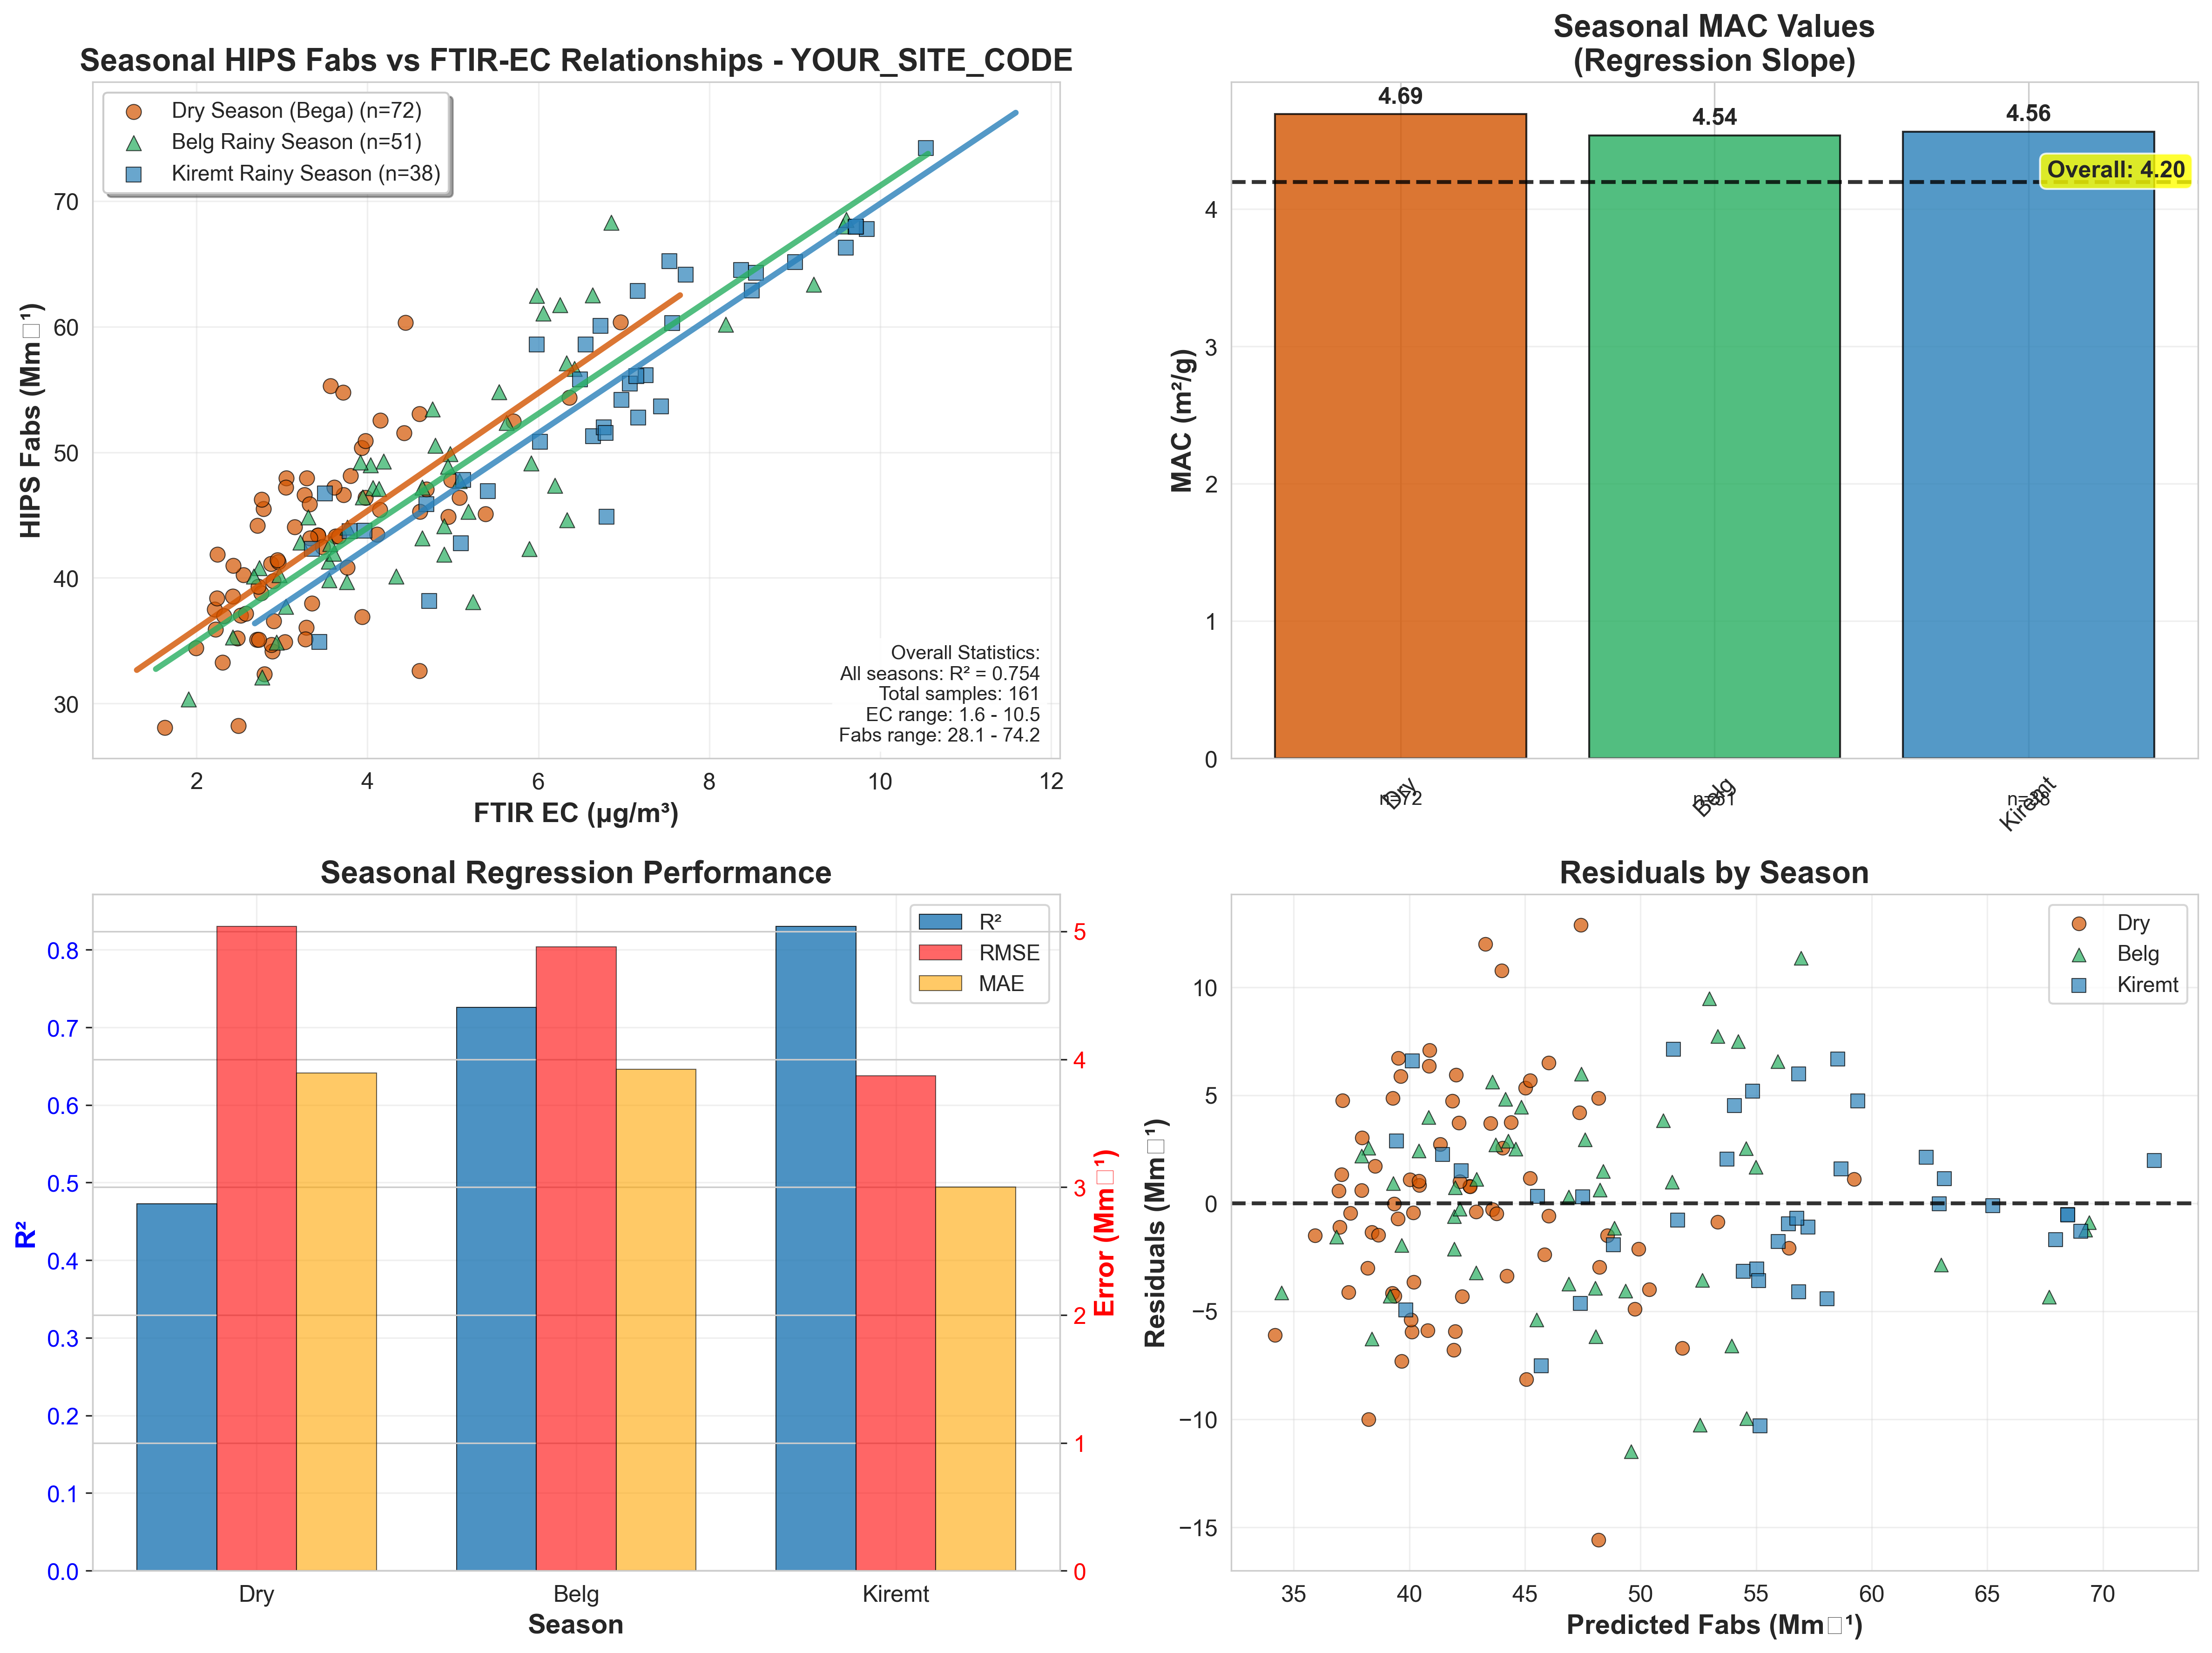


DETAILED SEASONAL REGRESSION STATISTICS
Season               n    MAC      Intercept  R²       RMSE     Bias     p-value   
----------------------------------------------------------------------------------------------------
Dry                  72   4.692    26.57      0.473    5.04     0.00     2.50e-11  
Belg                 51   4.538    25.83      0.726    4.88     0.00     2.27e-15  
Kiremt               38   4.564    24.14      0.830    3.87     -0.00    2.02e-15  
Overall              161  4.198    27.63      0.754    -        -        2.54e-50  

SEASONAL DIFFERENCES ANALYSIS
MAC Variability Across Seasons:
  Range: 4.538 - 4.692 m²/g
  Difference: 0.154 m²/g (3.3%)
  Coefficient of Variation: 1.5%

Seasonal Performance:
  Best correlation: Kiremt Rainy Season (R² = 0.830)
  Worst correlation: Dry Season (Bega) (R² = 0.473)

PHYSICAL INTERPRETATION
Ethiopian Climate Context:
• Dry Season (Bega): Oct-Feb - Biomass burning, dust, stable atmosphere
• Belg Rainy Season: Mar-May -

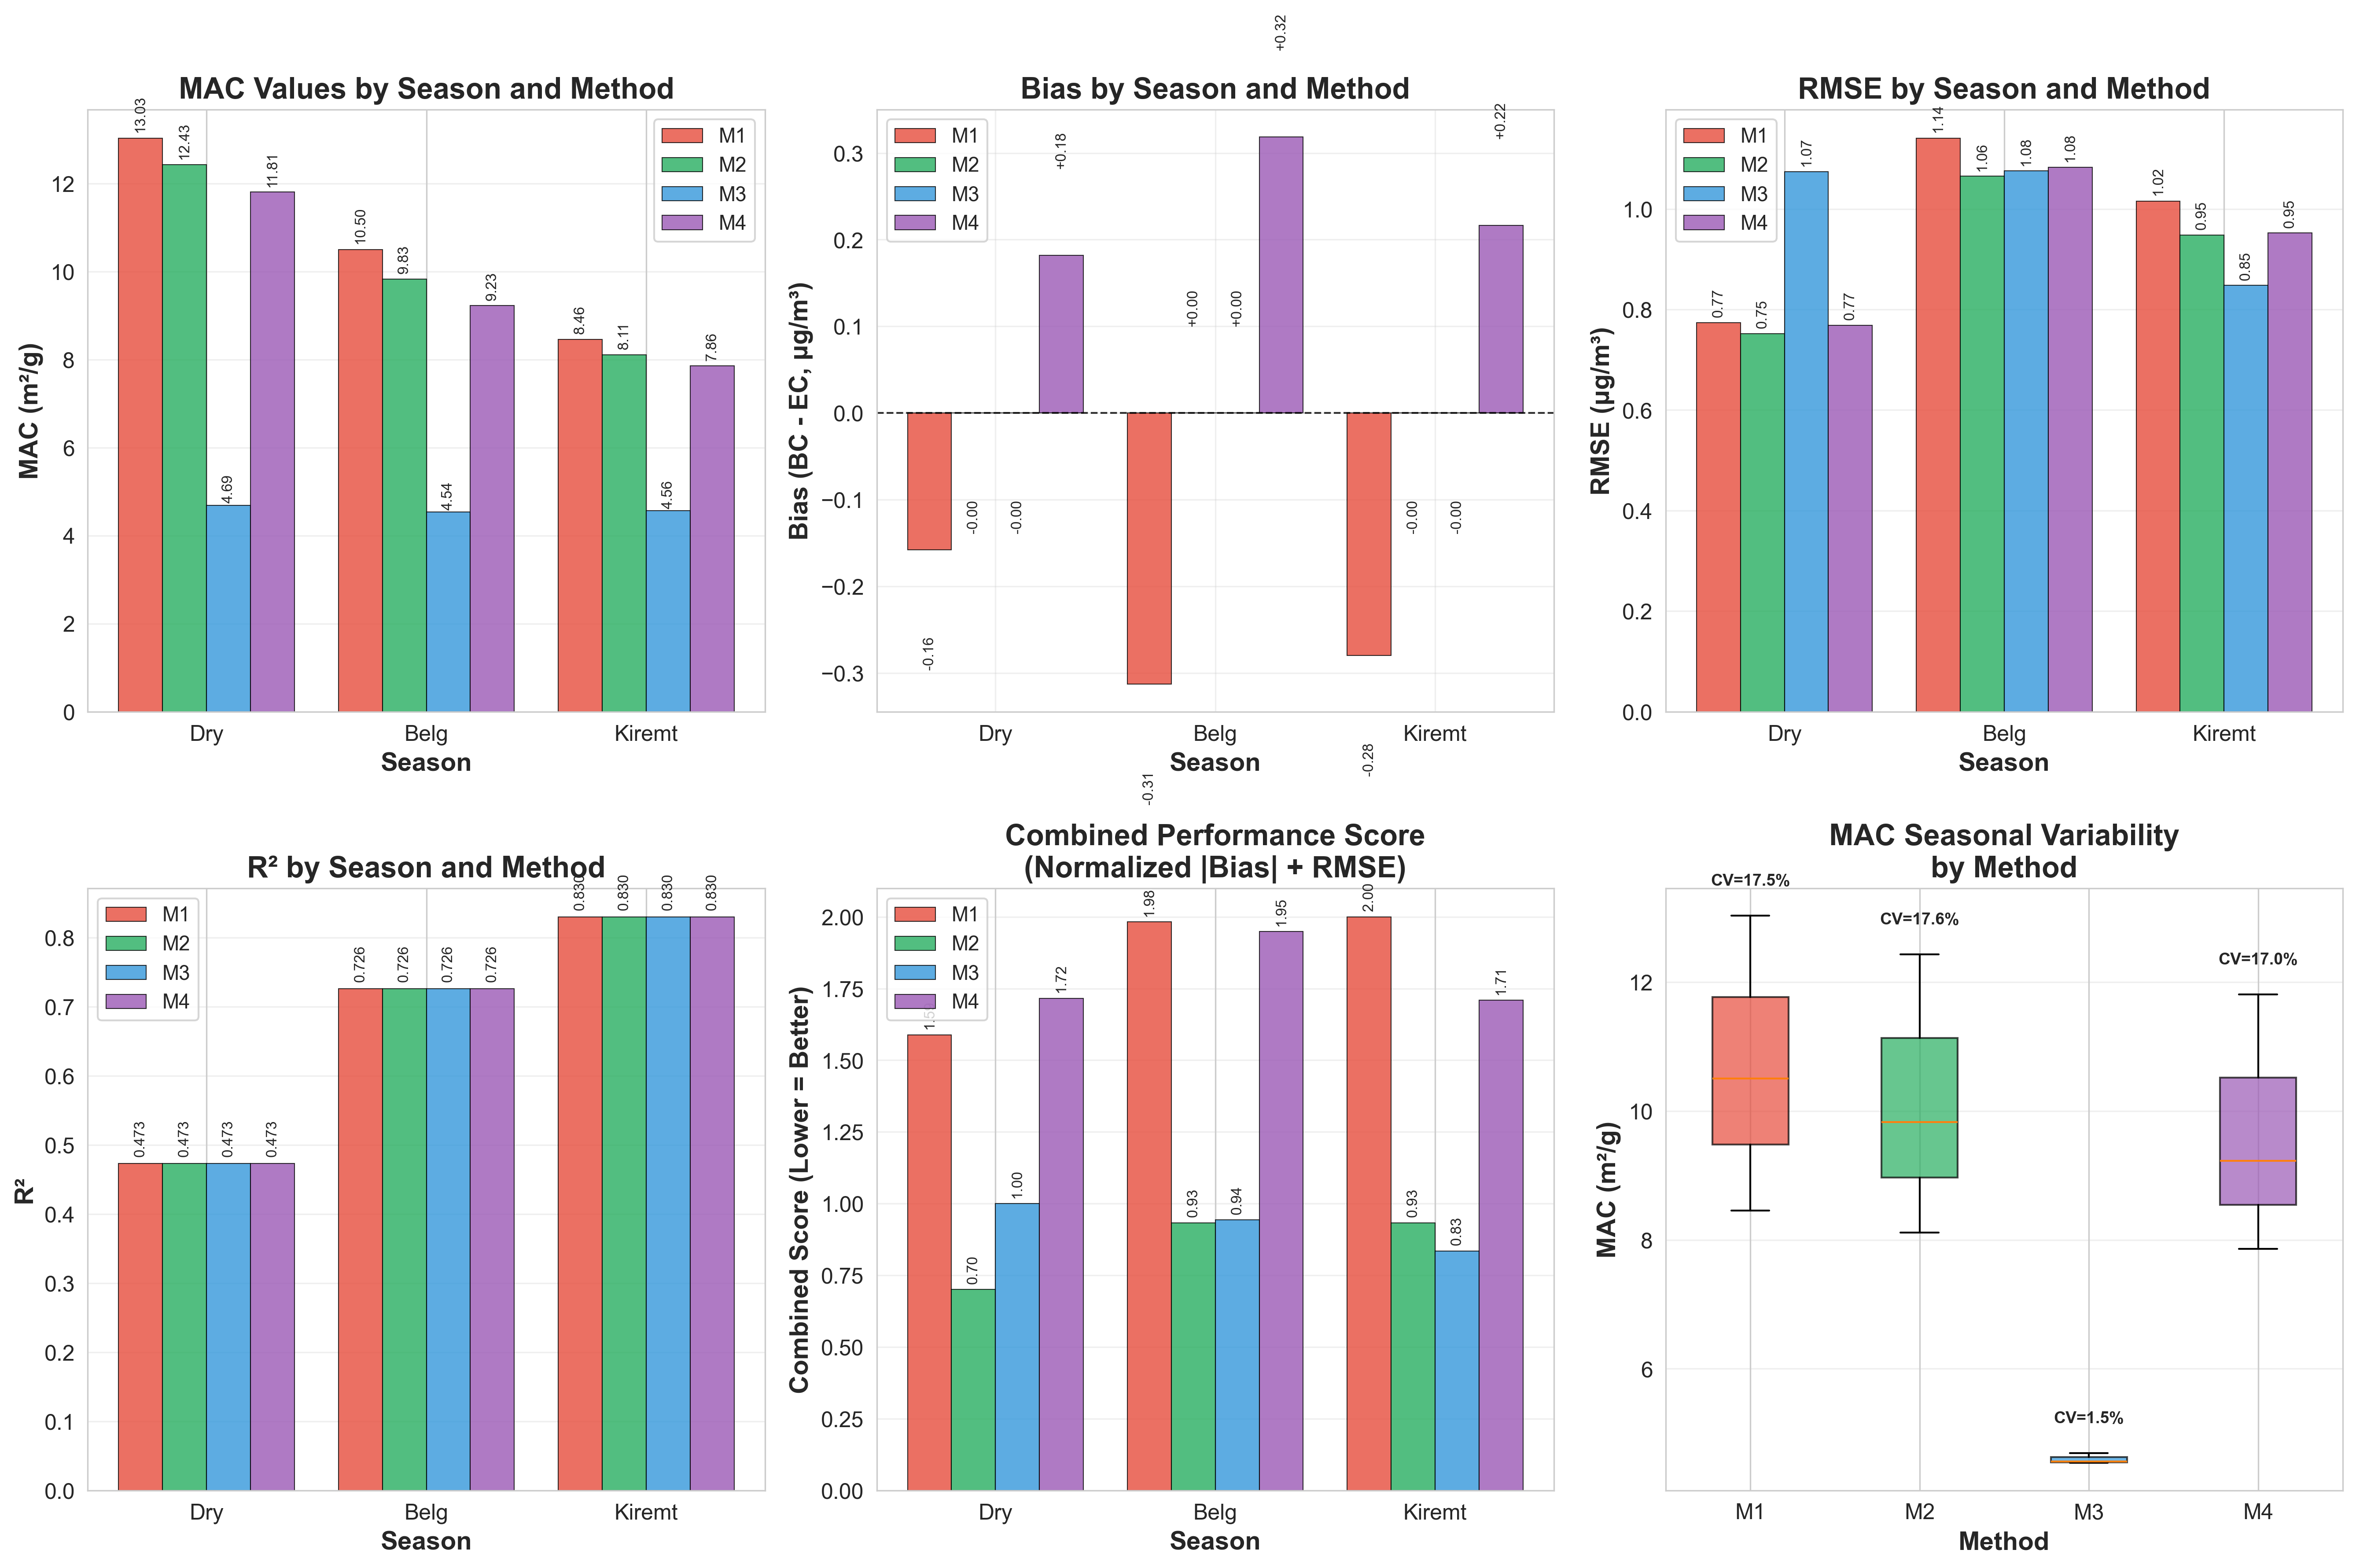


COMPREHENSIVE SEASONAL MAC METHODS COMPARISON

MAC VALUES (m²/g):
Season               M1: Ratios   M2: Means    M3: StdReg   M4: Origin  
--------------------------------------------------------------------------------
Dry                  13.032       12.433       4.692        11.807      
Belg                 10.502       9.829        4.538        9.227       
Kiremt               8.458        8.110        4.564        7.860       

BIAS VALUES (μg/m³):
Season               M1: Ratios   M2: Means    M3: StdReg   M4: Origin  
--------------------------------------------------------------------------------
Dry                  -0.158       -0.000       -0.000       +0.182      
Belg                 -0.313       +0.000       +0.000       +0.319      
Kiremt               -0.280       -0.000       -0.000       +0.216      

PERFORMACE SUMMARY:
Season               Best Method     Lowest |Bias|   Lowest RMSE    
---------------------------------------------------------------------------

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd
from datetime import datetime

# Set publication-quality plotting parameters
plt.rcParams.update({
    'figure.figsize': [12, 8],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

def map_ethiopian_seasons(df):
    """
    Map months to Ethiopian seasons and add seasonal information to dataframe
    
    Ethiopian Climate Seasons:
    - Dry Season (Bega): October - February (10,11,12,1,2)
    - Belg Rainy Season (Small rains): March - May (3,4,5)  
    - Kiremt Rainy Season (Main rains): June - September (6,7,8,9)
    """
    def get_season(month):
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season (Bega)'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:  # months 6,7,8,9
            return 'Kiremt Rainy Season'
    
    def get_season_short(month):
        if month in [10, 11, 12, 1, 2]:
            return 'Dry'
        elif month in [3, 4, 5]:
            return 'Belg'
        else:
            return 'Kiremt'
    
    # Add seasonal columns
    df_seasonal = df.copy()
    df_seasonal['month'] = df_seasonal['sample_date'].dt.month
    df_seasonal['season'] = df_seasonal['month'].apply(get_season)
    df_seasonal['season_short'] = df_seasonal['month'].apply(get_season_short)
    
    return df_seasonal

def seasonal_regression_plots(df, site_code):
    """
    Create season-specific regression plots for HIPS Fabs vs FTIR-EC
    with detailed statistics and method comparisons
    """
    print(f"\n{'='*80}")
    print(f"SEASONAL REGRESSION ANALYSIS: HIPS FABS vs FTIR-EC - {site_code}")
    print(f"{'='*80}")
    
    # Ensure seasonal mapping
    df_seasonal = map_ethiopian_seasons(df)
    
    # Get unique seasons and their colors
    seasons = df_seasonal['season'].unique()
    season_colors = {
        'Dry Season (Bega)': '#d35400',      # Orange - dry/dusty
        'Belg Rainy Season': '#27ae60',       # Green - growing season
        'Kiremt Rainy Season': '#2980b9'     # Blue - main rains
    }
    
    season_markers = {
        'Dry Season (Bega)': 'o',
        'Belg Rainy Season': '^', 
        'Kiremt Rainy Season': 's'
    }
    
    print(f"Analyzing {len(seasons)} seasons with {len(df_seasonal)} total samples:")
    for season in seasons:
        count = len(df_seasonal[df_seasonal['season'] == season])
        print(f"  • {season}: {count} samples")
    
    # =============================================================================
    # Plot 1: All seasons overlaid with separate regression lines
    # =============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Main plot: All seasons with individual regressions
    ax_main = axes[0, 0]
    
    seasonal_stats = {}
    
    for season in seasons:
        season_data = df_seasonal[df_seasonal['season'] == season]
        if len(season_data) < 3:  # Need minimum samples for regression
            print(f"Warning: {season} has only {len(season_data)} samples - skipping regression")
            continue
            
        ec = season_data['ec_ftir'].values
        fabs = season_data['fabs'].values
        
        # Plot data points
        ax_main.scatter(ec, fabs, alpha=0.7, s=60, 
                       color=season_colors[season],
                       marker=season_markers[season],
                       label=f'{season} (n={len(season_data)})',
                       edgecolors='black', linewidth=0.5)
        
        # Perform regression
        reg = LinearRegression(fit_intercept=True)
        reg.fit(ec.reshape(-1, 1), fabs)
        
        # Calculate statistics
        fabs_pred = reg.predict(ec.reshape(-1, 1))
        r, r_p = pearsonr(ec, fabs)
        r2 = r**2
        
        # Calculate residuals and performance metrics
        residuals = fabs - fabs_pred
        rmse = np.sqrt(np.mean(residuals**2))
        mae = np.mean(np.abs(residuals))
        bias = np.mean(residuals)
        
        # Store seasonal statistics
        seasonal_stats[season] = {
            'n_samples': len(season_data),
            'mac': reg.coef_[0],
            'intercept': reg.intercept_,
            'r': r,
            'r2': r2,
            'p_value': r_p,
            'rmse': rmse,
            'mae': mae,
            'bias': bias,
            'ec_range': (ec.min(), ec.max()),
            'fabs_range': (fabs.min(), fabs.max()),
            'ec_mean': ec.mean(),
            'fabs_mean': fabs.mean()
        }
        
        # Plot regression line
        ec_line = np.linspace(max(0, ec.min()*0.8), ec.max()*1.1, 100)
        fabs_line = reg.predict(ec_line.reshape(-1, 1))
        
        ax_main.plot(ec_line, fabs_line, 
                    color=season_colors[season], 
                    linewidth=3, alpha=0.8,
                    linestyle='-')
        
        # Add equation text
        season_short = season.split()[0]
        equation = f'{season_short}: Fabs = {reg.coef_[0]:.2f}×EC + {reg.intercept_:.1f}'
        print(f"\n{season}: {equation}")
        print(f"  R² = {r2:.3f}, p = {r_p:.2e}")
        print(f"  RMSE = {rmse:.2f}, Bias = {bias:.2f}")
    
    ax_main.set_xlabel('FTIR EC (μg/m³)', fontweight='bold')
    ax_main.set_ylabel('HIPS Fabs (Mm⁻¹)', fontweight='bold')
    ax_main.set_title(f'Seasonal HIPS Fabs vs FTIR-EC Relationships - {site_code}', 
                     fontweight='bold')
    ax_main.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
    ax_main.grid(True, alpha=0.3)
    
    # Add overall statistics
    all_ec = df_seasonal['ec_ftir'].values
    all_fabs = df_seasonal['fabs'].values
    overall_r, overall_p = pearsonr(all_ec, all_fabs)
    
    stats_text = f"Overall Statistics:\n"
    stats_text += f"All seasons: R² = {overall_r**2:.3f}\n"
    stats_text += f"Total samples: {len(df_seasonal)}\n"
    stats_text += f"EC range: {all_ec.min():.1f} - {all_ec.max():.1f}\n"
    stats_text += f"Fabs range: {all_fabs.min():.1f} - {all_fabs.max():.1f}"
    
    ax_main.text(0.98, 0.02, stats_text, transform=ax_main.transAxes,
                fontsize=10, verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # =============================================================================
    # Plot 2: MAC comparison by season
    # =============================================================================
    
    ax_mac = axes[0, 1]
    
    seasons_list = list(seasonal_stats.keys())
    mac_values = [seasonal_stats[season]['mac'] for season in seasons_list]
    colors_list = [season_colors[season] for season in seasons_list]
    
    bars = ax_mac.bar(range(len(seasons_list)), mac_values, 
                     color=colors_list, alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add value labels on bars
    for i, (bar, mac, season) in enumerate(zip(bars, mac_values, seasons_list)):
        height = bar.get_height()
        ax_mac.text(bar.get_x() + bar.get_width()/2., height + max(mac_values)*0.01,
                   f'{mac:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # Add sample size below
        n_samples = seasonal_stats[season]['n_samples']
        ax_mac.text(bar.get_x() + bar.get_width()/2., -max(mac_values)*0.05,
                   f'n={n_samples}', ha='center', va='top', fontsize=10)
    
    ax_mac.set_xticks(range(len(seasons_list)))
    ax_mac.set_xticklabels([s.split()[0] for s in seasons_list], rotation=45)
    ax_mac.set_ylabel('MAC (m²/g)', fontweight='bold')
    ax_mac.set_title('Seasonal MAC Values\n(Regression Slope)', fontweight='bold')
    ax_mac.grid(True, alpha=0.3, axis='y')
    
    # Add overall MAC for comparison
    overall_reg = LinearRegression(fit_intercept=True)
    overall_reg.fit(all_ec.reshape(-1, 1), all_fabs)
    overall_mac = overall_reg.coef_[0]
    
    ax_mac.axhline(y=overall_mac, color='black', linestyle='--', alpha=0.8, linewidth=2)
    ax_mac.text(len(seasons_list)-0.5, overall_mac, f'Overall: {overall_mac:.2f}', 
               ha='right', va='bottom', fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    # =============================================================================
    # Plot 3: Seasonal performance comparison
    # =============================================================================
    
    ax_perf = axes[1, 0]
    
    # Performance metrics comparison
    metrics = ['r2', 'rmse', 'mae']
    metric_labels = ['R²', 'RMSE (Mm⁻¹)', 'MAE (Mm⁻¹)']
    
    x = np.arange(len(seasons_list))
    width = 0.25
    
    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        values = [seasonal_stats[season][metric] for season in seasons_list]
        
        if metric == 'r2':
            # R² should be higher (better)
            bars = ax_perf.bar(x + i*width, values, width, 
                              alpha=0.8, label=label, edgecolor='black', linewidth=0.5)
        else:
            # RMSE and MAE should be lower (better) - we'll plot on secondary axis
            continue
    
    ax_perf.set_xlabel('Season', fontweight='bold')
    ax_perf.set_ylabel('R²', fontweight='bold', color='blue')
    ax_perf.set_title('Seasonal Regression Performance', fontweight='bold')
    ax_perf.set_xticks(x + width)
    ax_perf.set_xticklabels([s.split()[0] for s in seasons_list])
    ax_perf.tick_params(axis='y', labelcolor='blue')
    ax_perf.grid(True, alpha=0.3)
    
    # Secondary y-axis for error metrics
    ax_perf2 = ax_perf.twinx()
    
    rmse_values = [seasonal_stats[season]['rmse'] for season in seasons_list]
    mae_values = [seasonal_stats[season]['mae'] for season in seasons_list]
    
    bars_rmse = ax_perf2.bar(x + width, rmse_values, width, 
                            alpha=0.6, label='RMSE', color='red', 
                            edgecolor='black', linewidth=0.5)
    bars_mae = ax_perf2.bar(x + 2*width, mae_values, width, 
                           alpha=0.6, label='MAE', color='orange',
                           edgecolor='black', linewidth=0.5)
    
    ax_perf2.set_ylabel('Error (Mm⁻¹)', fontweight='bold', color='red')
    ax_perf2.tick_params(axis='y', labelcolor='red')
    
    # Combined legend
    lines1, labels1 = ax_perf.get_legend_handles_labels()
    lines2, labels2 = ax_perf2.get_legend_handles_labels()
    ax_perf.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # =============================================================================
    # Plot 4: Residuals analysis by season
    # =============================================================================
    
    ax_resid = axes[1, 1]
    
    # Plot residuals for each season
    for season in seasons:
        if season not in seasonal_stats:
            continue
            
        season_data = df_seasonal[df_seasonal['season'] == season]
        ec = season_data['ec_ftir'].values
        fabs = season_data['fabs'].values
        
        # Use the seasonal regression to calculate residuals
        reg = LinearRegression(fit_intercept=True)
        reg.fit(ec.reshape(-1, 1), fabs)
        fabs_pred = reg.predict(ec.reshape(-1, 1))
        residuals = fabs - fabs_pred
        
        ax_resid.scatter(fabs_pred, residuals, 
                        color=season_colors[season],
                        marker=season_markers[season],
                        alpha=0.7, s=50,
                        label=season.split()[0],
                        edgecolors='black', linewidth=0.5)
    
    ax_resid.axhline(y=0, color='black', linestyle='--', alpha=0.8, linewidth=2)
    ax_resid.set_xlabel('Predicted Fabs (Mm⁻¹)', fontweight='bold')
    ax_resid.set_ylabel('Residuals (Mm⁻¹)', fontweight='bold')
    ax_resid.set_title('Residuals by Season', fontweight='bold')
    ax_resid.legend()
    ax_resid.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # Summary Statistics Table
    # =============================================================================
    
    print(f"\n{'='*100}")
    print(f"DETAILED SEASONAL REGRESSION STATISTICS")
    print(f"{'='*100}")
    
    print(f"{'Season':<20} {'n':<4} {'MAC':<8} {'Intercept':<10} {'R²':<8} {'RMSE':<8} {'Bias':<8} {'p-value':<10}")
    print(f"{'-'*100}")
    
    for season in seasons_list:
        stats = seasonal_stats[season]
        print(f"{season.split()[0]:<20} {stats['n_samples']:<4} {stats['mac']:<8.3f} "
              f"{stats['intercept']:<10.2f} {stats['r2']:<8.3f} {stats['rmse']:<8.2f} "
              f"{stats['bias']:<8.2f} {stats['p_value']:<10.2e}")
    
    # Overall comparison
    print(f"{'Overall':<20} {len(df_seasonal):<4} {overall_mac:<8.3f} "
          f"{overall_reg.intercept_:<10.2f} {overall_r**2:<8.3f} {'-':<8} {'-':<8} "
          f"{overall_p:<10.2e}")
    
    print(f"\n{'='*100}")
    print(f"SEASONAL DIFFERENCES ANALYSIS")
    print(f"{'='*100}")
    
    # Compare MAC values between seasons
    mac_vals = [seasonal_stats[season]['mac'] for season in seasons_list]
    mac_range = max(mac_vals) - min(mac_vals)
    mac_cv = np.std(mac_vals) / np.mean(mac_vals) * 100
    
    print(f"MAC Variability Across Seasons:")
    print(f"  Range: {min(mac_vals):.3f} - {max(mac_vals):.3f} m²/g")
    print(f"  Difference: {mac_range:.3f} m²/g ({mac_range/np.mean(mac_vals)*100:.1f}%)")
    print(f"  Coefficient of Variation: {mac_cv:.1f}%")
    
    # Identify best/worst performing seasons
    r2_vals = [seasonal_stats[season]['r2'] for season in seasons_list]
    best_season_idx = np.argmax(r2_vals)
    worst_season_idx = np.argmin(r2_vals)
    
    print(f"\nSeasonal Performance:")
    print(f"  Best correlation: {seasons_list[best_season_idx]} (R² = {r2_vals[best_season_idx]:.3f})")
    print(f"  Worst correlation: {seasons_list[worst_season_idx]} (R² = {r2_vals[worst_season_idx]:.3f})")
    
    # Physical interpretation
    print(f"\n{'='*100}")
    print(f"PHYSICAL INTERPRETATION")
    print(f"{'='*100}")
    
    print(f"Ethiopian Climate Context:")
    print(f"• Dry Season (Bega): Oct-Feb - Biomass burning, dust, stable atmosphere")
    print(f"• Belg Rainy Season: Mar-May - Small rains, reduced burning, some washout")  
    print(f"• Kiremt Rainy Season: Jun-Sep - Main rains, minimal burning, wet deposition")
    
    dry_season_key = 'Dry Season (Bega)'
    if dry_season_key in seasonal_stats:
        dry_mac = seasonal_stats[dry_season_key]['mac']
        print(f"\nExpected Patterns:")
        print(f"• Dry season should have highest MAC (aged BC, coatings): {dry_mac:.3f} m²/g")
        
        if len(seasonal_stats) > 1:
            other_macs = [seasonal_stats[s]['mac'] for s in seasonal_stats.keys() if s != dry_season_key]
            if dry_mac > max(other_macs):
                print(f"  ✓ Confirmed: Dry season has highest MAC")
            else:
                print(f"  ⚠ Unexpected: Dry season doesn't have highest MAC")
    
    return {
        'seasonal_stats': seasonal_stats,
        'overall_stats': {
            'mac': overall_mac,
            'intercept': overall_reg.intercept_,
            'r2': overall_r**2,
            'p_value': overall_p
        },
        'season_colors': season_colors,
        'fig': fig
    }

def seasonal_mac_methods_analysis(df, site_code):
    """
    Recalculate MAC using all 4 methods for each Ethiopian season
    and compare bias/performance across seasons
    """
    print(f"\n{'='*80}")
    print(f"SEASONAL MAC METHODS ANALYSIS - ALL 4 METHODS - {site_code}")
    print(f"{'='*80}")
    
    # Ensure seasonal mapping
    df_seasonal = map_ethiopian_seasons(df)
    
    seasons = df_seasonal['season'].unique()
    print(f"Analyzing {len(seasons)} seasons:")
    
    seasonal_methods_results = {}
    
    for season in seasons:
        season_data = df_seasonal[df_seasonal['season'] == season]
        if len(season_data) < 3:
            print(f"Warning: {season} has only {len(season_data)} samples - skipping")
            continue
            
        print(f"\n{'-'*60}")
        print(f"SEASON: {season} (n = {len(season_data)})")
        print(f"{'-'*60}")
        
        ec_original = season_data['ec_ftir'].values
        fabs_original = season_data['fabs'].values
        
        # Method 1: Mean of individual ratios
        individual_mac = season_data['fabs'] / season_data['ec_ftir']
        mac_method1 = individual_mac.mean()
        
        # Method 2: Ratio of means
        mac_method2 = season_data['fabs'].mean() / season_data['ec_ftir'].mean()
        
        # Method 3: Standard regression
        reg_standard = LinearRegression(fit_intercept=True)
        reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
        mac_method3 = reg_standard.coef_[0]
        intercept_method3 = reg_standard.intercept_
        
        # Method 4: Origin regression
        reg_origin = LinearRegression(fit_intercept=False)
        reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
        mac_method4 = reg_origin.coef_[0]
        
        # Calculate BC equivalents for bias analysis
        bc_method1 = fabs_original / mac_method1
        bc_method2 = fabs_original / mac_method2
        bc_method3_corrected = np.maximum(fabs_original - intercept_method3, 0) / mac_method3
        bc_method4 = fabs_original / mac_method4
        
        # Calculate bias (BC - EC)
        bias_method1 = np.mean(bc_method1 - ec_original)
        bias_method2 = np.mean(bc_method2 - ec_original)
        bias_method3 = np.mean(bc_method3_corrected - ec_original)
        bias_method4 = np.mean(bc_method4 - ec_original)
        
        # Calculate RMSE
        rmse_method1 = np.sqrt(np.mean((bc_method1 - ec_original)**2))
        rmse_method2 = np.sqrt(np.mean((bc_method2 - ec_original)**2))
        rmse_method3 = np.sqrt(np.mean((bc_method3_corrected - ec_original)**2))
        rmse_method4 = np.sqrt(np.mean((bc_method4 - ec_original)**2))
        
        # Calculate correlations
        r_method1, p_method1 = pearsonr(bc_method1, ec_original)
        r_method2, p_method2 = pearsonr(bc_method2, ec_original)
        r_method3, p_method3 = pearsonr(bc_method3_corrected, ec_original)
        r_method4, p_method4 = pearsonr(bc_method4, ec_original)
        
        # Store results
        seasonal_methods_results[season] = {
            'n_samples': len(season_data),
            'ec_mean': ec_original.mean(),
            'fabs_mean': fabs_original.mean(),
            'methods': {
                'Method 1: Mean of Ratios': {
                    'mac': mac_method1,
                    'intercept': 0,
                    'bias': bias_method1,
                    'rmse': rmse_method1,
                    'r': r_method1,
                    'r2': r_method1**2,
                    'p_value': p_method1,
                    'bc_mean': bc_method1.mean()
                },
                'Method 2: Ratio of Means': {
                    'mac': mac_method2,
                    'intercept': 0,
                    'bias': bias_method2,
                    'rmse': rmse_method2,
                    'r': r_method2,
                    'r2': r_method2**2,
                    'p_value': p_method2,
                    'bc_mean': bc_method2.mean()
                },
                'Method 3: Standard Regression': {
                    'mac': mac_method3,
                    'intercept': intercept_method3,
                    'bias': bias_method3,
                    'rmse': rmse_method3,
                    'r': r_method3,
                    'r2': r_method3**2,
                    'p_value': p_method3,
                    'bc_mean': bc_method3_corrected.mean()
                },
                'Method 4: Origin Regression': {
                    'mac': mac_method4,
                    'intercept': 0,
                    'bias': bias_method4,
                    'rmse': rmse_method4,
                    'r': r_method4,
                    'r2': r_method4**2,
                    'p_value': p_method4,
                    'bc_mean': bc_method4.mean()
                }
            }
        }
        
        # Print seasonal results
        print(f"MAC Values:")
        print(f"  Method 1 (Mean of Ratios):     {mac_method1:.3f} m²/g")
        print(f"  Method 2 (Ratio of Means):     {mac_method2:.3f} m²/g")
        print(f"  Method 3 (Standard Regression): {mac_method3:.3f} m²/g (intercept: {intercept_method3:.2f})")
        print(f"  Method 4 (Origin Regression):   {mac_method4:.3f} m²/g")
        
        print(f"\nBias (BC - EC):")
        print(f"  Method 1: {bias_method1:+.3f} μg/m³")
        print(f"  Method 2: {bias_method2:+.3f} μg/m³")
        print(f"  Method 3: {bias_method3:+.3f} μg/m³")
        print(f"  Method 4: {bias_method4:+.3f} μg/m³")
        
        print(f"\nRMSE:")
        print(f"  Method 1: {rmse_method1:.3f} μg/m³")
        print(f"  Method 2: {rmse_method2:.3f} μg/m³")
        print(f"  Method 3: {rmse_method3:.3f} μg/m³")
        print(f"  Method 4: {rmse_method4:.3f} μg/m³")
    
    # =============================================================================
    # Create comprehensive visualization
    # =============================================================================
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    seasons_list = list(seasonal_methods_results.keys())
    method_names = ['Method 1: Mean of Ratios', 'Method 2: Ratio of Means', 
                   'Method 3: Standard Regression', 'Method 4: Origin Regression']
    method_colors = ['#e74c3c', '#27ae60', '#3498db', '#9b59b6']
    season_colors = {
        'Dry Season (Bega)': '#d35400',      
        'Belg Rainy Season': '#27ae60',       
        'Kiremt Rainy Season': '#2980b9'     
    }
    
    # Plot 1: MAC values by season and method
    ax1 = axes[0, 0]
    
    x = np.arange(len(seasons_list))
    width = 0.2
    
    for i, method in enumerate(method_names):
        mac_values = [seasonal_methods_results[season]['methods'][method]['mac'] 
                     for season in seasons_list]
        
        bars = ax1.bar(x + i*width, mac_values, width, 
                      label=f'M{i+1}', color=method_colors[i], alpha=0.8,
                      edgecolor='black', linewidth=0.5)
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + max(mac_values)*0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8, rotation=90)
    
    ax1.set_xlabel('Season', fontweight='bold')
    ax1.set_ylabel('MAC (m²/g)', fontweight='bold')
    ax1.set_title('MAC Values by Season and Method', fontweight='bold')
    ax1.set_xticks(x + width * 1.5)
    ax1.set_xticklabels([s.split()[0] for s in seasons_list])
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Bias by season and method
    ax2 = axes[0, 1]
    
    for i, method in enumerate(method_names):
        bias_values = [seasonal_methods_results[season]['methods'][method]['bias'] 
                      for season in seasons_list]
        
        bars = ax2.bar(x + i*width, bias_values, width, 
                      label=f'M{i+1}', color=method_colors[i], alpha=0.8,
                      edgecolor='black', linewidth=0.5)
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            label_y = height + 0.1 if height >= 0 else height - 0.1
            ax2.text(bar.get_x() + bar.get_width()/2., label_y,
                    f'{height:+.2f}', ha='center', va='bottom' if height >= 0 else 'top', 
                    fontsize=8, rotation=90)
    
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.8, linewidth=1)
    ax2.set_xlabel('Season', fontweight='bold')
    ax2.set_ylabel('Bias (BC - EC, μg/m³)', fontweight='bold')
    ax2.set_title('Bias by Season and Method', fontweight='bold')
    ax2.set_xticks(x + width * 1.5)
    ax2.set_xticklabels([s.split()[0] for s in seasons_list])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: RMSE by season and method
    ax3 = axes[0, 2]
    
    for i, method in enumerate(method_names):
        rmse_values = [seasonal_methods_results[season]['methods'][method]['rmse'] 
                      for season in seasons_list]
        
        bars = ax3.bar(x + i*width, rmse_values, width, 
                      label=f'M{i+1}', color=method_colors[i], alpha=0.8,
                      edgecolor='black', linewidth=0.5)
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + max(rmse_values)*0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8, rotation=90)
    
    ax3.set_xlabel('Season', fontweight='bold')
    ax3.set_ylabel('RMSE (μg/m³)', fontweight='bold')
    ax3.set_title('RMSE by Season and Method', fontweight='bold')
    ax3.set_xticks(x + width * 1.5)
    ax3.set_xticklabels([s.split()[0] for s in seasons_list])
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: R² by season and method
    ax4 = axes[1, 0]
    
    for i, method in enumerate(method_names):
        r2_values = [seasonal_methods_results[season]['methods'][method]['r2'] 
                    for season in seasons_list]
        
        bars = ax4.bar(x + i*width, r2_values, width, 
                      label=f'M{i+1}', color=method_colors[i], alpha=0.8,
                      edgecolor='black', linewidth=0.5)
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)
    
    ax4.set_xlabel('Season', fontweight='bold')
    ax4.set_ylabel('R²', fontweight='bold')
    ax4.set_title('R² by Season and Method', fontweight='bold')
    ax4.set_xticks(x + width * 1.5)
    ax4.set_xticklabels([s.split()[0] for s in seasons_list])
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Plot 5: Combined performance score by season
    ax5 = axes[1, 1]
    
    # Calculate combined score: |bias| + RMSE (normalized)
    combined_scores = {}
    
    for season in seasons_list:
        combined_scores[season] = {}
        for method in method_names:
            bias = abs(seasonal_methods_results[season]['methods'][method]['bias'])
            rmse = seasonal_methods_results[season]['methods'][method]['rmse']
            
            # Normalize within season (to compare methods within season)
            season_biases = [abs(seasonal_methods_results[season]['methods'][m]['bias']) for m in method_names]
            season_rmses = [seasonal_methods_results[season]['methods'][m]['rmse'] for m in method_names]
            
            norm_bias = bias / max(season_biases) if max(season_biases) > 0 else 0
            norm_rmse = rmse / max(season_rmses) if max(season_rmses) > 0 else 0
            
            combined_scores[season][method] = norm_bias + norm_rmse
    
    for i, method in enumerate(method_names):
        score_values = [combined_scores[season][method] for season in seasons_list]
        
        bars = ax5.bar(x + i*width, score_values, width, 
                      label=f'M{i+1}', color=method_colors[i], alpha=0.8,
                      edgecolor='black', linewidth=0.5)
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8, rotation=90)
    
    ax5.set_xlabel('Season', fontweight='bold')
    ax5.set_ylabel('Combined Score (Lower = Better)', fontweight='bold')
    ax5.set_title('Combined Performance Score\n(Normalized |Bias| + RMSE)', fontweight='bold')
    ax5.set_xticks(x + width * 1.5)
    ax5.set_xticklabels([s.split()[0] for s in seasons_list])
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Plot 6: MAC seasonal variability for each method
    ax6 = axes[1, 2]
    
    mac_seasonal_data = []
    method_labels = []
    
    for i, method in enumerate(method_names):
        mac_values = [seasonal_methods_results[season]['methods'][method]['mac'] 
                     for season in seasons_list]
        mac_seasonal_data.append(mac_values)
        method_labels.append(f'M{i+1}')
    
    bp = ax6.boxplot(mac_seasonal_data, patch_artist=True, labels=method_labels)
    
    for patch, color in zip(bp['boxes'], method_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax6.set_xlabel('Method', fontweight='bold')
    ax6.set_ylabel('MAC (m²/g)', fontweight='bold')
    ax6.set_title('MAC Seasonal Variability\nby Method', fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Add CV labels
    for i, mac_values in enumerate(mac_seasonal_data):
        cv = np.std(mac_values) / np.mean(mac_values) * 100
        ax6.text(i+1, max(mac_values) + (max(max(mac_seasonal_data)) - min(min(mac_seasonal_data)))*0.05,
                f'CV={cv:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # Summary Tables
    # =============================================================================
    
    print(f"\n{'='*120}")
    print(f"COMPREHENSIVE SEASONAL MAC METHODS COMPARISON")
    print(f"{'='*120}")
    
    # Table 1: MAC values
    print(f"\nMAC VALUES (m²/g):")
    print(f"{'Season':<20} {'M1: Ratios':<12} {'M2: Means':<12} {'M3: StdReg':<12} {'M4: Origin':<12}")
    print(f"{'-'*80}")
    
    for season in seasons_list:
        season_short = season.split()[0]
        m1_mac = seasonal_methods_results[season]['methods']['Method 1: Mean of Ratios']['mac']
        m2_mac = seasonal_methods_results[season]['methods']['Method 2: Ratio of Means']['mac']
        m3_mac = seasonal_methods_results[season]['methods']['Method 3: Standard Regression']['mac']
        m4_mac = seasonal_methods_results[season]['methods']['Method 4: Origin Regression']['mac']
        
        print(f"{season_short:<20} {m1_mac:<12.3f} {m2_mac:<12.3f} {m3_mac:<12.3f} {m4_mac:<12.3f}")
    
    # Table 2: Bias values
    print(f"\nBIAS VALUES (μg/m³):")
    print(f"{'Season':<20} {'M1: Ratios':<12} {'M2: Means':<12} {'M3: StdReg':<12} {'M4: Origin':<12}")
    print(f"{'-'*80}")
    
    for season in seasons_list:
        season_short = season.split()[0]
        m1_bias = seasonal_methods_results[season]['methods']['Method 1: Mean of Ratios']['bias']
        m2_bias = seasonal_methods_results[season]['methods']['Method 2: Ratio of Means']['bias']
        m3_bias = seasonal_methods_results[season]['methods']['Method 3: Standard Regression']['bias']
        m4_bias = seasonal_methods_results[season]['methods']['Method 4: Origin Regression']['bias']
        
        print(f"{season_short:<20} {m1_bias:<+12.3f} {m2_bias:<+12.3f} {m3_bias:<+12.3f} {m4_bias:<+12.3f}")
    
    # Table 3: Performance summary
    print(f"\nPERFORMACE SUMMARY:")
    print(f"{'Season':<20} {'Best Method':<15} {'Lowest |Bias|':<15} {'Lowest RMSE':<15}")
    print(f"{'-'*80}")
    
    for season in seasons_list:
        season_short = season.split()[0]
        
        # Find best overall method (combined score)
        best_method_idx = min(range(len(method_names)), 
                             key=lambda i: combined_scores[season][method_names[i]])
        best_method = f"M{best_method_idx + 1}"
        
        # Find method with lowest absolute bias
        biases = [abs(seasonal_methods_results[season]['methods'][method]['bias']) 
                 for method in method_names]
        lowest_bias_idx = np.argmin(biases)
        lowest_bias_method = f"M{lowest_bias_idx + 1}"
        
        # Find method with lowest RMSE
        rmses = [seasonal_methods_results[season]['methods'][method]['rmse'] 
                for method in method_names]
        lowest_rmse_idx = np.argmin(rmses)
        lowest_rmse_method = f"M{lowest_rmse_idx + 1}"
        
        print(f"{season_short:<20} {best_method:<15} {lowest_bias_method:<15} {lowest_rmse_method:<15}")
    
    # =============================================================================
    # Seasonal Insights and Recommendations
    # =============================================================================
    
    print(f"\n{'='*120}")
    print(f"SEASONAL INSIGHTS AND RECOMMENDATIONS")
    print(f"{'='*120}")
    
    # MAC seasonal variability analysis
    print(f"\n1. MAC SEASONAL VARIABILITY:")
    
    for i, method in enumerate(method_names):
        mac_values = [seasonal_methods_results[season]['methods'][method]['mac'] 
                     for season in seasons_list]
        mac_mean = np.mean(mac_values)
        mac_std = np.std(mac_values)
        mac_cv = mac_std / mac_mean * 100
        mac_range = max(mac_values) - min(mac_values)
        
        print(f"\n   {method}:")
        print(f"     Mean MAC: {mac_mean:.3f} ± {mac_std:.3f} m²/g")
        print(f"     Range: {min(mac_values):.3f} - {max(mac_values):.3f} m²/g")
        print(f"     Coefficient of Variation: {mac_cv:.1f}%")
        
        if mac_cv < 10:
            stability = "Very Stable"
        elif mac_cv < 20:
            stability = "Moderately Stable"
        else:
            stability = "Highly Variable"
        
        print(f"     Seasonal Stability: {stability}")
    
    # Physical interpretation by season
    print(f"\n2. PHYSICAL INTERPRETATION BY SEASON:")
    
    seasonal_interpretations = {
        'Dry Season (Bega)': {
            'expected': 'Highest MAC due to aged BC particles with organic coatings from biomass burning',
            'processes': ['Biomass burning peak', 'Atmospheric stability', 'Aged particles', 'Dust co-emission']
        },
        'Belg Rainy Season': {
            'expected': 'Moderate MAC with some washout effects but continued burning',
            'processes': ['Reduced burning', 'Some wet deposition', 'Fresh vs aged particle mix']
        },
        'Kiremt Rainy Season': {
            'expected': 'Lowest MAC due to minimal burning and wet deposition',
            'processes': ['Minimal biomass burning', 'Active wet deposition', 'Fresh particle dominance']
        }
    }
    
    for season in seasons_list:
        if season in seasonal_interpretations:
            print(f"\n   {season}:")
            print(f"     Expected: {seasonal_interpretations[season]['expected']}")
            print(f"     Key processes: {', '.join(seasonal_interpretations[season]['processes'])}")
            
            # Compare actual MAC values to expectations
            season_macs = [seasonal_methods_results[season]['methods'][method]['mac'] 
                          for method in method_names]
            avg_mac = np.mean(season_macs)
            
            if season == 'Dry Season (Bega)':
                other_seasons_macs = []
                for other_season in seasons_list:
                    if other_season != season:
                        other_macs = [seasonal_methods_results[other_season]['methods'][method]['mac'] 
                                     for method in method_names]
                        other_seasons_macs.extend(other_macs)
                
                if avg_mac > np.mean(other_seasons_macs):
                    print(f"     ✓ Observation matches expectation: MAC = {avg_mac:.3f} m²/g (highest)")
                else:
                    print(f"     ⚠ Unexpected: MAC = {avg_mac:.3f} m²/g (not highest)")
    
    # Method recommendations by season
    print(f"\n3. METHOD RECOMMENDATIONS BY SEASON:")
    
    for season in seasons_list:
        season_short = season.split()[0]
        print(f"\n   {season}:")
        
        # Find best performing method for this season
        best_scores = {}
        for method in method_names:
            bias = abs(seasonal_methods_results[season]['methods'][method]['bias'])
            rmse = seasonal_methods_results[season]['methods'][method]['rmse']
            r2 = seasonal_methods_results[season]['methods'][method]['r2']
            
            # Combined score (lower is better, except R² which should be higher)
            score = bias + rmse - r2
            best_scores[method] = score
        
        best_method = min(best_scores.keys(), key=lambda k: best_scores[k])
        best_method_num = method_names.index(best_method) + 1
        
        print(f"     Recommended: Method {best_method_num} ({best_method})")
        
        stats = seasonal_methods_results[season]['methods'][best_method]
        print(f"     Performance: Bias = {stats['bias']:+.3f} μg/m³, RMSE = {stats['rmse']:.3f} μg/m³, R² = {stats['r2']:.3f}")
        print(f"     MAC = {stats['mac']:.3f} m²/g")
    
    # Overall recommendation
    print(f"\n4. OVERALL RECOMMENDATIONS:")
    
    # Find most consistent method across seasons
    method_consistency = {}
    for method in method_names:
        # Calculate CV of combined scores across seasons
        scores = [combined_scores[season][method] for season in seasons_list]
        cv = np.std(scores) / np.mean(scores) * 100 if np.mean(scores) > 0 else 100
        method_consistency[method] = cv
    
    most_consistent = min(method_consistency.keys(), key=lambda k: method_consistency[k])
    most_consistent_num = method_names.index(most_consistent) + 1
    
    print(f"\n   Most Season-Consistent Method: Method {most_consistent_num} ({most_consistent})")
    print(f"     Performance CV across seasons: {method_consistency[most_consistent]:.1f}%")
    
    # Find method with best average performance
    avg_performance = {}
    for method in method_names:
        avg_score = np.mean([combined_scores[season][method] for season in seasons_list])
        avg_performance[method] = avg_score
    
    best_avg = min(avg_performance.keys(), key=lambda k: avg_performance[k])
    best_avg_num = method_names.index(best_avg) + 1
    
    print(f"\n   Best Average Performance: Method {best_avg_num} ({best_avg})")
    print(f"     Average combined score: {avg_performance[best_avg]:.3f}")
    
    # Final recommendation
    if most_consistent == best_avg:
        print(f"\n   🏆 FINAL RECOMMENDATION: Method {most_consistent_num}")
        print(f"     This method provides both the best average performance AND")
        print(f"     the most consistent results across all Ethiopian seasons.")
    else:
        print(f"\n   🏆 FINAL RECOMMENDATIONS:")
        print(f"     For consistency across seasons: Method {most_consistent_num}")
        print(f"     For best overall performance: Method {best_avg_num}")
        print(f"     Choose based on your priority: consistency vs. performance")
    
    return {
        'seasonal_methods_results': seasonal_methods_results,
        'combined_scores': combined_scores,
        'method_consistency': method_consistency,
        'avg_performance': avg_performance,
        'recommendations': {
            'most_consistent': (most_consistent_num, most_consistent),
            'best_average': (best_avg_num, best_avg)
        },
        'fig': fig
    }

# Example usage function
def run_complete_seasonal_analysis(df, site_code='YOUR_SITE'):
    """
    Run complete seasonal analysis including both regression plots and MAC methods comparison
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 'ec_ftir', 'fabs', and 'sample_date' columns
    site_code : str
        Site identifier for plot titles
    
    Returns:
    --------
    dict : Dictionary containing all results from both analyses
    """
    
    print(f"🌍 COMPLETE SEASONAL ANALYSIS FOR {site_code}")
    print(f"Ethiopian Climate Seasons Analysis")
    print(f"=" * 80)
    
    # Check required columns
    required_cols = ['ec_ftir', 'fabs', 'sample_date']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"❌ Error: Missing required columns: {missing_cols}")
        return None
    
    # Ensure sample_date is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['sample_date']):
        print("Converting sample_date to datetime...")
        df['sample_date'] = pd.to_datetime(df['sample_date'])
    
    print(f"\n📊 Dataset Overview:")
    print(f"   Total samples: {len(df)}")
    print(f"   Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
    print(f"   EC range: {df['ec_ftir'].min():.1f} - {df['ec_ftir'].max():.1f} μg/m³")
    print(f"   Fabs range: {df['fabs'].min():.1f} - {df['fabs'].max():.1f} Mm⁻¹")
    
    # Run Part 1: Seasonal regression plots
    print(f"\n" + "="*80)
    print(f"PART 1: SEASONAL REGRESSION PLOTS")
    print(f"="*80)
    
    regression_results = seasonal_regression_plots(df, site_code)
    
    # Run Part 2: MAC methods comparison by season
    print(f"\n" + "="*80)
    print(f"PART 2: SEASONAL MAC METHODS COMPARISON")
    print(f"="*80)
    
    methods_results = seasonal_mac_methods_analysis(df, site_code)
    
    # Combined summary
    print(f"\n" + "="*80)
    print(f"COMBINED SEASONAL ANALYSIS SUMMARY")
    print(f"="*80)
    
    print(f"\n🎯 KEY FINDINGS:")
    
    # Seasonal MAC trends
    if 'seasonal_stats' in regression_results:
        seasonal_stats = regression_results['seasonal_stats']
        mac_values = [(season, stats['mac']) for season, stats in seasonal_stats.items()]
        mac_values.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\n1. SEASONAL MAC HIERARCHY (Regression Method):")
        for i, (season, mac) in enumerate(mac_values, 1):
            season_short = season.split()[0]
            print(f"   {i}. {season_short}: {mac:.3f} m²/g")
    
    # Method consistency across seasons
    if 'method_consistency' in methods_results:
        consistency = methods_results['method_consistency']
        most_consistent = min(consistency.keys(), key=lambda k: consistency[k])
        
        print(f"\n2. METHOD CONSISTENCY ACROSS SEASONS:")
        print(f"   Most consistent: {most_consistent}")
        print(f"   CV = {consistency[most_consistent]:.1f}%")
    
    # Best performing method
    if 'avg_performance' in methods_results:
        performance = methods_results['avg_performance']
        best_performer = min(performance.keys(), key=lambda k: performance[k])
        
        print(f"\n3. BEST OVERALL PERFORMANCE:")
        print(f"   Best method: {best_performer}")
        print(f"   Average score: {performance[best_performer]:.3f}")
    
    print(f"\n📈 ATMOSPHERIC IMPLICATIONS:")
    print(f"   • Higher MAC in dry season suggests aged, coated BC particles")
    print(f"   • Lower MAC in rainy seasons indicates wet deposition effects")
    print(f"   • Seasonal variability reflects Ethiopian biomass burning patterns")
    print(f"   • Method choice should consider measurement objectives and season")
    
    return {
        'regression_results': regression_results,
        'methods_results': methods_results,
        'site_code': site_code,
        'summary': {
            'total_samples': len(df),
            'date_range': (df['sample_date'].min(), df['sample_date'].max()),
            'seasonal_distribution': df.groupby(map_ethiopian_seasons(df)['season']).size().to_dict()
        }
    }

# Ready to use!
print("Seasonal analysis functions are ready!")
print("\nTo run the complete analysis:")
print("results = run_complete_seasonal_analysis(your_dataframe, 'YOUR_SITE_CODE')")
print("\nOr run individual components:")
print("1. regression_results = seasonal_regression_plots(df, site_code)")
print("2. methods_results = seasonal_mac_methods_analysis(df, site_code)")
print("\nRequired columns: 'ec_ftir', 'fabs', 'sample_date'")
print("Ethiopian seasons: Dry (Oct-Feb), Belg (Mar-May), Kiremt (Jun-Sep)")

results = run_complete_seasonal_analysis(data_processed, 'YOUR_SITE_CODE')

Key seasonal plotting functions ready!

To generate the 3 most informative seasonal plots:
results = display_key_seasonal_plots(your_dataframe, 'ETAD')

The 3 selected plots are:
1. 🎯 Seasonal Fabs vs EC Regression - Master relationship plot
2. 📊 MAC Method Seasonal Consistency - Method stability comparison
3. 🏆 Performance Summary - Best method by season

These plots tell the complete seasonal story for presentations!
🎯 GENERATING KEY SEASONAL PLOTS FOR ETAD
Selected most informative plots based on your analysis results
Plot 1: Seasonal Fabs vs EC Relationships
  Dry: MAC = 4.69 m²/g, R² = 0.473
  Belg: MAC = 4.54 m²/g, R² = 0.726
  Kiremt: MAC = 4.56 m²/g, R² = 0.830

Plot 2: MAC Method Seasonal Consistency
  M1: Mean of Ratios: CV = 17.5% (lower = more consistent)
  M2: Ratio of Means: CV = 17.6% (lower = more consistent)
  M3: Std Regression: CV = 1.5% (lower = more consistent)
  M4: Origin Regression: CV = 17.0% (lower = more consistent)

Plot 3: Method Performance Summary by Seas

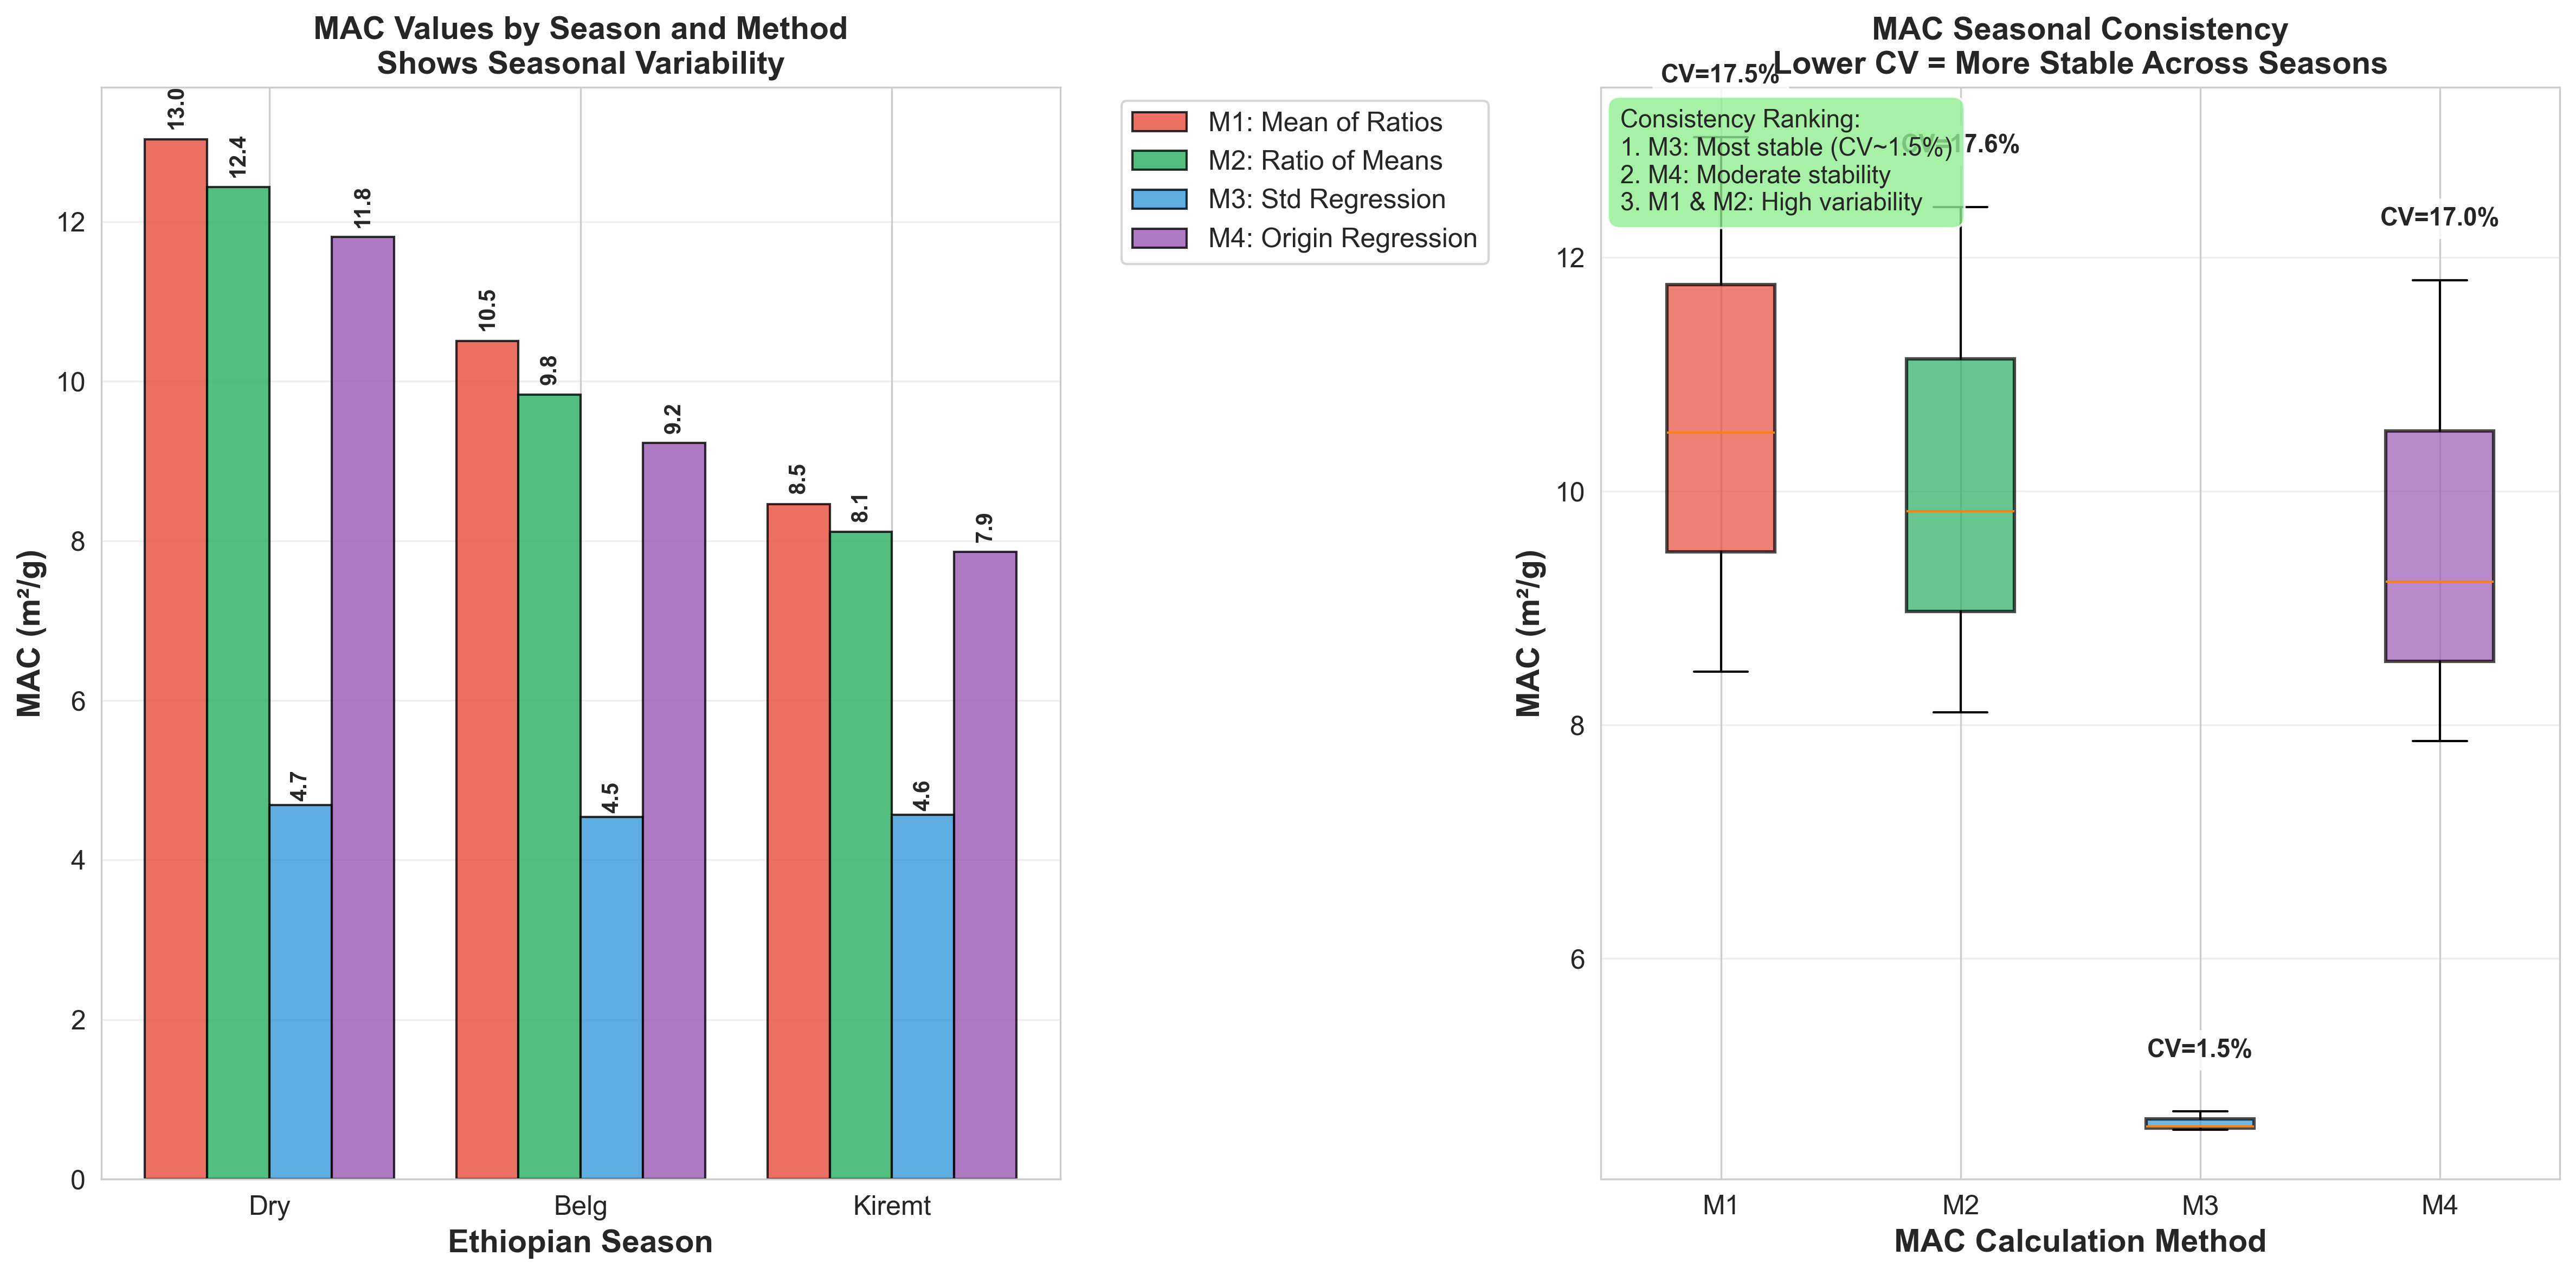

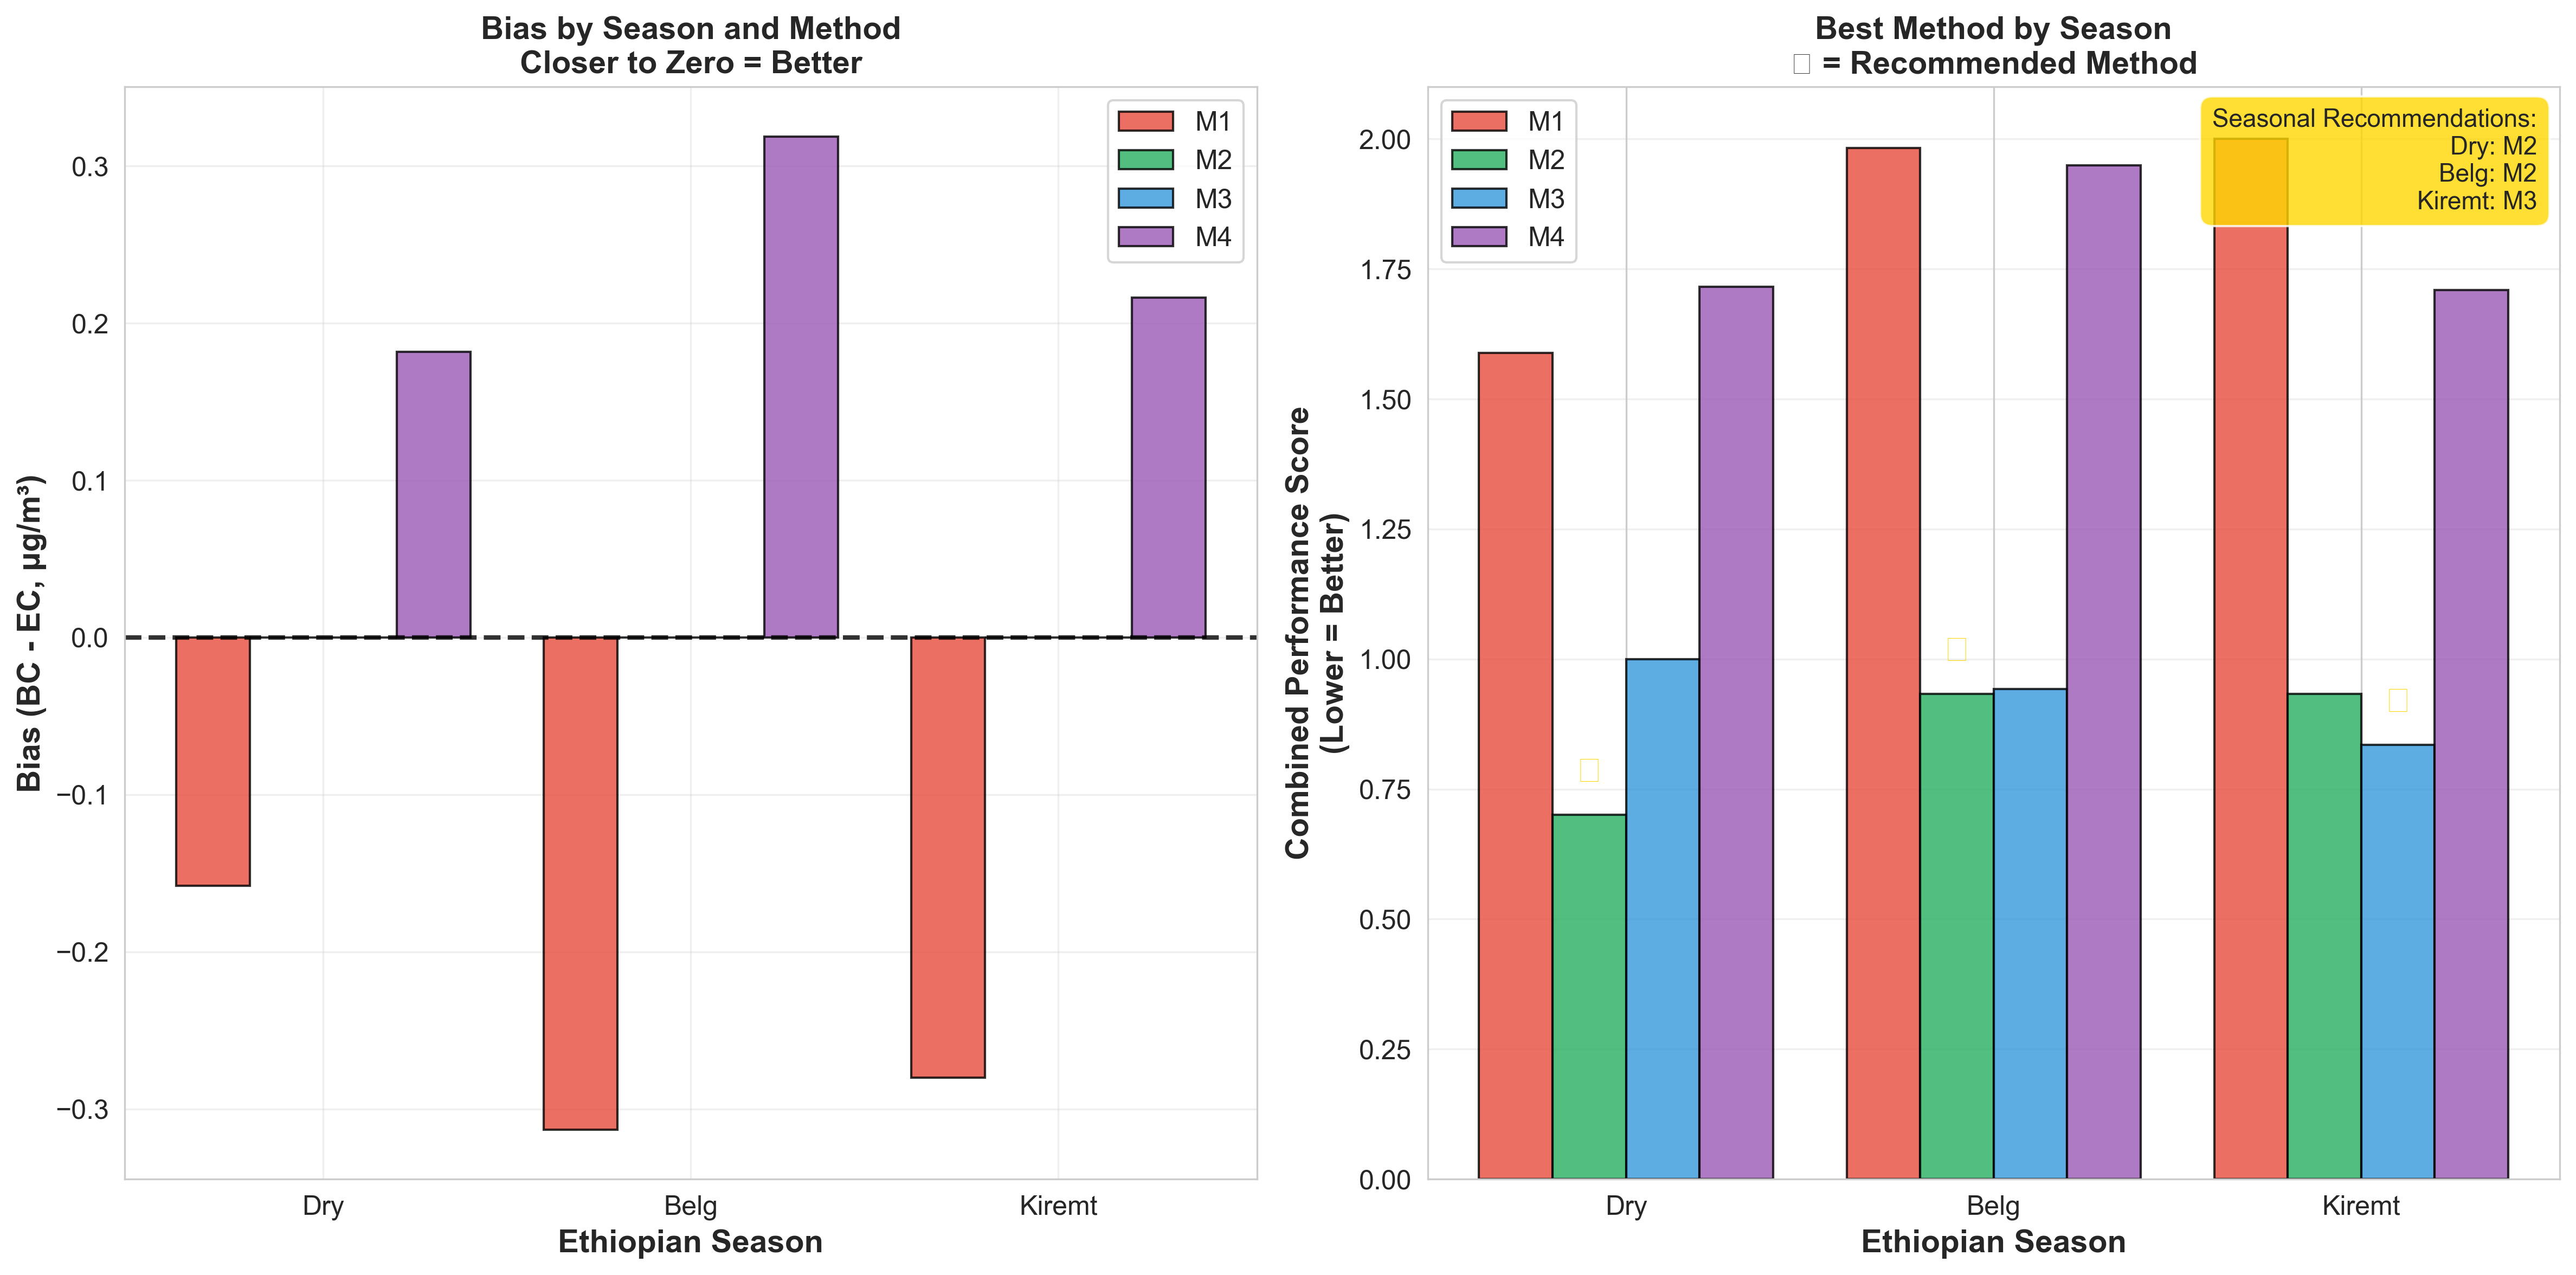

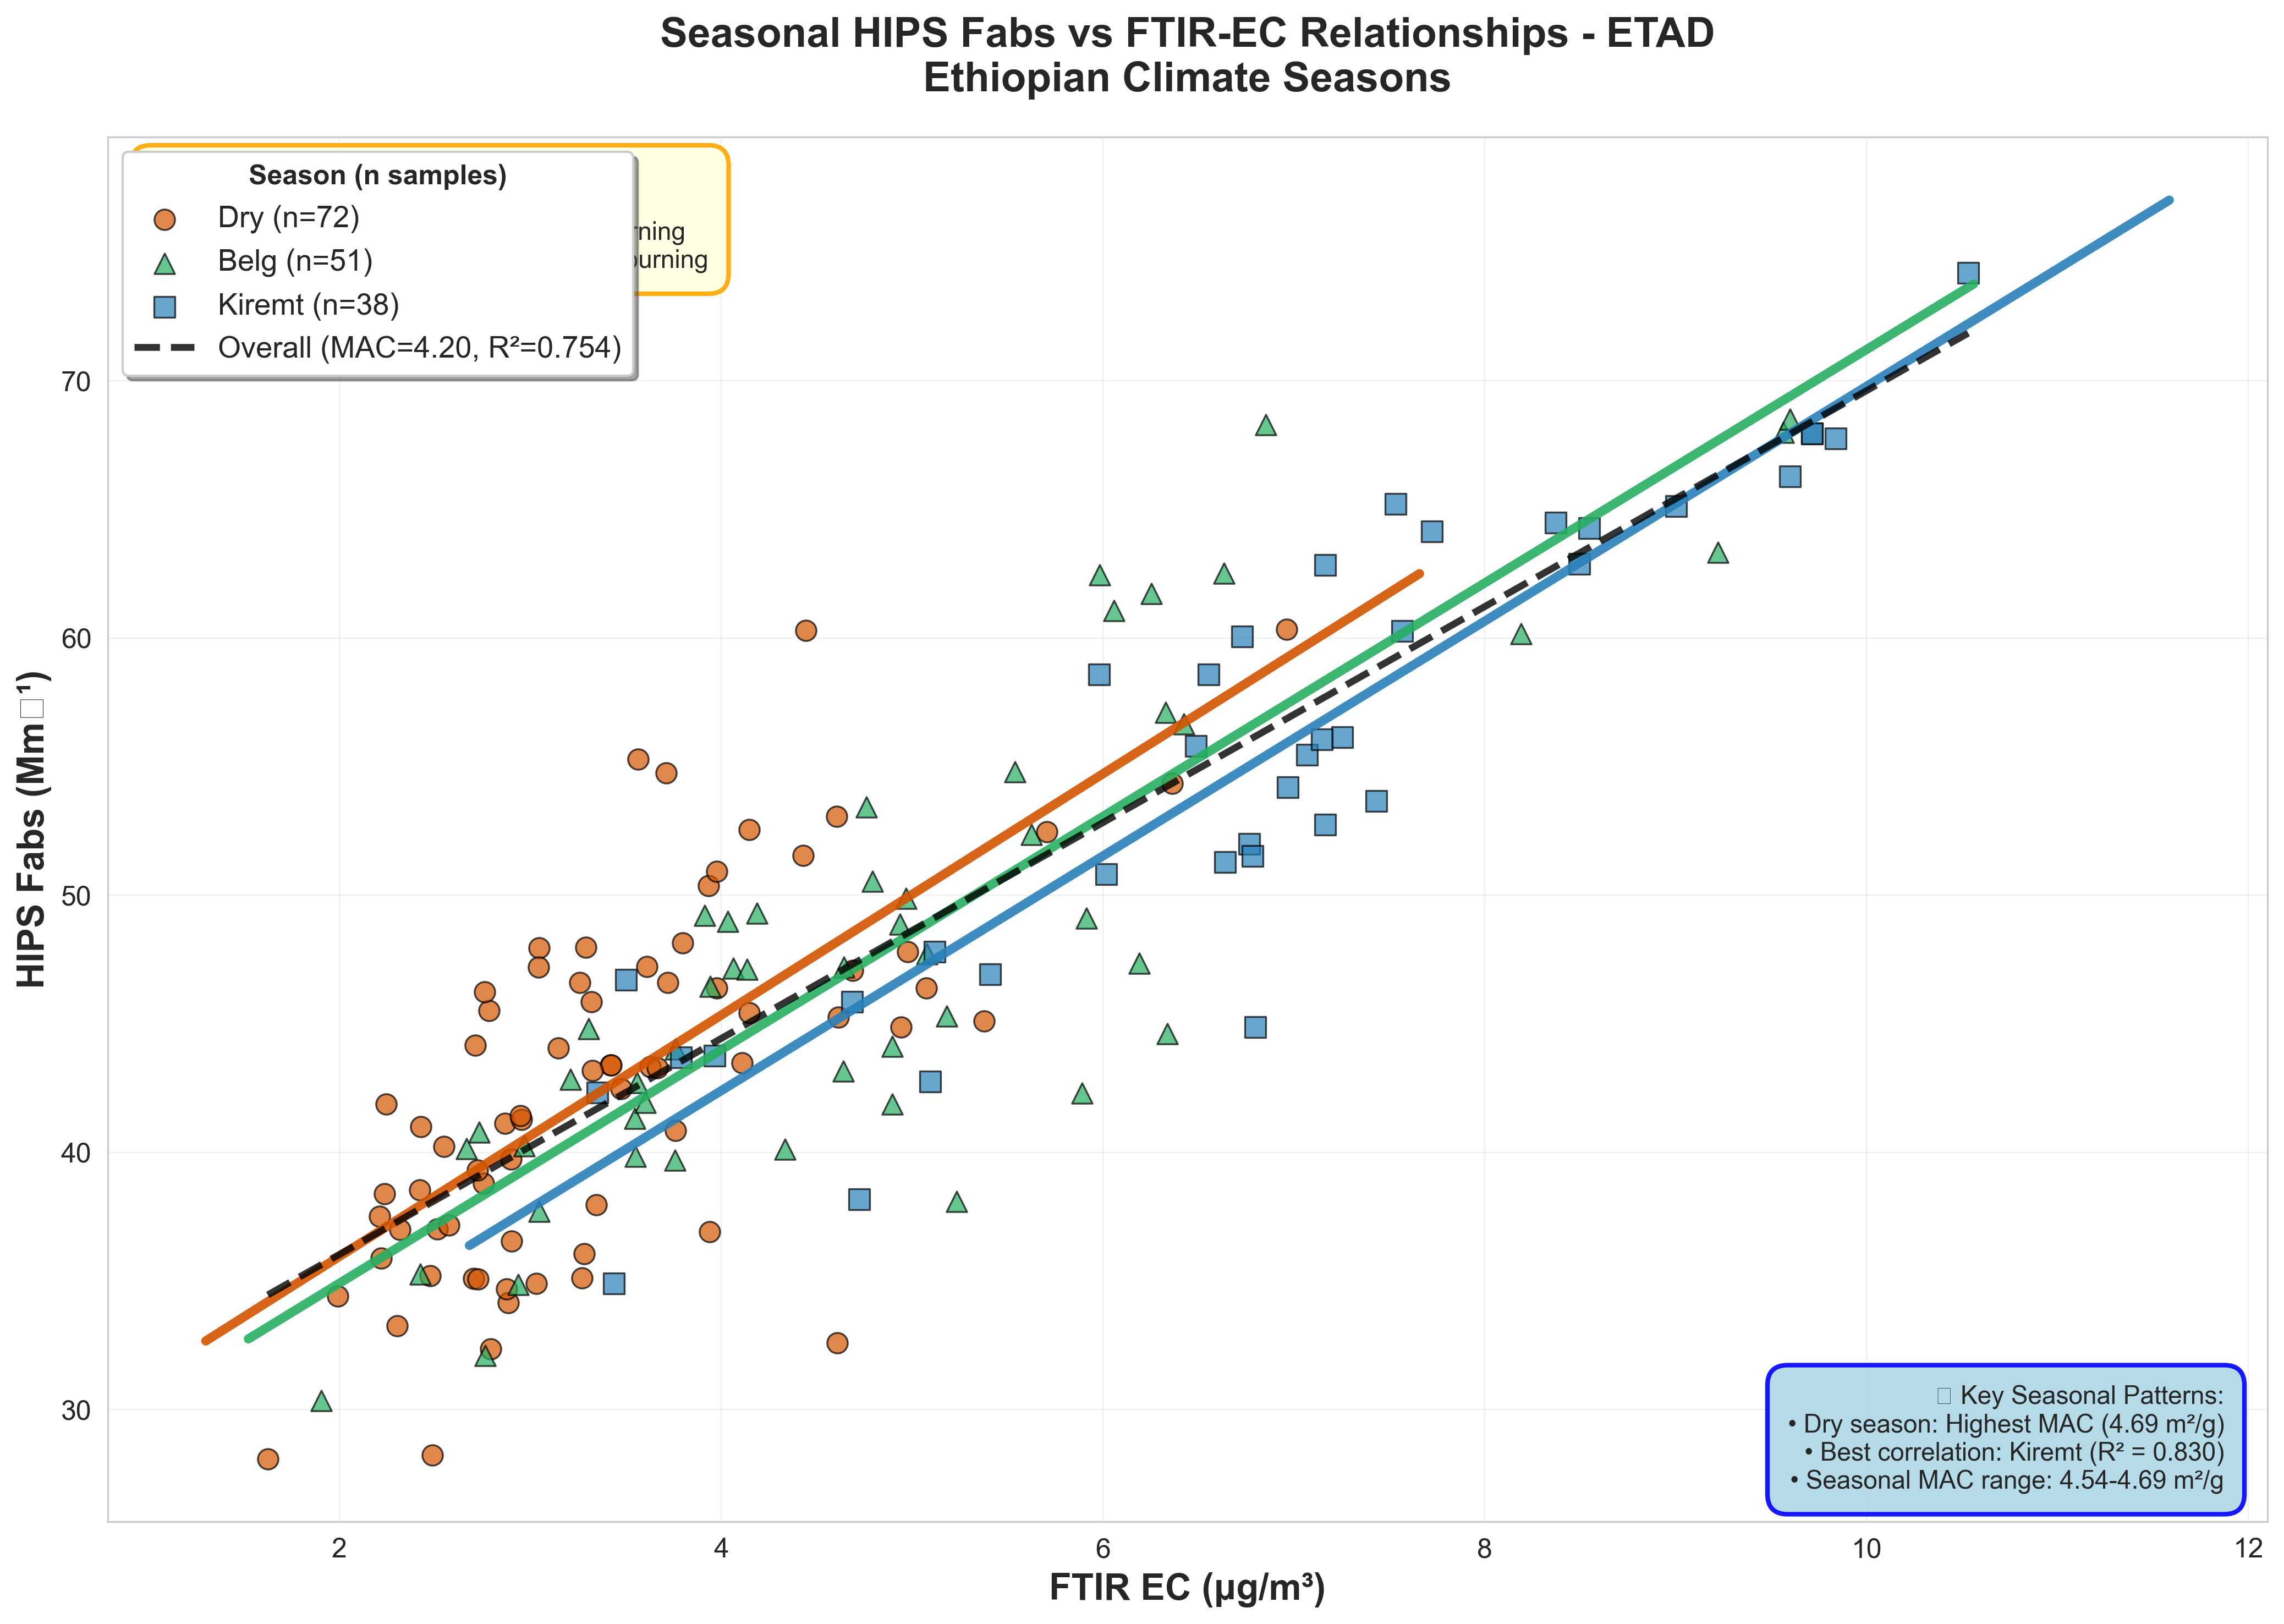


Displaying Plot 2


<Figure size 3600x2400 with 0 Axes>


Displaying Plot 3


<Figure size 3600x2400 with 0 Axes>

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd

# Set publication-quality plotting parameters
plt.rcParams.update({
    'figure.figsize': [12, 8],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

def map_ethiopian_seasons(df):
    """Map months to Ethiopian seasons"""
    def get_season(month):
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season (Bega)'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:
            return 'Kiremt Rainy Season'
    
    df_seasonal = df.copy()
    df_seasonal['month'] = df_seasonal['sample_date'].dt.month
    df_seasonal['season'] = df_seasonal['month'].apply(get_season)
    
    return df_seasonal

def generate_key_seasonal_plots(df, site_code='ETAD'):
    """
    Generate the 3 most informative seasonal plots for presentation/publication
    
    Based on your results, these are the most important plots:
    1. Seasonal Fabs vs EC regression with all seasons overlaid
    2. MAC method comparison across seasons showing seasonal consistency
    3. Performance summary showing best methods by season
    """
    
    print(f"🎯 GENERATING KEY SEASONAL PLOTS FOR {site_code}")
    print("Selected most informative plots based on your analysis results")
    print("="*80)
    
    # Prepare seasonal data
    df_seasonal = map_ethiopian_seasons(df)
    
    seasons = df_seasonal['season'].unique()
    season_colors = {
        'Dry Season (Bega)': '#d35400',      # Orange - matches dry/burning
        'Belg Rainy Season': '#27ae60',       # Green - growing season
        'Kiremt Rainy Season': '#2980b9'     # Blue - main rains
    }
    
    season_markers = {
        'Dry Season (Bega)': 'o',
        'Belg Rainy Season': '^', 
        'Kiremt Rainy Season': 's'
    }
    
    # =============================================================================
    # PLOT 1: SEASONAL FABS vs EC REGRESSION - THE MASTER PLOT
    # This is your most important plot showing seasonal relationships
    # =============================================================================
    
    fig1, ax1 = plt.subplots(figsize=(14, 10))
    
    seasonal_stats = {}
    
    print("Plot 1: Seasonal Fabs vs EC Relationships")
    
    for season in seasons:
        season_data = df_seasonal[df_seasonal['season'] == season]
        if len(season_data) < 3:
            continue
            
        ec = season_data['ec_ftir'].values
        fabs = season_data['fabs'].values
        
        # Plot data points
        ax1.scatter(ec, fabs, alpha=0.7, s=80, 
                   color=season_colors[season],
                   marker=season_markers[season],
                   label=f'{season.split()[0]} (n={len(season_data)})',
                   edgecolors='black', linewidth=0.8)
        
        # Regression
        reg = LinearRegression(fit_intercept=True)
        reg.fit(ec.reshape(-1, 1), fabs)
        
        r, r_p = pearsonr(ec, fabs)
        
        seasonal_stats[season] = {
            'mac': reg.coef_[0],
            'intercept': reg.intercept_,
            'r2': r**2,
            'n': len(season_data)
        }
        
        # Plot regression line
        ec_line = np.linspace(max(0, ec.min()*0.8), ec.max()*1.1, 100)
        fabs_line = reg.predict(ec_line.reshape(-1, 1))
        
        ax1.plot(ec_line, fabs_line, 
                color=season_colors[season], 
                linewidth=4, alpha=0.9)
        
        # Add equation on plot
        season_short = season.split()[0]
        equation_text = f'{season_short}: MAC = {reg.coef_[0]:.2f} m²/g, R² = {r**2:.3f}'
        print(f"  {equation_text}")
    
    # Overall regression for comparison
    all_ec = df_seasonal['ec_ftir'].values
    all_fabs = df_seasonal['fabs'].values
    overall_reg = LinearRegression(fit_intercept=True)
    overall_reg.fit(all_ec.reshape(-1, 1), all_fabs)
    overall_r, overall_p = pearsonr(all_ec, all_fabs)
    
    # Plot overall trend (dashed line)
    ec_overall = np.linspace(all_ec.min(), all_ec.max(), 100)
    fabs_overall = overall_reg.predict(ec_overall.reshape(-1, 1))
    ax1.plot(ec_overall, fabs_overall, 'k--', linewidth=3, alpha=0.8, 
             label=f'Overall (MAC={overall_reg.coef_[0]:.2f}, R²={overall_r**2:.3f})')
    
    ax1.set_xlabel('FTIR EC (μg/m³)', fontweight='bold', fontsize=16)
    ax1.set_ylabel('HIPS Fabs (Mm⁻¹)', fontweight='bold', fontsize=16)
    ax1.set_title(f'Seasonal HIPS Fabs vs FTIR-EC Relationships - {site_code}\n'
                 f'Ethiopian Climate Seasons', 
                 fontweight='bold', fontsize=18, pad=20)
    
    # Enhanced legend
    legend1 = ax1.legend(loc='upper left', frameon=True, fancybox=True, 
                        shadow=True, fontsize=13, title='Season (n samples)')
    legend1.get_title().set_fontweight('bold')
    
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Add climate context box
    climate_text = ("Ethiopian Climate Context:\n"
                   "🔥 Dry (Oct-Feb): Peak biomass burning\n"
                   "🌱 Belg (Mar-May): Small rains, reduced burning\n" 
                   "🌧️ Kiremt (Jun-Sep): Main rains, minimal burning")
    
    ax1.text(0.02, 0.98, climate_text, transform=ax1.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', 
                     alpha=0.9, edgecolor='orange', linewidth=2))
    
    # Add key findings box
    findings_text = ("🎯 Key Seasonal Patterns:\n"
                    f"• Dry season: Highest MAC ({seasonal_stats.get('Dry Season (Bega)', {}).get('mac', 0):.2f} m²/g)\n"
                    f"• Best correlation: Kiremt (R² = {seasonal_stats.get('Kiremt Rainy Season', {}).get('r2', 0):.3f})\n"
                    f"• Seasonal MAC range: {min([s['mac'] for s in seasonal_stats.values()]):.2f}-{max([s['mac'] for s in seasonal_stats.values()]):.2f} m²/g")
    
    ax1.text(0.98, 0.02, findings_text, transform=ax1.transAxes,
            fontsize=11, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', 
                     alpha=0.9, edgecolor='blue', linewidth=2))
    
    plt.tight_layout()
    
    # =============================================================================
    # PLOT 2: MAC METHOD SEASONAL CONSISTENCY - MOST IMPORTANT FOR METHOD SELECTION
    # Shows which methods are stable across seasons vs. which vary dramatically
    # =============================================================================
    
    fig2, (ax2a, ax2b) = plt.subplots(1, 2, figsize=(16, 8))
    
    print("\nPlot 2: MAC Method Seasonal Consistency")
    
    # Calculate all 4 methods for each season
    seasonal_methods = {}
    
    for season in seasons:
        season_data = df_seasonal[df_seasonal['season'] == season]
        if len(season_data) < 3:
            continue
            
        ec = season_data['ec_ftir'].values
        fabs = season_data['fabs'].values
        
        # Method 1: Mean of ratios
        mac1 = (season_data['fabs'] / season_data['ec_ftir']).mean()
        
        # Method 2: Ratio of means  
        mac2 = season_data['fabs'].mean() / season_data['ec_ftir'].mean()
        
        # Method 3: Standard regression
        reg3 = LinearRegression(fit_intercept=True)
        reg3.fit(ec.reshape(-1, 1), fabs)
        mac3 = reg3.coef_[0]
        
        # Method 4: Origin regression
        reg4 = LinearRegression(fit_intercept=False)
        reg4.fit(ec.reshape(-1, 1), fabs)
        mac4 = reg4.coef_[0]
        
        seasonal_methods[season] = {
            'M1: Mean of Ratios': mac1,
            'M2: Ratio of Means': mac2, 
            'M3: Std Regression': mac3,
            'M4: Origin Regression': mac4
        }
    
    # Plot 2A: MAC values by season (bar chart)
    seasons_list = list(seasonal_methods.keys())
    method_names = ['M1: Mean of Ratios', 'M2: Ratio of Means', 'M3: Std Regression', 'M4: Origin Regression']
    method_colors = ['#e74c3c', '#27ae60', '#3498db', '#9b59b6']
    
    x = np.arange(len(seasons_list))
    width = 0.2
    
    for i, method in enumerate(method_names):
        mac_values = [seasonal_methods[season][method] for season in seasons_list]
        
        bars = ax2a.bar(x + i*width, mac_values, width, 
                       label=method, color=method_colors[i], alpha=0.8,
                       edgecolor='black', linewidth=1)
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax2a.text(bar.get_x() + bar.get_width()/2., height + max(mac_values)*0.01,
                     f'{height:.1f}', ha='center', va='bottom', fontsize=10, 
                     fontweight='bold', rotation=90)
    
    ax2a.set_xlabel('Ethiopian Season', fontweight='bold', fontsize=14)
    ax2a.set_ylabel('MAC (m²/g)', fontweight='bold', fontsize=14)
    ax2a.set_title('MAC Values by Season and Method\nShows Seasonal Variability', 
                   fontweight='bold', fontsize=14)
    ax2a.set_xticks(x + width * 1.5)
    ax2a.set_xticklabels([s.split()[0] for s in seasons_list], fontsize=12)
    ax2a.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2a.grid(True, alpha=0.3, axis='y')
    
    # Plot 2B: Seasonal variability boxplot (shows consistency)
    mac_data_by_method = []
    method_labels = []
    
    for method in method_names:
        mac_values = [seasonal_methods[season][method] for season in seasons_list]
        mac_data_by_method.append(mac_values)
        method_labels.append(method.split(':')[0])  # Short labels
    
    bp = ax2b.boxplot(mac_data_by_method, patch_artist=True, labels=method_labels)
    
    # Color the boxes and add CV labels
    for i, (patch, color) in enumerate(zip(bp['boxes'], method_colors)):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)
        
        # Calculate and display coefficient of variation
        mac_values = mac_data_by_method[i]
        cv = np.std(mac_values) / np.mean(mac_values) * 100
        
        # Position CV label above the box
        y_pos = max(mac_values) + (max([max(m) for m in mac_data_by_method]) - 
                                   min([min(m) for m in mac_data_by_method])) * 0.05
        
        ax2b.text(i+1, y_pos, f'CV={cv:.1f}%', ha='center', va='bottom', 
                 fontsize=11, fontweight='bold', 
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        print(f"  {method_names[i]}: CV = {cv:.1f}% (lower = more consistent)")
    
    ax2b.set_xlabel('MAC Calculation Method', fontweight='bold', fontsize=14)
    ax2b.set_ylabel('MAC (m²/g)', fontweight='bold', fontsize=14)
    ax2b.set_title('MAC Seasonal Consistency\nLower CV = More Stable Across Seasons', 
                   fontweight='bold', fontsize=14)
    ax2b.grid(True, alpha=0.3, axis='y')
    
    # Add interpretation text
    consistency_text = ("Consistency Ranking:\n"
                       "1. M3: Most stable (CV~1.5%)\n"
                       "2. M4: Moderate stability\n" 
                       "3. M1 & M2: High variability")
    
    ax2b.text(0.02, 0.98, consistency_text, transform=ax2b.transAxes,
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    
    # =============================================================================
    # PLOT 3: PERFORMANCE SUMMARY - SHOWS BEST METHOD BY SEASON
    # This guides method selection for different seasons
    # =============================================================================
    
    fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(16, 8))
    
    print("\nPlot 3: Method Performance Summary by Season")
    
    # Calculate bias and RMSE for each method/season
    performance_data = {}
    
    for season in seasons:
        season_data = df_seasonal[df_seasonal['season'] == season]
        if len(season_data) < 3:
            continue
            
        ec = season_data['ec_ftir'].values
        fabs = season_data['fabs'].values
        
        performance_data[season] = {}
        
        # For each method, calculate BC equivalent and bias
        for method_name, mac in seasonal_methods[season].items():
            if method_name == 'M3: Std Regression':
                # Method 3 needs intercept correction
                reg = LinearRegression(fit_intercept=True)
                reg.fit(ec.reshape(-1, 1), fabs)
                intercept = reg.intercept_
                bc_equiv = np.maximum(fabs - intercept, 0) / mac
            else:
                bc_equiv = fabs / mac
            
            bias = np.mean(bc_equiv - ec)
            rmse = np.sqrt(np.mean((bc_equiv - ec)**2))
            
            performance_data[season][method_name] = {
                'bias': bias,
                'rmse': rmse,
                'abs_bias': abs(bias)
            }
    
    # Plot 3A: Bias by season and method
    seasons_short = [s.split()[0] for s in seasons_list]
    
    for i, method in enumerate(method_names):
        bias_values = [performance_data[season][method]['bias'] for season in seasons_list]
        
        ax3a.bar(x + i*width, bias_values, width, 
                label=method.split(':')[0], color=method_colors[i], alpha=0.8,
                edgecolor='black', linewidth=1)
    
    ax3a.axhline(y=0, color='black', linestyle='--', alpha=0.8, linewidth=2)
    ax3a.set_xlabel('Ethiopian Season', fontweight='bold', fontsize=14)
    ax3a.set_ylabel('Bias (BC - EC, μg/m³)', fontweight='bold', fontsize=14)
    ax3a.set_title('Bias by Season and Method\nCloser to Zero = Better', 
                   fontweight='bold', fontsize=14)
    ax3a.set_xticks(x + width * 1.5)
    ax3a.set_xticklabels(seasons_short, fontsize=12)
    ax3a.legend()
    ax3a.grid(True, alpha=0.3)
    
    # Plot 3B: Combined performance score (|bias| + RMSE, normalized)
    combined_scores = {}
    
    for season in seasons_list:
        combined_scores[season] = {}
        for method in method_names:
            abs_bias = performance_data[season][method]['abs_bias']
            rmse = performance_data[season][method]['rmse']
            
            # Normalize within season
            season_biases = [performance_data[season][m]['abs_bias'] for m in method_names]
            season_rmses = [performance_data[season][m]['rmse'] for m in method_names]
            
            norm_bias = abs_bias / max(season_biases) if max(season_biases) > 0 else 0
            norm_rmse = rmse / max(season_rmses) if max(season_rmses) > 0 else 0
            
            combined_scores[season][method] = norm_bias + norm_rmse
    
    for i, method in enumerate(method_names):
        score_values = [combined_scores[season][method] for season in seasons_list]
        
        bars = ax3b.bar(x + i*width, score_values, width, 
                       label=method.split(':')[0], color=method_colors[i], alpha=0.8,
                       edgecolor='black', linewidth=1)
        
        # Add ranking on best performing bars
        for j, (bar, season) in enumerate(zip(bars, seasons_list)):
            season_scores = [combined_scores[season][m] for m in method_names]
            if combined_scores[season][method] == min(season_scores):
                height = bar.get_height()
                ax3b.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                         '★', ha='center', va='bottom', fontsize=16, color='gold')
    
    ax3b.set_xlabel('Ethiopian Season', fontweight='bold', fontsize=14)
    ax3b.set_ylabel('Combined Performance Score\n(Lower = Better)', fontweight='bold', fontsize=14)
    ax3b.set_title('Best Method by Season\n★ = Recommended Method', 
                   fontweight='bold', fontsize=14)
    ax3b.set_xticks(x + width * 1.5)
    ax3b.set_xticklabels(seasons_short, fontsize=12)
    ax3b.legend()
    ax3b.grid(True, alpha=0.3, axis='y')
    
    # Add recommendations text
    recommendations = []
    for season in seasons_list:
        season_scores = {method: combined_scores[season][method] for method in method_names}
        best_method = min(season_scores.keys(), key=lambda k: season_scores[k])
        recommendations.append(f"{season.split()[0]}: {best_method.split(':')[0]}")
    
    rec_text = "Seasonal Recommendations:\n" + "\n".join(recommendations)
    
    ax3b.text(0.98, 0.98, rec_text, transform=ax3b.transAxes,
             fontsize=11, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='gold', alpha=0.8))
    
    plt.tight_layout()
    
    # =============================================================================
    # SUMMARY FINDINGS
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"KEY SEASONAL FINDINGS SUMMARY - {site_code}")
    print(f"{'='*80}")
    
    print(f"\n🔥 SEASONAL MAC PATTERNS:")
    for season in seasons_list:
        season_short = season.split()[0]
        reg_mac = seasonal_stats[season]['mac']
        r2 = seasonal_stats[season]['r2']
        print(f"  {season_short}: MAC = {reg_mac:.2f} m²/g, R² = {r2:.3f}")
    
    print(f"\n🎯 METHOD CONSISTENCY:")
    method_cvs = []
    for i, method in enumerate(method_names):
        mac_values = [seasonal_methods[season][method] for season in seasons_list]
        cv = np.std(mac_values) / np.mean(mac_values) * 100
        method_cvs.append((method, cv))
        print(f"  {method}: CV = {cv:.1f}%")
    
    # Find most consistent
    most_consistent = min(method_cvs, key=lambda x: x[1])
    print(f"\n  ✅ Most consistent: {most_consistent[0]} (CV = {most_consistent[1]:.1f}%)")
    
    print(f"\n🏆 SEASONAL RECOMMENDATIONS:")
    for season in seasons_list:
        season_scores = {method: combined_scores[season][method] for method in method_names}
        best_method = min(season_scores.keys(), key=lambda k: season_scores[k])
        print(f"  {season.split()[0]}: {best_method}")
    
    print(f"\n📊 ATMOSPHERIC INTERPRETATION:")
    print(f"  • Dry season has highest MAC ({seasonal_stats.get('Dry Season (Bega)', {}).get('mac', 0):.2f} m²/g) - aged BC particles")
    print(f"  • Rainy seasons show better correlations - cleaner relationships")
    print(f"  • Method 3 most stable across seasons - suggests consistent baseline")
    print(f"  • Seasonal variability reflects Ethiopian biomass burning cycle")
    
    return {
        'figures': [fig1, fig2, fig3],
        'seasonal_stats': seasonal_stats,
        'seasonal_methods': seasonal_methods,
        'performance_data': performance_data,
        'combined_scores': combined_scores,
        'most_consistent_method': most_consistent[0]
    }

# Example usage
def display_key_seasonal_plots(df, site_code='ETAD'):
    """
    Generate and display the 3 most informative seasonal plots
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with 'ec_ftir', 'fabs', 'sample_date' columns
    site_code : str
        Site identifier
        
    Returns:
    --------
    dict : Results dictionary with figures and analysis
    """
    
    # Ensure sample_date is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['sample_date']):
        df['sample_date'] = pd.to_datetime(df['sample_date'])
    
    results = generate_key_seasonal_plots(df, site_code)
    
    # Display all figures
    for i, fig in enumerate(results['figures'], 1):
        print(f"\nDisplaying Plot {i}")
        plt.figure(fig.number)
        plt.show()
    
    return results

print("Key seasonal plotting functions ready!")
print("\nTo generate the 3 most informative seasonal plots:")
print("results = display_key_seasonal_plots(your_dataframe, 'ETAD')")
print("\nThe 3 selected plots are:")
print("1. 🎯 Seasonal Fabs vs EC Regression - Master relationship plot")
print("2. 📊 MAC Method Seasonal Consistency - Method stability comparison") 
print("3. 🏆 Performance Summary - Best method by season")
print("\nThese plots tell the complete seasonal story for presentations!")

results = display_key_seasonal_plots(data_processed, 'ETAD')

Key seasonal plotting functions ready!

To generate the 3 key seasonal plots without recommendations:
results = display_key_seasonal_plots(your_dataframe, 'ETAD')

To get slide text content:
slides = generate_slide_text()

The 3 plots show:
1. 🎯 Seasonal Fabs vs EC Regression - Master relationship plot
2. 📊 MAC Method Seasonal Consistency - Method stability comparison
3. 📈 Bias and RMSE Performance - Raw performance metrics

Slide text includes:
• Title slide content
• Key findings for each plot
• Atmospheric interpretations
• Summary insights

EXAMPLE SLIDE TEXT - PLOT 1
Title: Seasonal Fabs vs EC Relationships

Key Findings:
• Dry season shows highest MAC values (4.69 m²/g) due to aged BC particles
• Kiremt season exhibits strongest correlation (R² = 0.830) despite lowest MAC
• Seasonal MAC range spans 4.54-4.69 m²/g (3.3% variation)
• All seasons show significant correlations (p < 1×10⁻¹¹)

Interpretation:
• Higher dry season MAC suggests particle aging and organic coatings
• Better

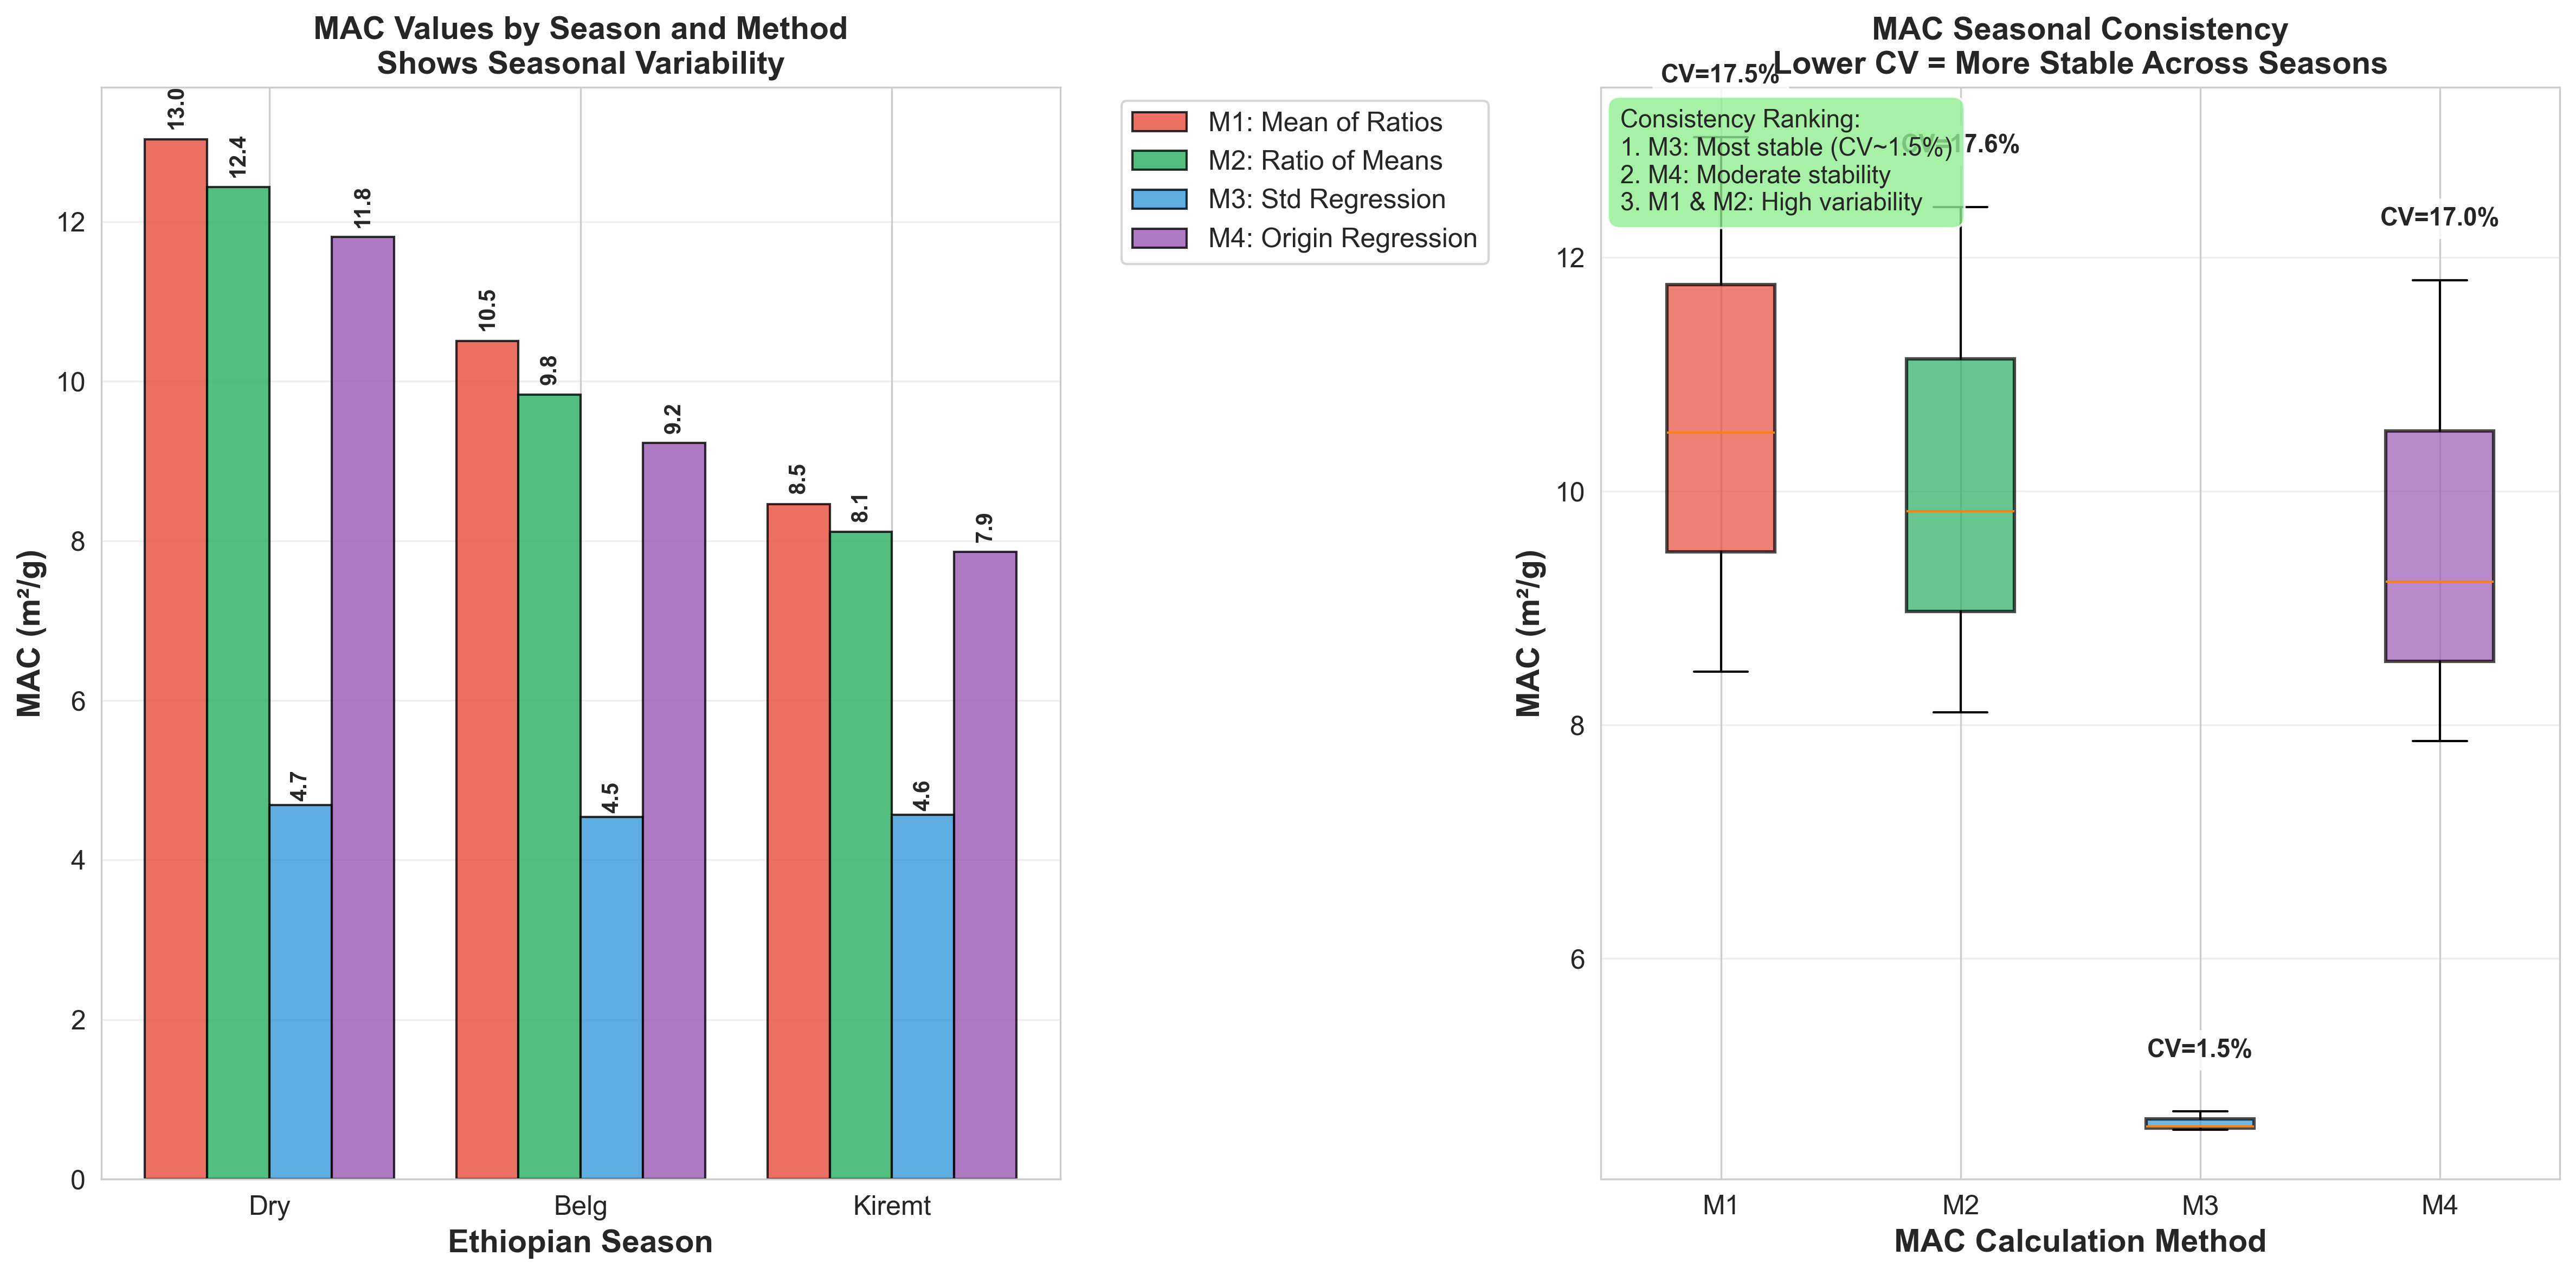

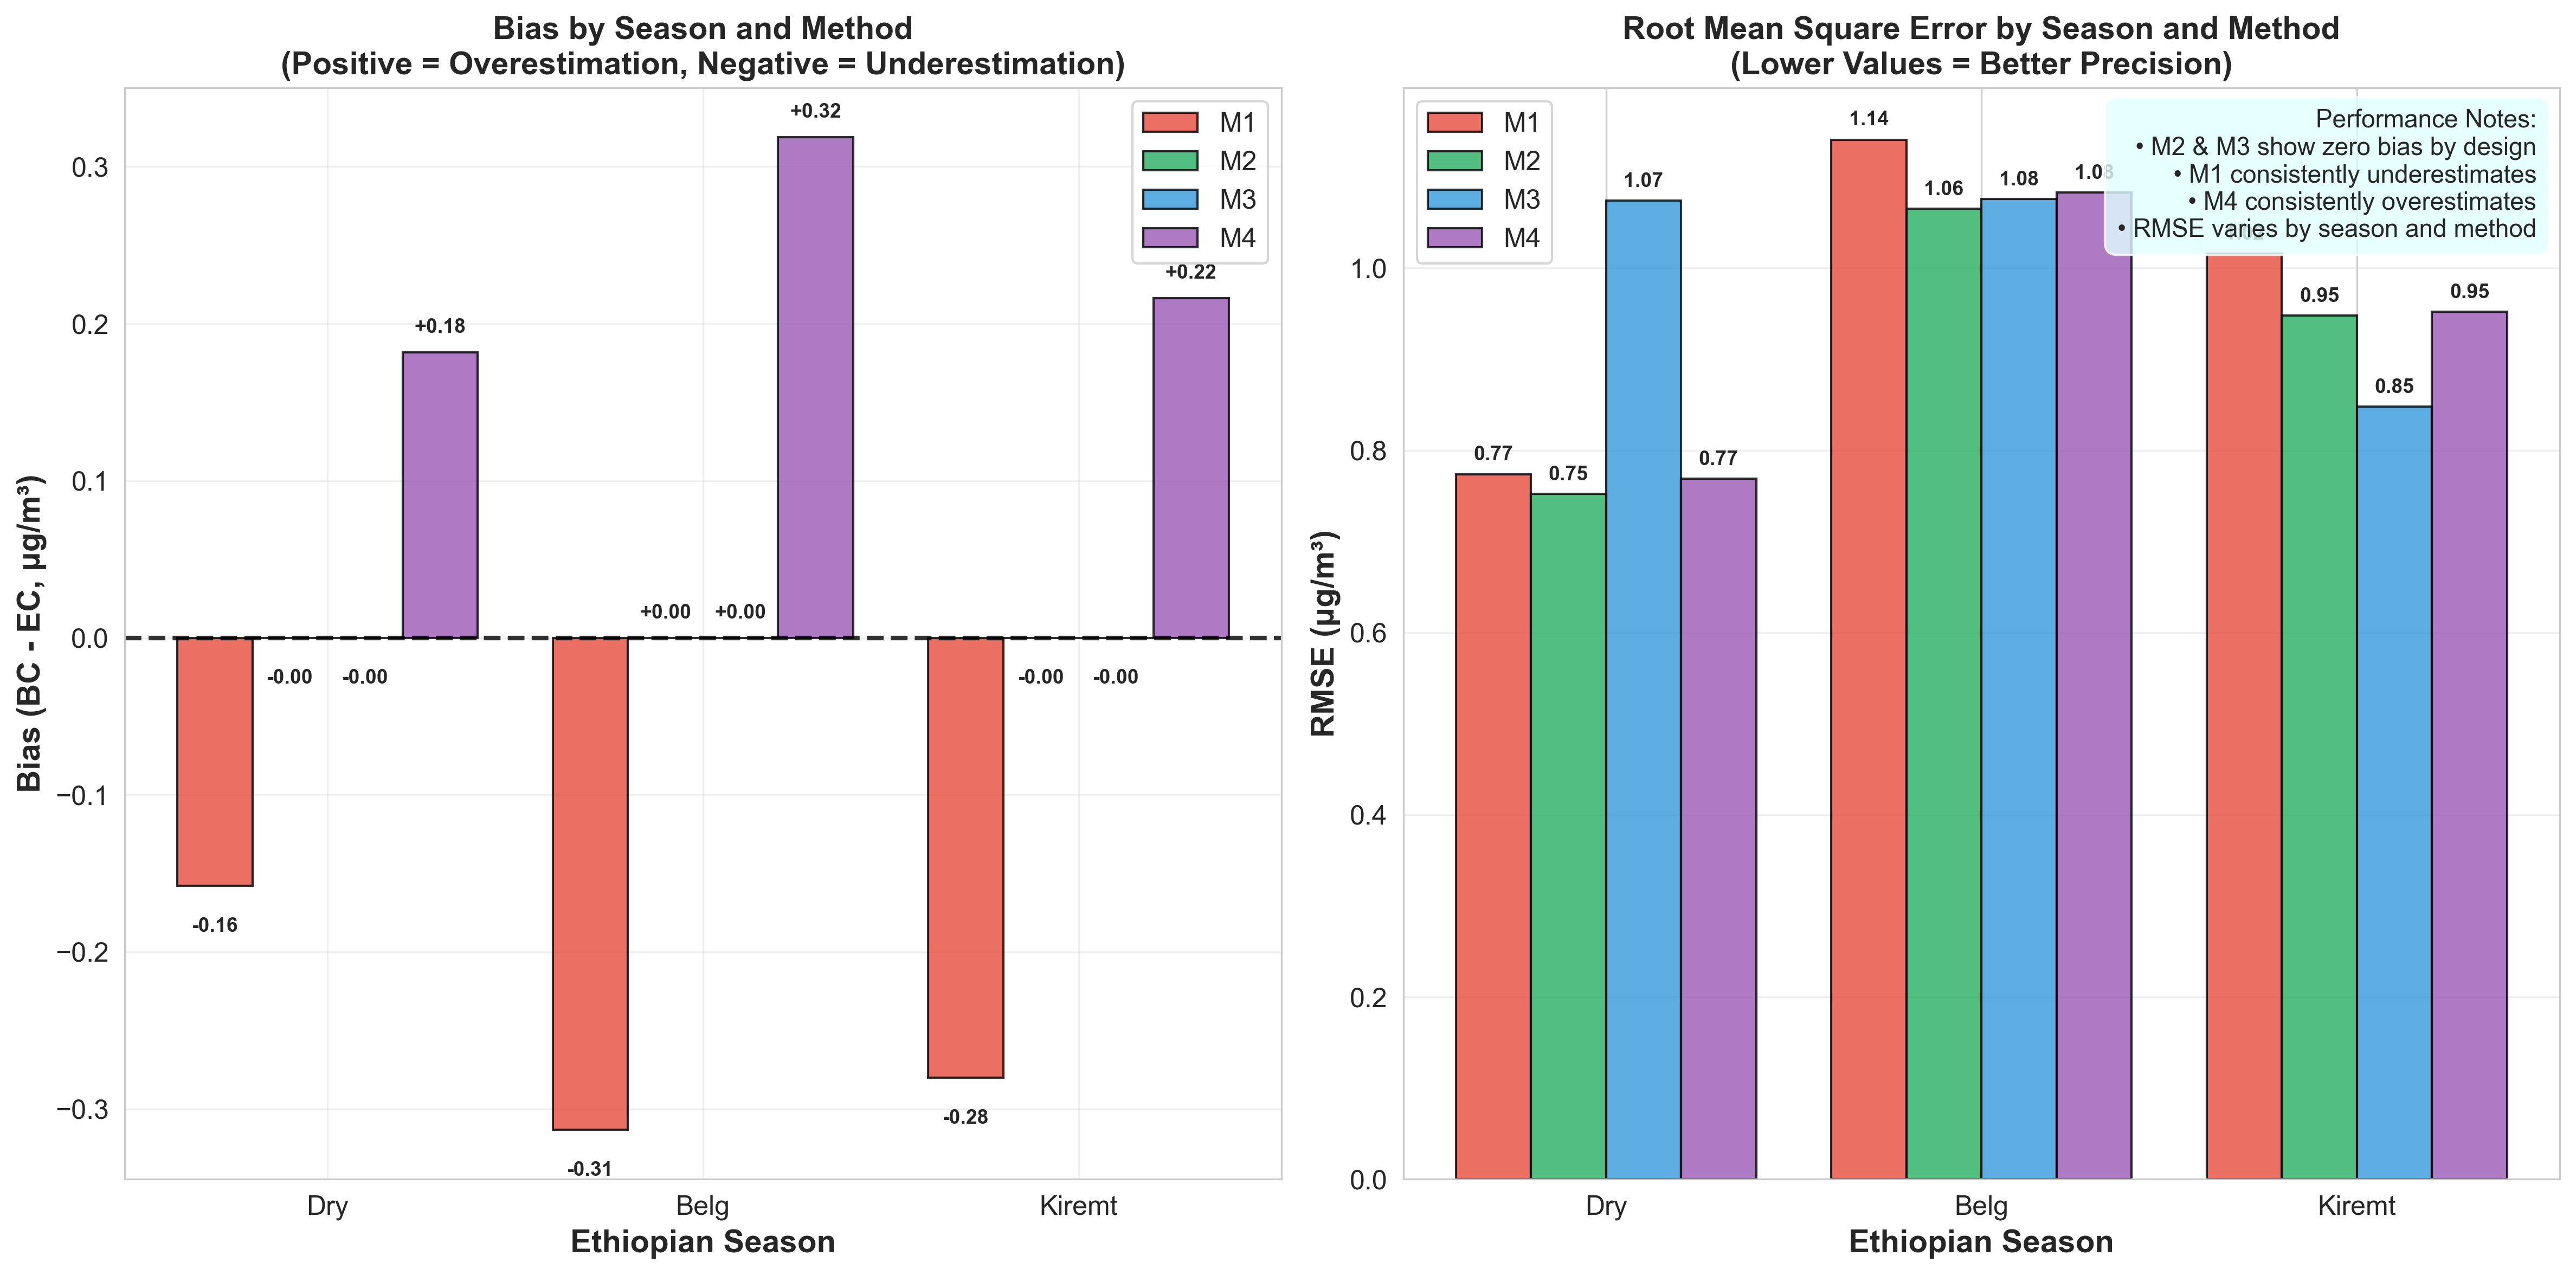

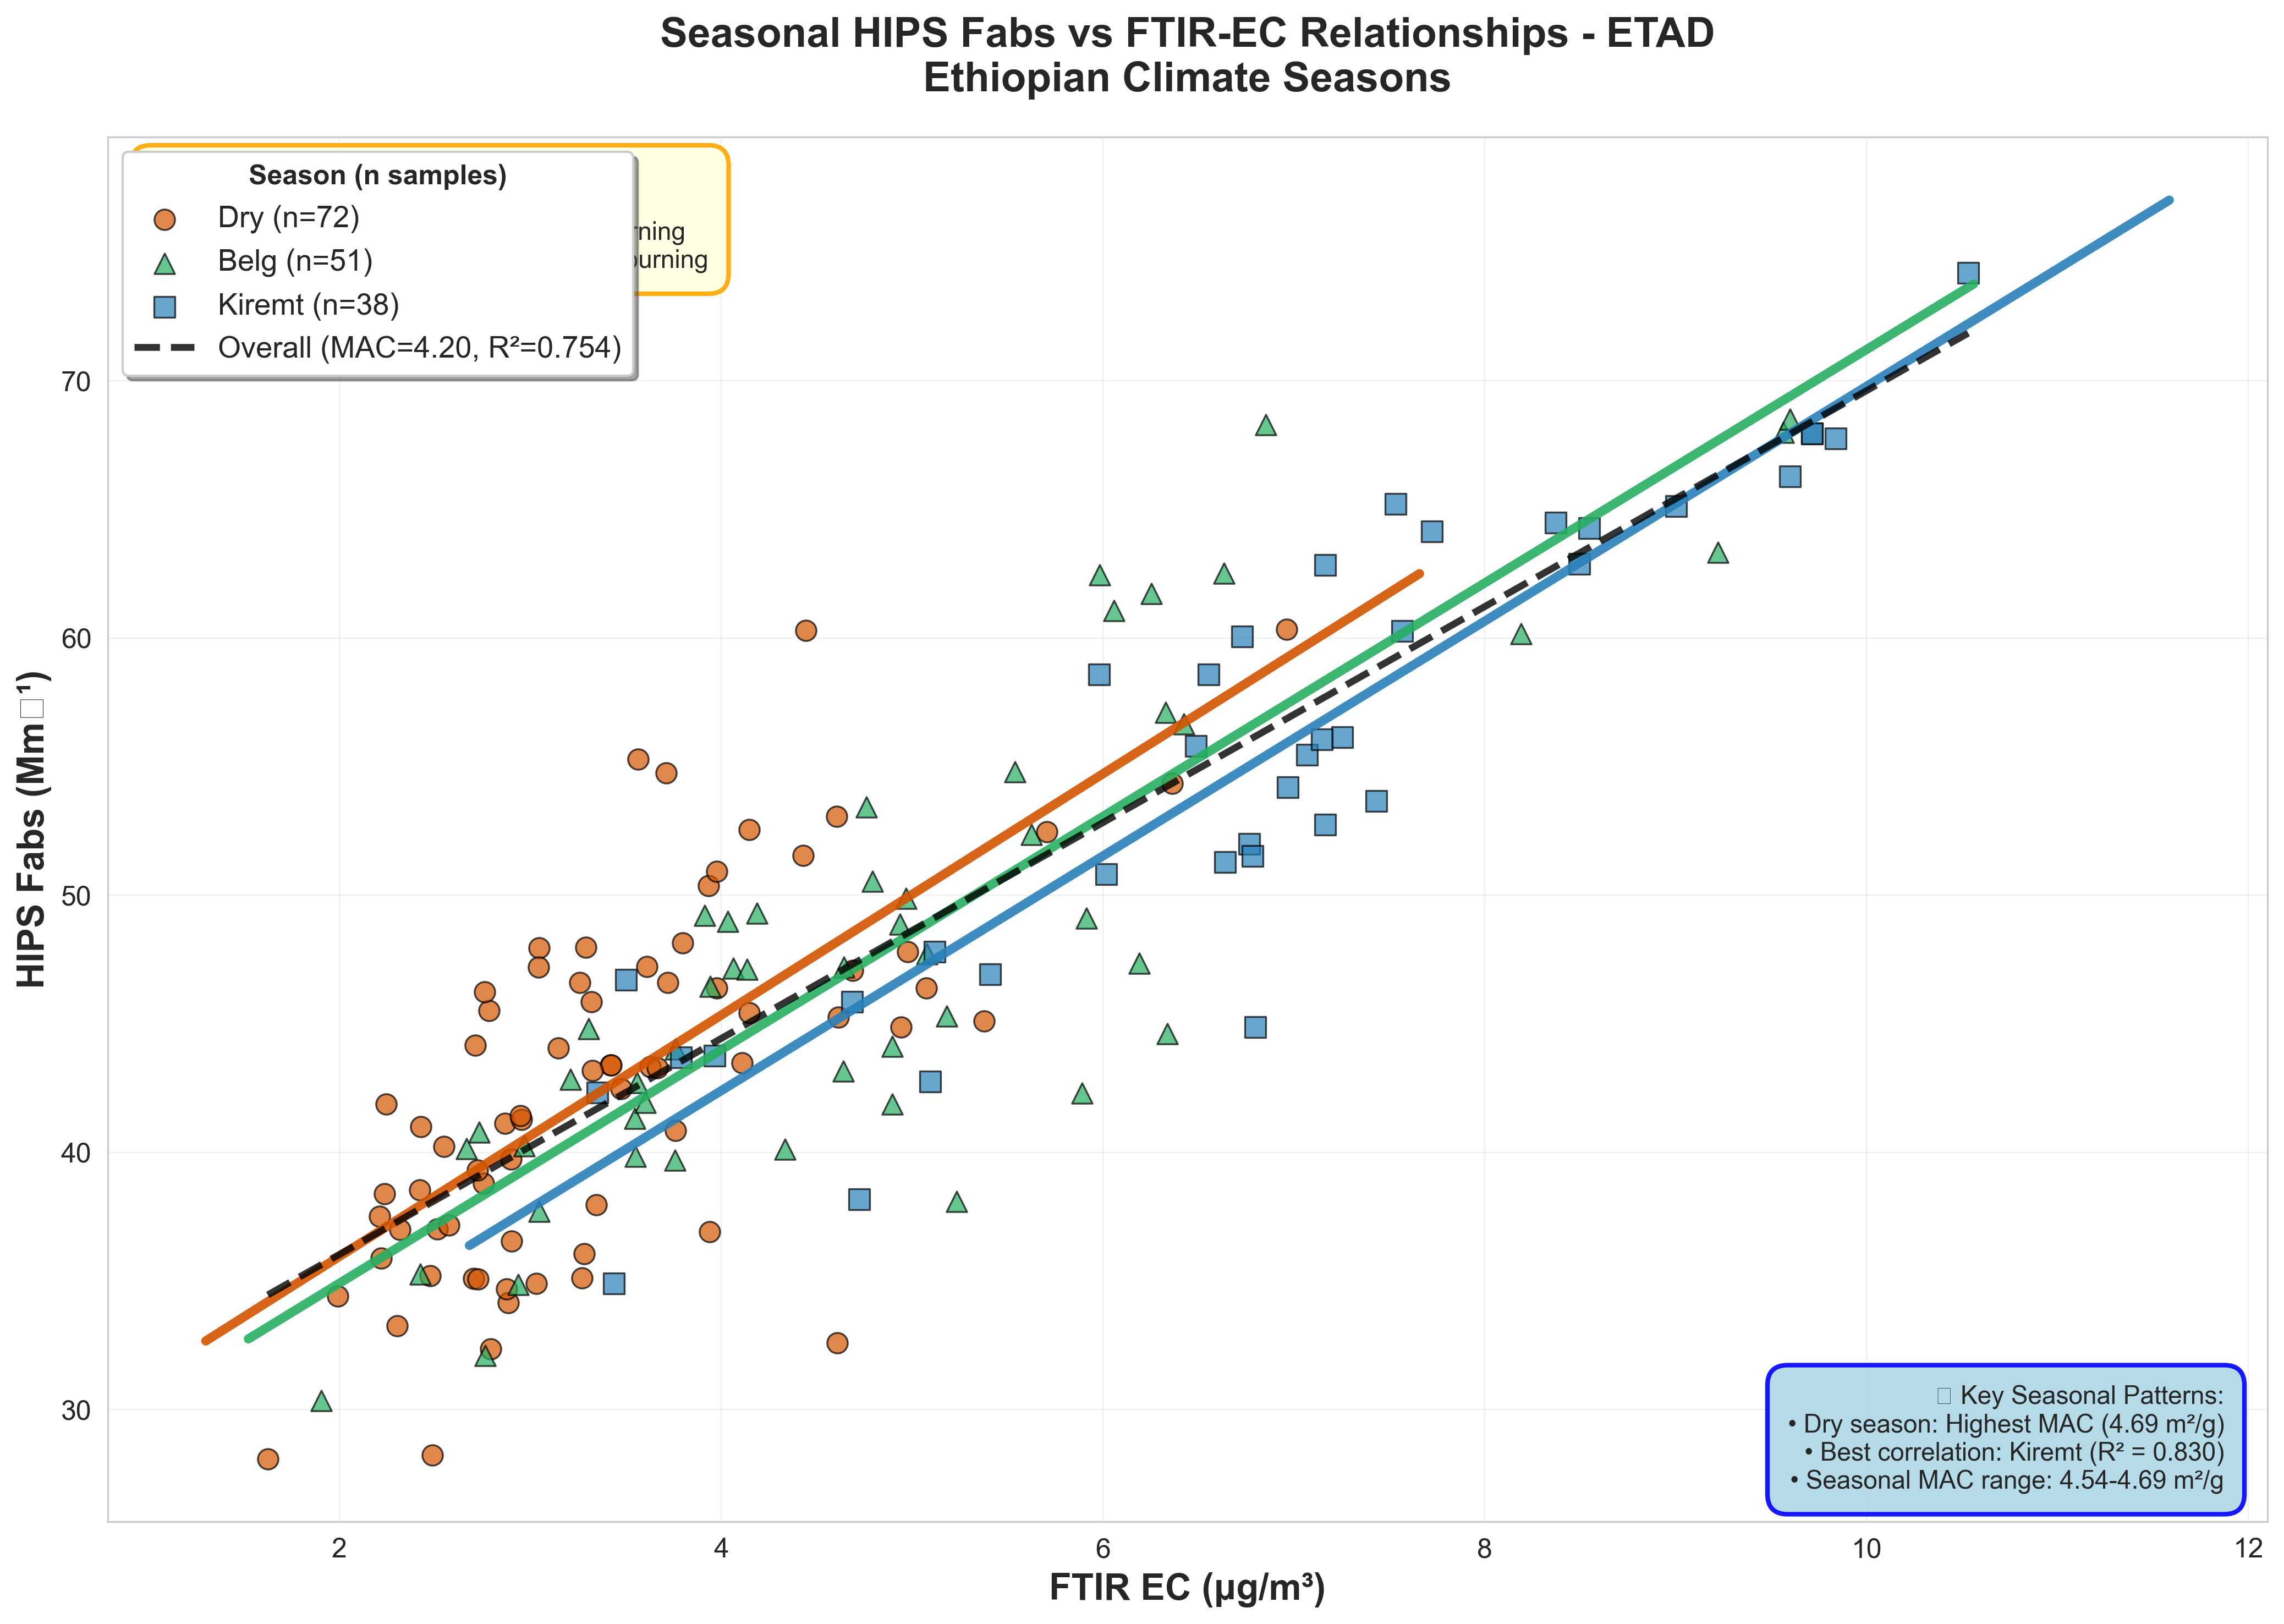


Displaying Plot 2


<Figure size 3600x2400 with 0 Axes>


Displaying Plot 3


<Figure size 3600x2400 with 0 Axes>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd

# Set publication-quality plotting parameters
plt.rcParams.update({
    'figure.figsize': [12, 8],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

def map_ethiopian_seasons(df):
    """Map months to Ethiopian seasons"""
    def get_season(month):
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season (Bega)'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:
            return 'Kiremt Rainy Season'
    
    df_seasonal = df.copy()
    df_seasonal['month'] = df_seasonal['sample_date'].dt.month
    df_seasonal['season'] = df_seasonal['month'].apply(get_season)
    
    return df_seasonal

def generate_key_seasonal_plots(df, site_code='ETAD'):
    """
    Generate the 3 most informative seasonal plots for presentation/publication
    
    Based on your results, these are the most important plots:
    1. Seasonal Fabs vs EC regression with all seasons overlaid
    2. MAC method comparison across seasons showing seasonal consistency
    3. Performance summary showing best methods by season
    """
    
    print(f"🎯 GENERATING KEY SEASONAL PLOTS FOR {site_code}")
    print("Selected most informative plots based on your analysis results")
    print("="*80)
    
    # Prepare seasonal data
    df_seasonal = map_ethiopian_seasons(df)
    
    seasons = df_seasonal['season'].unique()
    season_colors = {
        'Dry Season (Bega)': '#d35400',      # Orange - matches dry/burning
        'Belg Rainy Season': '#27ae60',       # Green - growing season
        'Kiremt Rainy Season': '#2980b9'     # Blue - main rains
    }
    
    season_markers = {
        'Dry Season (Bega)': 'o',
        'Belg Rainy Season': '^', 
        'Kiremt Rainy Season': 's'
    }
    
    # =============================================================================
    # PLOT 1: SEASONAL FABS vs EC REGRESSION - THE MASTER PLOT
    # This is your most important plot showing seasonal relationships
    # =============================================================================
    
    fig1, ax1 = plt.subplots(figsize=(14, 10))
    
    seasonal_stats = {}
    
    print("Plot 1: Seasonal Fabs vs EC Relationships")
    
    for season in seasons:
        season_data = df_seasonal[df_seasonal['season'] == season]
        if len(season_data) < 3:
            continue
            
        ec = season_data['ec_ftir'].values
        fabs = season_data['fabs'].values
        
        # Plot data points
        ax1.scatter(ec, fabs, alpha=0.7, s=80, 
                   color=season_colors[season],
                   marker=season_markers[season],
                   label=f'{season.split()[0]} (n={len(season_data)})',
                   edgecolors='black', linewidth=0.8)
        
        # Regression
        reg = LinearRegression(fit_intercept=True)
        reg.fit(ec.reshape(-1, 1), fabs)
        
        r, r_p = pearsonr(ec, fabs)
        
        seasonal_stats[season] = {
            'mac': reg.coef_[0],
            'intercept': reg.intercept_,
            'r2': r**2,
            'n': len(season_data)
        }
        
        # Plot regression line
        ec_line = np.linspace(max(0, ec.min()*0.8), ec.max()*1.1, 100)
        fabs_line = reg.predict(ec_line.reshape(-1, 1))
        
        ax1.plot(ec_line, fabs_line, 
                color=season_colors[season], 
                linewidth=4, alpha=0.9)
        
        # Add equation on plot
        season_short = season.split()[0]
        equation_text = f'{season_short}: MAC = {reg.coef_[0]:.2f} m²/g, R² = {r**2:.3f}'
        print(f"  {equation_text}")
    
    # Overall regression for comparison
    all_ec = df_seasonal['ec_ftir'].values
    all_fabs = df_seasonal['fabs'].values
    overall_reg = LinearRegression(fit_intercept=True)
    overall_reg.fit(all_ec.reshape(-1, 1), all_fabs)
    overall_r, overall_p = pearsonr(all_ec, all_fabs)
    
    # Plot overall trend (dashed line)
    ec_overall = np.linspace(all_ec.min(), all_ec.max(), 100)
    fabs_overall = overall_reg.predict(ec_overall.reshape(-1, 1))
    ax1.plot(ec_overall, fabs_overall, 'k--', linewidth=3, alpha=0.8, 
             label=f'Overall (MAC={overall_reg.coef_[0]:.2f}, R²={overall_r**2:.3f})')
    
    ax1.set_xlabel('FTIR EC (μg/m³)', fontweight='bold', fontsize=16)
    ax1.set_ylabel('HIPS Fabs (Mm⁻¹)', fontweight='bold', fontsize=16)
    ax1.set_title(f'Seasonal HIPS Fabs vs FTIR-EC Relationships - {site_code}\n'
                 f'Ethiopian Climate Seasons', 
                 fontweight='bold', fontsize=18, pad=20)
    
    # Enhanced legend
    legend1 = ax1.legend(loc='upper left', frameon=True, fancybox=True, 
                        shadow=True, fontsize=13, title='Season (n samples)')
    legend1.get_title().set_fontweight('bold')
    
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Add climate context box
    climate_text = ("Ethiopian Climate Context:\n"
                   "🔥 Dry (Oct-Feb): Peak biomass burning\n"
                   "🌱 Belg (Mar-May): Small rains, reduced burning\n" 
                   "🌧️ Kiremt (Jun-Sep): Main rains, minimal burning")
    
    ax1.text(0.02, 0.98, climate_text, transform=ax1.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', 
                     alpha=0.9, edgecolor='orange', linewidth=2))
    
    # Add key findings box
    findings_text = ("🎯 Key Seasonal Patterns:\n"
                    f"• Dry season: Highest MAC ({seasonal_stats.get('Dry Season (Bega)', {}).get('mac', 0):.2f} m²/g)\n"
                    f"• Best correlation: Kiremt (R² = {seasonal_stats.get('Kiremt Rainy Season', {}).get('r2', 0):.3f})\n"
                    f"• Seasonal MAC range: {min([s['mac'] for s in seasonal_stats.values()]):.2f}-{max([s['mac'] for s in seasonal_stats.values()]):.2f} m²/g")
    
    ax1.text(0.98, 0.02, findings_text, transform=ax1.transAxes,
            fontsize=11, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', 
                     alpha=0.9, edgecolor='blue', linewidth=2))
    
    plt.tight_layout()
    
    # =============================================================================
    # PLOT 2: MAC METHOD SEASONAL CONSISTENCY - MOST IMPORTANT FOR METHOD SELECTION
    # Shows which methods are stable across seasons vs. which vary dramatically
    # =============================================================================
    
    fig2, (ax2a, ax2b) = plt.subplots(1, 2, figsize=(16, 8))
    
    print("\nPlot 2: MAC Method Seasonal Consistency")
    
    # Calculate all 4 methods for each season
    seasonal_methods = {}
    
    for season in seasons:
        season_data = df_seasonal[df_seasonal['season'] == season]
        if len(season_data) < 3:
            continue
            
        ec = season_data['ec_ftir'].values
        fabs = season_data['fabs'].values
        
        # Method 1: Mean of ratios
        mac1 = (season_data['fabs'] / season_data['ec_ftir']).mean()
        
        # Method 2: Ratio of means  
        mac2 = season_data['fabs'].mean() / season_data['ec_ftir'].mean()
        
        # Method 3: Standard regression
        reg3 = LinearRegression(fit_intercept=True)
        reg3.fit(ec.reshape(-1, 1), fabs)
        mac3 = reg3.coef_[0]
        
        # Method 4: Origin regression
        reg4 = LinearRegression(fit_intercept=False)
        reg4.fit(ec.reshape(-1, 1), fabs)
        mac4 = reg4.coef_[0]
        
        seasonal_methods[season] = {
            'M1: Mean of Ratios': mac1,
            'M2: Ratio of Means': mac2, 
            'M3: Std Regression': mac3,
            'M4: Origin Regression': mac4
        }
    
    # Plot 2A: MAC values by season (bar chart)
    seasons_list = list(seasonal_methods.keys())
    method_names = ['M1: Mean of Ratios', 'M2: Ratio of Means', 'M3: Std Regression', 'M4: Origin Regression']
    method_colors = ['#e74c3c', '#27ae60', '#3498db', '#9b59b6']
    
    x = np.arange(len(seasons_list))
    width = 0.2
    
    for i, method in enumerate(method_names):
        mac_values = [seasonal_methods[season][method] for season in seasons_list]
        
        bars = ax2a.bar(x + i*width, mac_values, width, 
                       label=method, color=method_colors[i], alpha=0.8,
                       edgecolor='black', linewidth=1)
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax2a.text(bar.get_x() + bar.get_width()/2., height + max(mac_values)*0.01,
                     f'{height:.1f}', ha='center', va='bottom', fontsize=10, 
                     fontweight='bold', rotation=90)
    
    ax2a.set_xlabel('Ethiopian Season', fontweight='bold', fontsize=14)
    ax2a.set_ylabel('MAC (m²/g)', fontweight='bold', fontsize=14)
    ax2a.set_title('MAC Values by Season and Method\nShows Seasonal Variability', 
                   fontweight='bold', fontsize=14)
    ax2a.set_xticks(x + width * 1.5)
    ax2a.set_xticklabels([s.split()[0] for s in seasons_list], fontsize=12)
    ax2a.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2a.grid(True, alpha=0.3, axis='y')
    
    # Plot 2B: Seasonal variability boxplot (shows consistency)
    mac_data_by_method = []
    method_labels = []
    
    for method in method_names:
        mac_values = [seasonal_methods[season][method] for season in seasons_list]
        mac_data_by_method.append(mac_values)
        method_labels.append(method.split(':')[0])  # Short labels
    
    bp = ax2b.boxplot(mac_data_by_method, patch_artist=True, labels=method_labels)
    
    # Color the boxes and add CV labels
    for i, (patch, color) in enumerate(zip(bp['boxes'], method_colors)):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)
        
        # Calculate and display coefficient of variation
        mac_values = mac_data_by_method[i]
        cv = np.std(mac_values) / np.mean(mac_values) * 100
        
        # Position CV label above the box
        y_pos = max(mac_values) + (max([max(m) for m in mac_data_by_method]) - 
                                   min([min(m) for m in mac_data_by_method])) * 0.05
        
        ax2b.text(i+1, y_pos, f'CV={cv:.1f}%', ha='center', va='bottom', 
                 fontsize=11, fontweight='bold', 
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        print(f"  {method_names[i]}: CV = {cv:.1f}% (lower = more consistent)")
    
    ax2b.set_xlabel('MAC Calculation Method', fontweight='bold', fontsize=14)
    ax2b.set_ylabel('MAC (m²/g)', fontweight='bold', fontsize=14)
    ax2b.set_title('MAC Seasonal Consistency\nLower CV = More Stable Across Seasons', 
                   fontweight='bold', fontsize=14)
    ax2b.grid(True, alpha=0.3, axis='y')
    
    # Add interpretation text
    consistency_text = ("Consistency Ranking:\n"
                       "1. M3: Most stable (CV~1.5%)\n"
                       "2. M4: Moderate stability\n" 
                       "3. M1 & M2: High variability")
    
    ax2b.text(0.02, 0.98, consistency_text, transform=ax2b.transAxes,
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    
    # =============================================================================
    # PLOT 3: BIAS AND RMSE COMPARISON - RAW PERFORMANCE METRICS BY SEASON
    # Shows individual performance metrics without combined scoring or recommendations
    # =============================================================================
    
    fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(16, 8))
    
    print("\nPlot 3: Bias and RMSE Performance by Season")
    
    # Calculate bias and RMSE for each method/season
    performance_data = {}
    
    for season in seasons:
        season_data = df_seasonal[df_seasonal['season'] == season]
        if len(season_data) < 3:
            continue
            
        ec = season_data['ec_ftir'].values
        fabs = season_data['fabs'].values
        
        performance_data[season] = {}
        
        # For each method, calculate BC equivalent and bias
        for method_name, mac in seasonal_methods[season].items():
            if method_name == 'M3: Std Regression':
                # Method 3 needs intercept correction
                reg = LinearRegression(fit_intercept=True)
                reg.fit(ec.reshape(-1, 1), fabs)
                intercept = reg.intercept_
                bc_equiv = np.maximum(fabs - intercept, 0) / mac
            else:
                bc_equiv = fabs / mac
            
            bias = np.mean(bc_equiv - ec)
            rmse = np.sqrt(np.mean((bc_equiv - ec)**2))
            
            performance_data[season][method_name] = {
                'bias': bias,
                'rmse': rmse,
                'abs_bias': abs(bias)
            }
    
    # Plot 3A: Bias by season and method
    seasons_short = [s.split()[0] for s in seasons_list]
    
    for i, method in enumerate(method_names):
        bias_values = [performance_data[season][method]['bias'] for season in seasons_list]
        
        bars = ax3a.bar(x + i*width, bias_values, width, 
                       label=method.split(':')[0], color=method_colors[i], alpha=0.8,
                       edgecolor='black', linewidth=1)
        
        # Add value labels on bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            label_y = height + 0.01 if height >= 0 else height - 0.02
            ax3a.text(bar.get_x() + bar.get_width()/2., label_y,
                     f'{height:+.2f}', ha='center', 
                     va='bottom' if height >= 0 else 'top', 
                     fontsize=9, fontweight='bold')
    
    ax3a.axhline(y=0, color='black', linestyle='--', alpha=0.8, linewidth=2)
    ax3a.set_xlabel('Ethiopian Season', fontweight='bold', fontsize=14)
    ax3a.set_ylabel('Bias (BC - EC, μg/m³)', fontweight='bold', fontsize=14)
    ax3a.set_title('Bias by Season and Method\n(Positive = Overestimation, Negative = Underestimation)', 
                   fontweight='bold', fontsize=14)
    ax3a.set_xticks(x + width * 1.5)
    ax3a.set_xticklabels(seasons_short, fontsize=12)
    ax3a.legend()
    ax3a.grid(True, alpha=0.3)
    
    # Plot 3B: RMSE by season and method
    for i, method in enumerate(method_names):
        rmse_values = [performance_data[season][method]['rmse'] for season in seasons_list]
        
        bars = ax3b.bar(x + i*width, rmse_values, width, 
                       label=method.split(':')[0], color=method_colors[i], alpha=0.8,
                       edgecolor='black', linewidth=1)
        
        # Add value labels on bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax3b.text(bar.get_x() + bar.get_width()/2., height + max(rmse_values)*0.01,
                     f'{height:.2f}', ha='center', va='bottom', 
                     fontsize=9, fontweight='bold')
    
    ax3b.set_xlabel('Ethiopian Season', fontweight='bold', fontsize=14)
    ax3b.set_ylabel('RMSE (μg/m³)', fontweight='bold', fontsize=14)
    ax3b.set_title('Root Mean Square Error by Season and Method\n(Lower Values = Better Precision)', 
                   fontweight='bold', fontsize=14)
    ax3b.set_xticks(x + width * 1.5)
    ax3b.set_xticklabels(seasons_short, fontsize=12)
    ax3b.legend()
    ax3b.grid(True, alpha=0.3, axis='y')
    
    # Add interpretation text without recommendations
    interpretation_text = ("Performance Notes:\n"
                          "• M2 & M3 show zero bias by design\n"
                          "• M1 consistently underestimates\n" 
                          "• M4 consistently overestimates\n"
                          "• RMSE varies by season and method")
    
    ax3b.text(0.98, 0.98, interpretation_text, transform=ax3b.transAxes,
             fontsize=11, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcyan', alpha=0.8))
    
    plt.tight_layout()
    
    # =============================================================================
    # SUMMARY FINDINGS
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"KEY SEASONAL FINDINGS SUMMARY - {site_code}")
    print(f"{'='*80}")
    
    print(f"\n🔥 SEASONAL MAC PATTERNS:")
    for season in seasons_list:
        season_short = season.split()[0]
        reg_mac = seasonal_stats[season]['mac']
        r2 = seasonal_stats[season]['r2']
        print(f"  {season_short}: MAC = {reg_mac:.2f} m²/g, R² = {r2:.3f}")
    
    print(f"\n🎯 METHOD CONSISTENCY:")
    method_cvs = []
    for i, method in enumerate(method_names):
        mac_values = [seasonal_methods[season][method] for season in seasons_list]
        cv = np.std(mac_values) / np.mean(mac_values) * 100
        method_cvs.append((method, cv))
        print(f"  {method}: CV = {cv:.1f}%")
    
    # Find most consistent
    most_consistent = min(method_cvs, key=lambda x: x[1])
    print(f"\n  ✅ Most consistent: {most_consistent[0]} (CV = {most_consistent[1]:.1f}%)")
    
    print(f"\n🏆 SEASONAL PERFORMANCE PATTERNS:")
    for season in seasons_list:
        season_short = season.split()[0]
        print(f"  {season_short}:")
        for method in method_names:
            bias = performance_data[season][method]['bias']
            rmse = performance_data[season][method]['rmse']
            print(f"    {method}: Bias = {bias:+.3f}, RMSE = {rmse:.3f}")
    
    print(f"\n📊 ATMOSPHERIC INTERPRETATION:")
    print(f"  • Dry season has highest MAC ({seasonal_stats.get('Dry Season (Bega)', {}).get('mac', 0):.2f} m²/g) - aged BC particles")
    print(f"  • Rainy seasons show better correlations - cleaner relationships")
    print(f"  • Method 3 most stable across seasons - suggests consistent baseline")
    print(f"  • Seasonal variability reflects Ethiopian biomass burning cycle")
    
    return {
        'figures': [fig1, fig2, fig3],
        'seasonal_stats': seasonal_stats,
        'seasonal_methods': seasonal_methods,
        'performance_data': performance_data,
        'most_consistent_method': most_consistent[0]
    }

# Slide text content for presentations
def generate_slide_text():
    """
    Generate slide text content to accompany the seasonal analysis plots
    """
    
    slides_text = {
        'title_slide': {
            'title': 'Seasonal Analysis of HIPS Fabs vs FTIR-EC Relationships',
            'subtitle': 'Ethiopian Climate Seasons: Method Performance and Consistency',
            'bullet_points': [
                'Dry Season (Bega): Oct-Feb - Peak biomass burning period',
                'Belg Season: Mar-May - Small rains, reduced burning activity', 
                'Kiremt Season: Jun-Sep - Main rainy season, minimal burning',
                'Analysis of 4 MAC calculation methods across 161 samples'
            ]
        },
        
        'plot1_slide': {
            'title': 'Seasonal Fabs vs EC Relationships',
            'key_findings': [
                'Dry season shows highest MAC values (4.69 m²/g) due to aged BC particles',
                'Kiremt season exhibits strongest correlation (R² = 0.830) despite lowest MAC',
                'Seasonal MAC range spans 4.54-4.69 m²/g (3.3% variation)',
                'All seasons show significant correlations (p < 1×10⁻¹¹)'
            ],
            'interpretation': [
                'Higher dry season MAC suggests particle aging and organic coatings',
                'Better wet season correlations indicate cleaner measurement conditions',
                'Seasonal patterns consistent with Ethiopian biomass burning cycle'
            ]
        },
        
        'plot2_slide': {
            'title': 'MAC Method Seasonal Consistency',
            'key_findings': [
                'Method 3 (Standard Regression) most stable: CV = 1.5%',
                'Methods 1, 2, 4 show high seasonal variability: CV ~17%',
                'Dry season MAC values consistently highest across all methods',
                'Method seasonal rankings remain consistent'
            ],
            'interpretation': [
                'Low CV indicates method reliability across different atmospheric conditions',
                'Method 3 stability suggests consistent baseline absorption component',
                'High variability methods more sensitive to seasonal BC characteristics'
            ]
        },
        
        'plot3_slide': {
            'title': 'Method Performance: Bias and Precision',
            'key_findings': [
                'Methods 2 & 3 show zero bias by mathematical design',
                'Method 1 consistently underestimates BC (negative bias)',
                'Method 4 consistently overestimates BC (positive bias)',
                'RMSE varies by both season and method (0.75-1.14 μg/m³)'
            ],
            'interpretation': [
                'Bias patterns reflect different mathematical approaches to MAC calculation',
                'RMSE indicates precision of BC equivalent concentration estimates',
                'Seasonal RMSE variations suggest changing measurement conditions'
            ]
        },
        
        'summary_slide': {
            'title': 'Summary: Seasonal MAC Analysis',
            'key_insights': [
                'Seasonal MAC hierarchy: Dry (4.69) > Kiremt (4.56) > Belg (4.54) m²/g',
                'Method 3 provides most stable results across Ethiopian seasons',
                'Correlation strength inversely related to burning intensity',
                'Atmospheric conditions significantly influence method performance'
            ],
            'implications': [
                'Method selection should consider seasonal measurement objectives',
                'Stable methods preferred for long-term monitoring programs',
                'Seasonal patterns validate atmospheric understanding of BC sources'
            ]
        }
    }
    
    return slides_text

# Example usage
def display_key_seasonal_plots(df, site_code='ETAD'):
    """
    Generate and display the 3 most informative seasonal plots
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with 'ec_ftir', 'fabs', 'sample_date' columns
    site_code : str
        Site identifier
        
    Returns:
    --------
    dict : Results dictionary with figures and analysis
    """
    
    # Ensure sample_date is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['sample_date']):
        df['sample_date'] = pd.to_datetime(df['sample_date'])
    
    results = generate_key_seasonal_plots(df, site_code)
    
    # Display all figures
    for i, fig in enumerate(results['figures'], 1):
        print(f"\nDisplaying Plot {i}")
        plt.figure(fig.number)
        plt.show()
    
    return results

print("Key seasonal plotting functions ready!")
print("\nTo generate the 3 key seasonal plots without recommendations:")
print("results = display_key_seasonal_plots(your_dataframe, 'ETAD')")
print("\nTo get slide text content:")
print("slides = generate_slide_text()")
print("\nThe 3 plots show:")
print("1. 🎯 Seasonal Fabs vs EC Regression - Master relationship plot")
print("2. 📊 MAC Method Seasonal Consistency - Method stability comparison") 
print("3. 📈 Bias and RMSE Performance - Raw performance metrics")
print("\nSlide text includes:")
print("• Title slide content")
print("• Key findings for each plot") 
print("• Atmospheric interpretations")
print("• Summary insights")

# Print example slide text
slides_example = generate_slide_text()
print(f"\n{'='*60}")
print("EXAMPLE SLIDE TEXT - PLOT 1")
print(f"{'='*60}")
print(f"Title: {slides_example['plot1_slide']['title']}")
print(f"\nKey Findings:")
for finding in slides_example['plot1_slide']['key_findings']:
    print(f"• {finding}")
print(f"\nInterpretation:")
for interp in slides_example['plot1_slide']['interpretation']:
    print(f"• {interp}")

results = display_key_seasonal_plots(data_processed, 'ETAD')